# iFood CRM Data Analyst Case

### About the case

#### Company Overview
Our company operates in the retail food sector, serving nearly one million consumers annually. We offer products in five major categories: wines, rare meat products, exotic fruits, specially prepared fish, and sweet products, available through physical stores, catalogs, and our website. Despite previous solid revenues and healthy bottom lines, the profit growth outlook for the next three years is unfavorable. In response, strategic initiatives are underway to enhance marketing performance, with a focus on campaigns.

#### Marketing Department's Focus
The marketing department is under pressure to optimize its annual budget. To adopt a more data-driven approach, the Chief Marketing Officer (CMO) has assembled a team of data scientists. Their primary goal is to develop a predictive model supporting direct marketing initiatives. Success in these endeavors is critical to demonstrate the value of data-driven decision-making.

#### Objective and Approach
The team aims to build a predictive model maximizing profit for the next direct marketing campaign, promoting a new gadget to the Customer Database. A pilot campaign involving 2,240 randomly selected customers was conducted, resulting in a 15% success rate. The model's objective is to predict customer behavior, identifying those most likely to purchase the offer. By applying the model to the entire customer base, we aim to optimize campaign profitability while studying the characteristics of gadget-buying customers.

______________________________________________________________________________________________________________________________

### Deliverables:
    1. Exploratory Data Analysis (EDA);
    2. Segmentation;
    3. Classification.
    
______________________________________________________________________________________________________________________________

# 0.0 Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import plotly.express as px
import urllib.request
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [0]:
# Define custom color palette
ifood_colors = ['#FFDE59', '#E84F60', '#9767C8', '#3BC3AF', '#60C334', '#982121', '#DE0046', '#FF611D']

________________________________________________________________________________________________________________________________

# 1.0 Get the Data

## 1.1 Download the data

In [0]:
IFOOD_URL = "https://github.com/ifood/ifood-data-business-analyst-test/raw/master/ml_project1_data.csv"

def fetch_ifood_data():
    csv_path = "ml_project1_data.csv"
    urllib.request.urlretrieve(IFOOD_URL, csv_path)

def load_ifood_data():
    return pd.read_csv("ml_project1_data.csv")

In [0]:
fetch_ifood_data()
ifood_data = load_ifood_data()

________________________________________________________________________________________________________________________________

## 1.2 Quick look at the data structure

In [0]:
ifood_data.head()

ID  Year_Birth   Education  ... Z_CostContact  Z_Revenue  Response
0  5524        1957  Graduation  ...             3         11         1
1  2174        1954  Graduation  ...             3         11         0
2  4141        1965  Graduation  ...             3         11         0
3  6182        1984  Graduation  ...             3         11         0
4  5324        1981         PhD  ...             3         11         0

[5 rows x 29 columns]

In [0]:
ifood_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [0]:
# Ensuring there are no white spaces
ifood_data.columns = ifood_data.columns.str.replace(' ', '')

In [0]:
ifood_data.describe()

ID   Year_Birth  ...  Z_Revenue     Response
count   2240.000000  2240.000000  ...     2240.0  2240.000000
mean    5592.159821  1968.805804  ...       11.0     0.149107
std     3246.662198    11.984069  ...        0.0     0.356274
min        0.000000  1893.000000  ...       11.0     0.000000
25%     2828.250000  1959.000000  ...       11.0     0.000000
50%     5458.500000  1970.000000  ...       11.0     0.000000
75%     8427.750000  1977.000000  ...       11.0     0.000000
max    11191.000000  1996.000000  ...       11.0     1.000000

[8 rows x 26 columns]

Saving figure attribute_histogram_plots


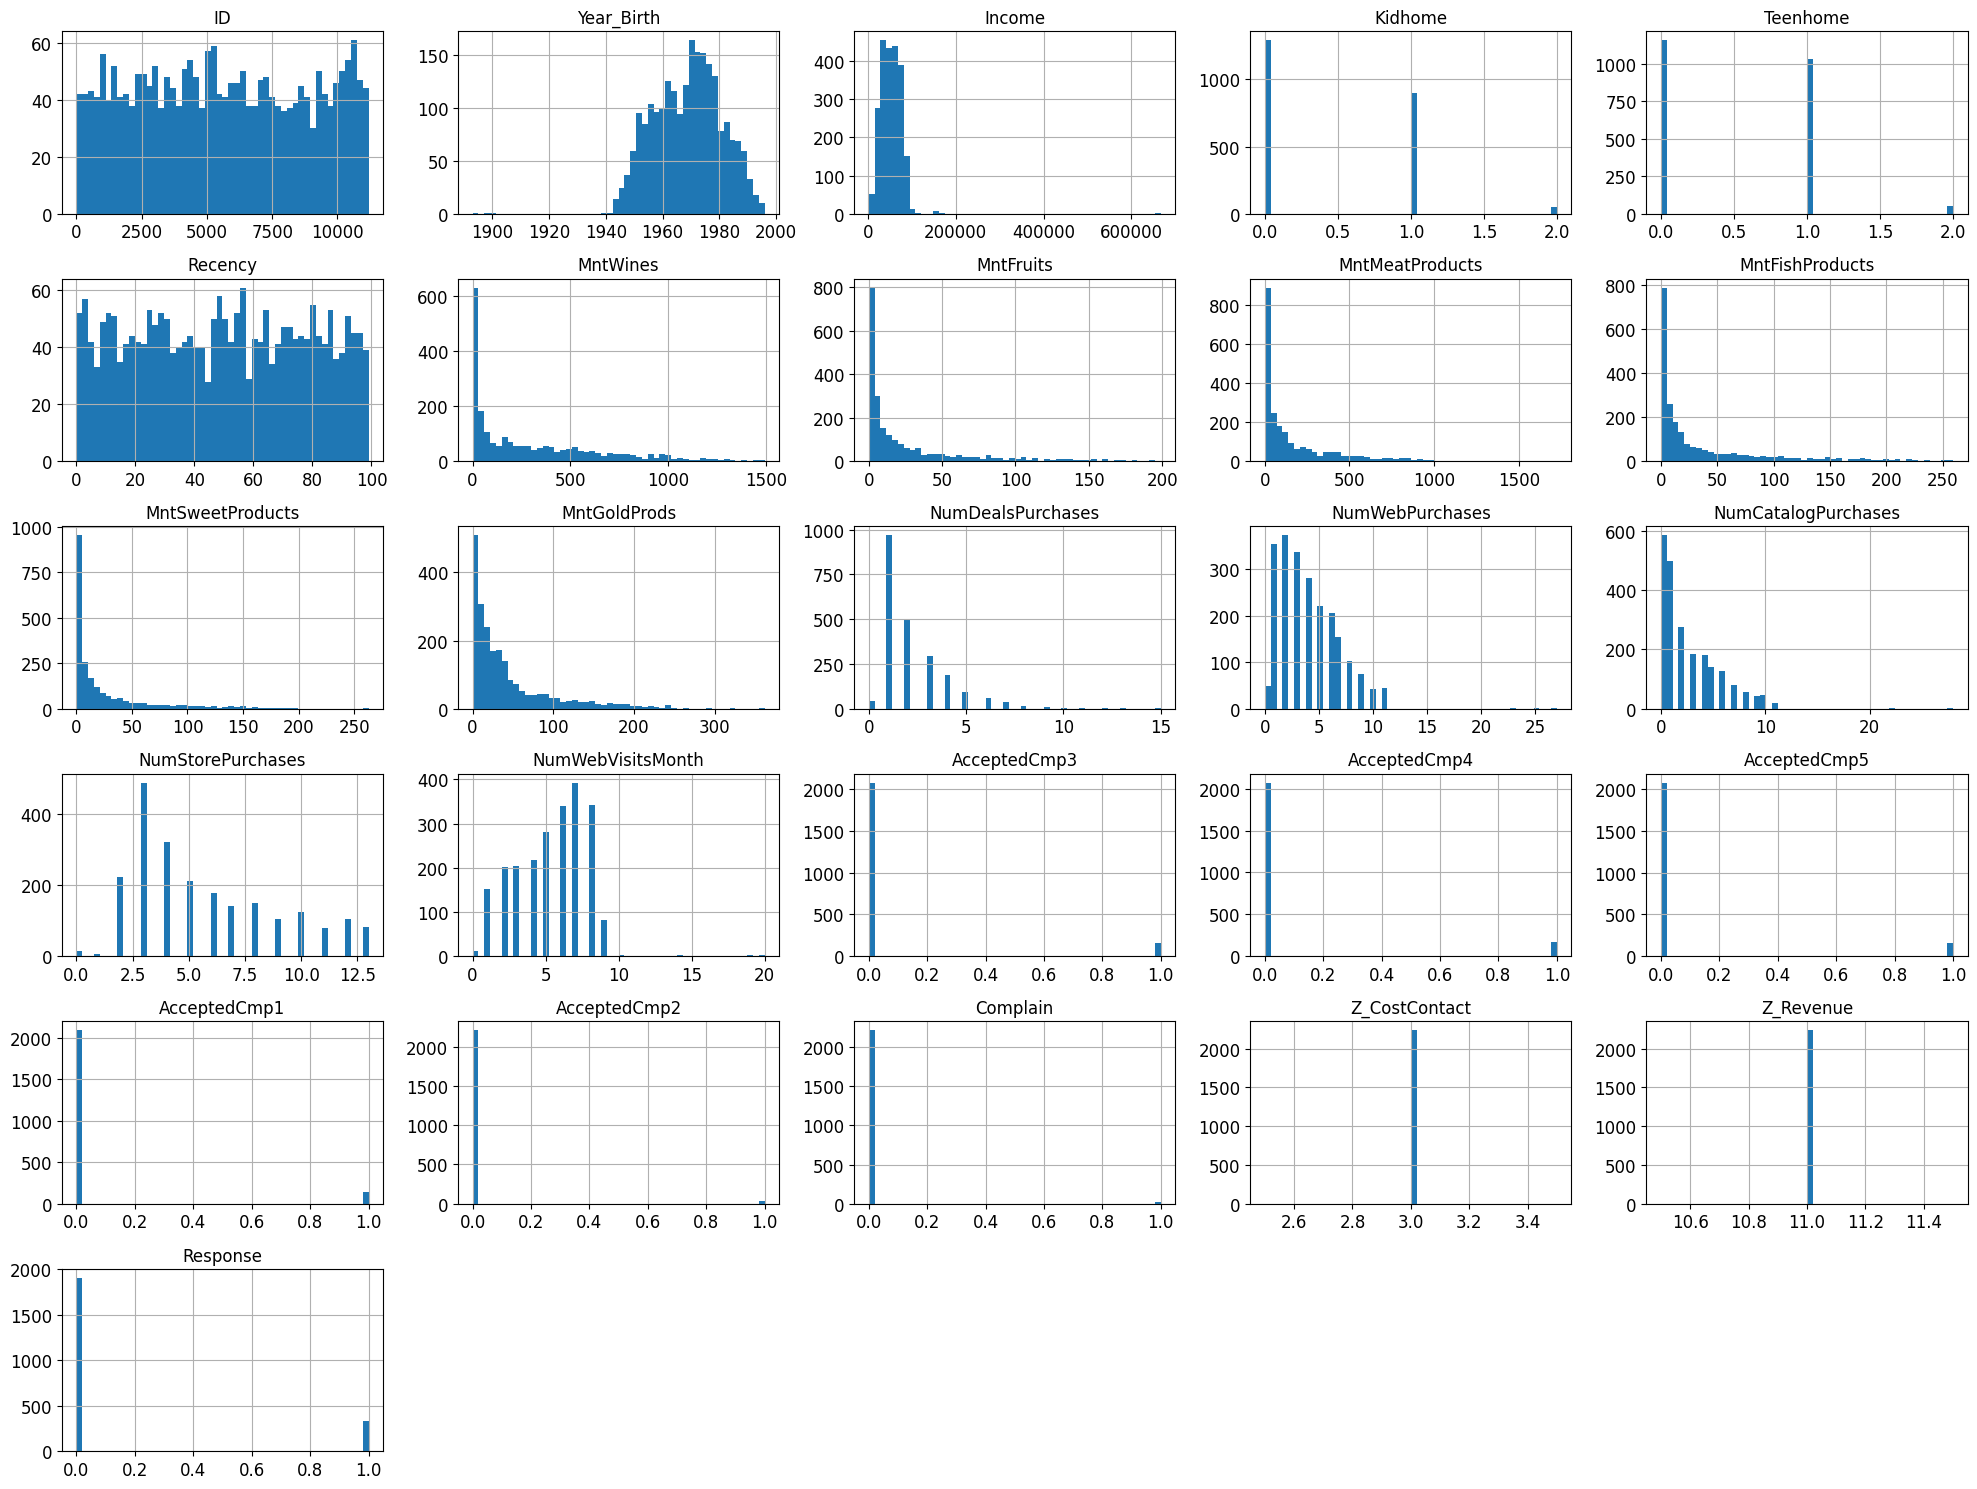

In [0]:
ifood_data.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

________________________________________________________________________________________________________________________________

## 1.3 Creating test set


#### Important note: 

It is common to see the test set split immediately before creating a model. However, following Aurélien Geron's instructions, the test set should be separated even before exploratory analysis. The stratified approach was chosen due to the imbalance of the target variable, which had already been elucidated in the case statement.

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

# Divide dataset
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(ifood_data, ifood_data["Response"]):
    strat_train_set = ifood_data.iloc[train_index]
    strat_test_set = ifood_data.iloc[test_index]

In [0]:
strat_test_set["Response"].value_counts() / len(strat_test_set)

0    0.850446
1    0.149554
Name: Response, dtype: float64

In [0]:
ifood_data["Response"].value_counts() / len(ifood_data)

0    0.850893
1    0.149107
Name: Response, dtype: float64

#####  It can be noted the balance between the categories in Response regarding the initial dataset.

________________________________________________________________________________________________________________________________

## 1.4 Exploratory Data Analysis (EDA)

### 1.4.1 Some preprocessing first

In [0]:
ifood = strat_train_set.copy()

#### Changing data types

In [0]:
ifood.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [0]:
categ_cols = ['ID', 'Education', 'Marital_Status', 'AcceptedCmp1', 
            'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 
            'AcceptedCmp5', 'Complain', 'Response']
            
numeric_cols = ['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 
            'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
            'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
            'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
            'NumStorePurchases', 'NumWebVisitsMonth', 'Z_CostContact', 'Z_Revenue']

timestamp = ["Dt_Customer"]

# Change data types
ifood["Dt_Customer"] = pd.to_datetime(ifood["Dt_Customer"])

In [0]:
ifood.head()

ID  Year_Birth Education  ... Z_CostContact  Z_Revenue  Response
1090  1127        1973       PhD  ...             3         11         0
15    2114        1946       PhD  ...             3         11         1
873    738        1981  2n Cycle  ...             3         11         0
610   7930        1969    Master  ...             3         11         0
657    946        1958  2n Cycle  ...             3         11         0

[5 rows x 29 columns]

In [0]:
duplicate_rows_ifood = ifood[ifood.duplicated()]
print("number of duplicate rows: ", duplicate_rows_ifood.shape)

number of duplicate rows:  (0, 29)


#### Handling with missing values

In [0]:
sample_incomplete_rows = ifood[ifood.isnull().any(axis=1)].head()
sample_incomplete_rows

ID  Year_Birth   Education  ... Z_CostContact  Z_Revenue  Response
133    1295        1963  Graduation  ...             3         11         0
1379  10475        1970      Master  ...             3         11         0
2084   5250        1943      Master  ...             3         11         1
2228   8720        1978    2n Cycle  ...             3         11         0
2078   5079        1971  Graduation  ...             3         11         0

[5 rows x 29 columns]

/databricks/python/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


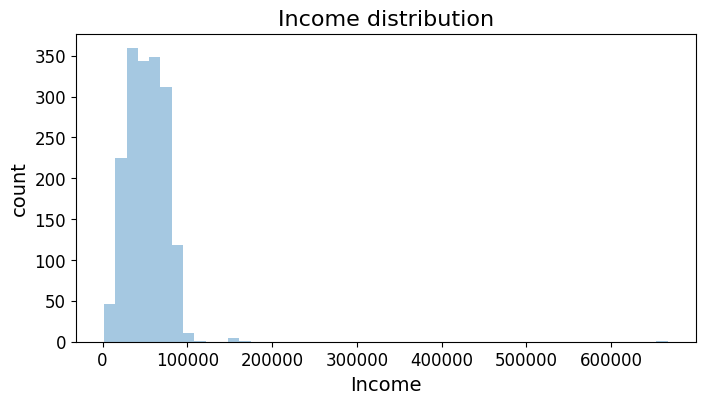

In [0]:
plt.figure(figsize=(8,4))
sns.distplot(ifood['Income'], kde=False, hist=True)
plt.title('Income distribution', size=16)
plt.ylabel('count')
plt.show()

<AxesSubplot:>

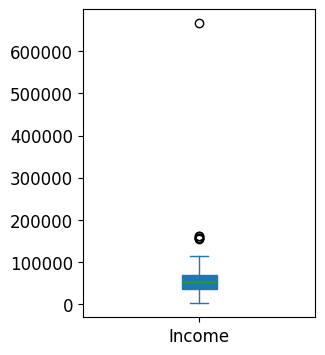

In [0]:
ifood['Income'].plot(kind='box', figsize=(3,4), patch_artist=True)

#### Important note:
Income is a very important variable, based on previous studies and economically speaking. It influences consumption patterns. Therefore, I will remove one outlier from income that is far above the tail, as it will alter my tests in the future. 

Also, to avoid skewing the mean due to outliers, I will input the missing values through the median.

In [0]:
# Remove rows where 'Income' is above 600000
ifood = ifood[ifood['Income'] <= 600000]

In [0]:
# Calculate the median value
median = ifood['Income'].median()

# Fill NaN values with the median value
ifood['Income'].fillna(median, inplace=True)

#### Looking for outliers

Saving figure outliers_plot


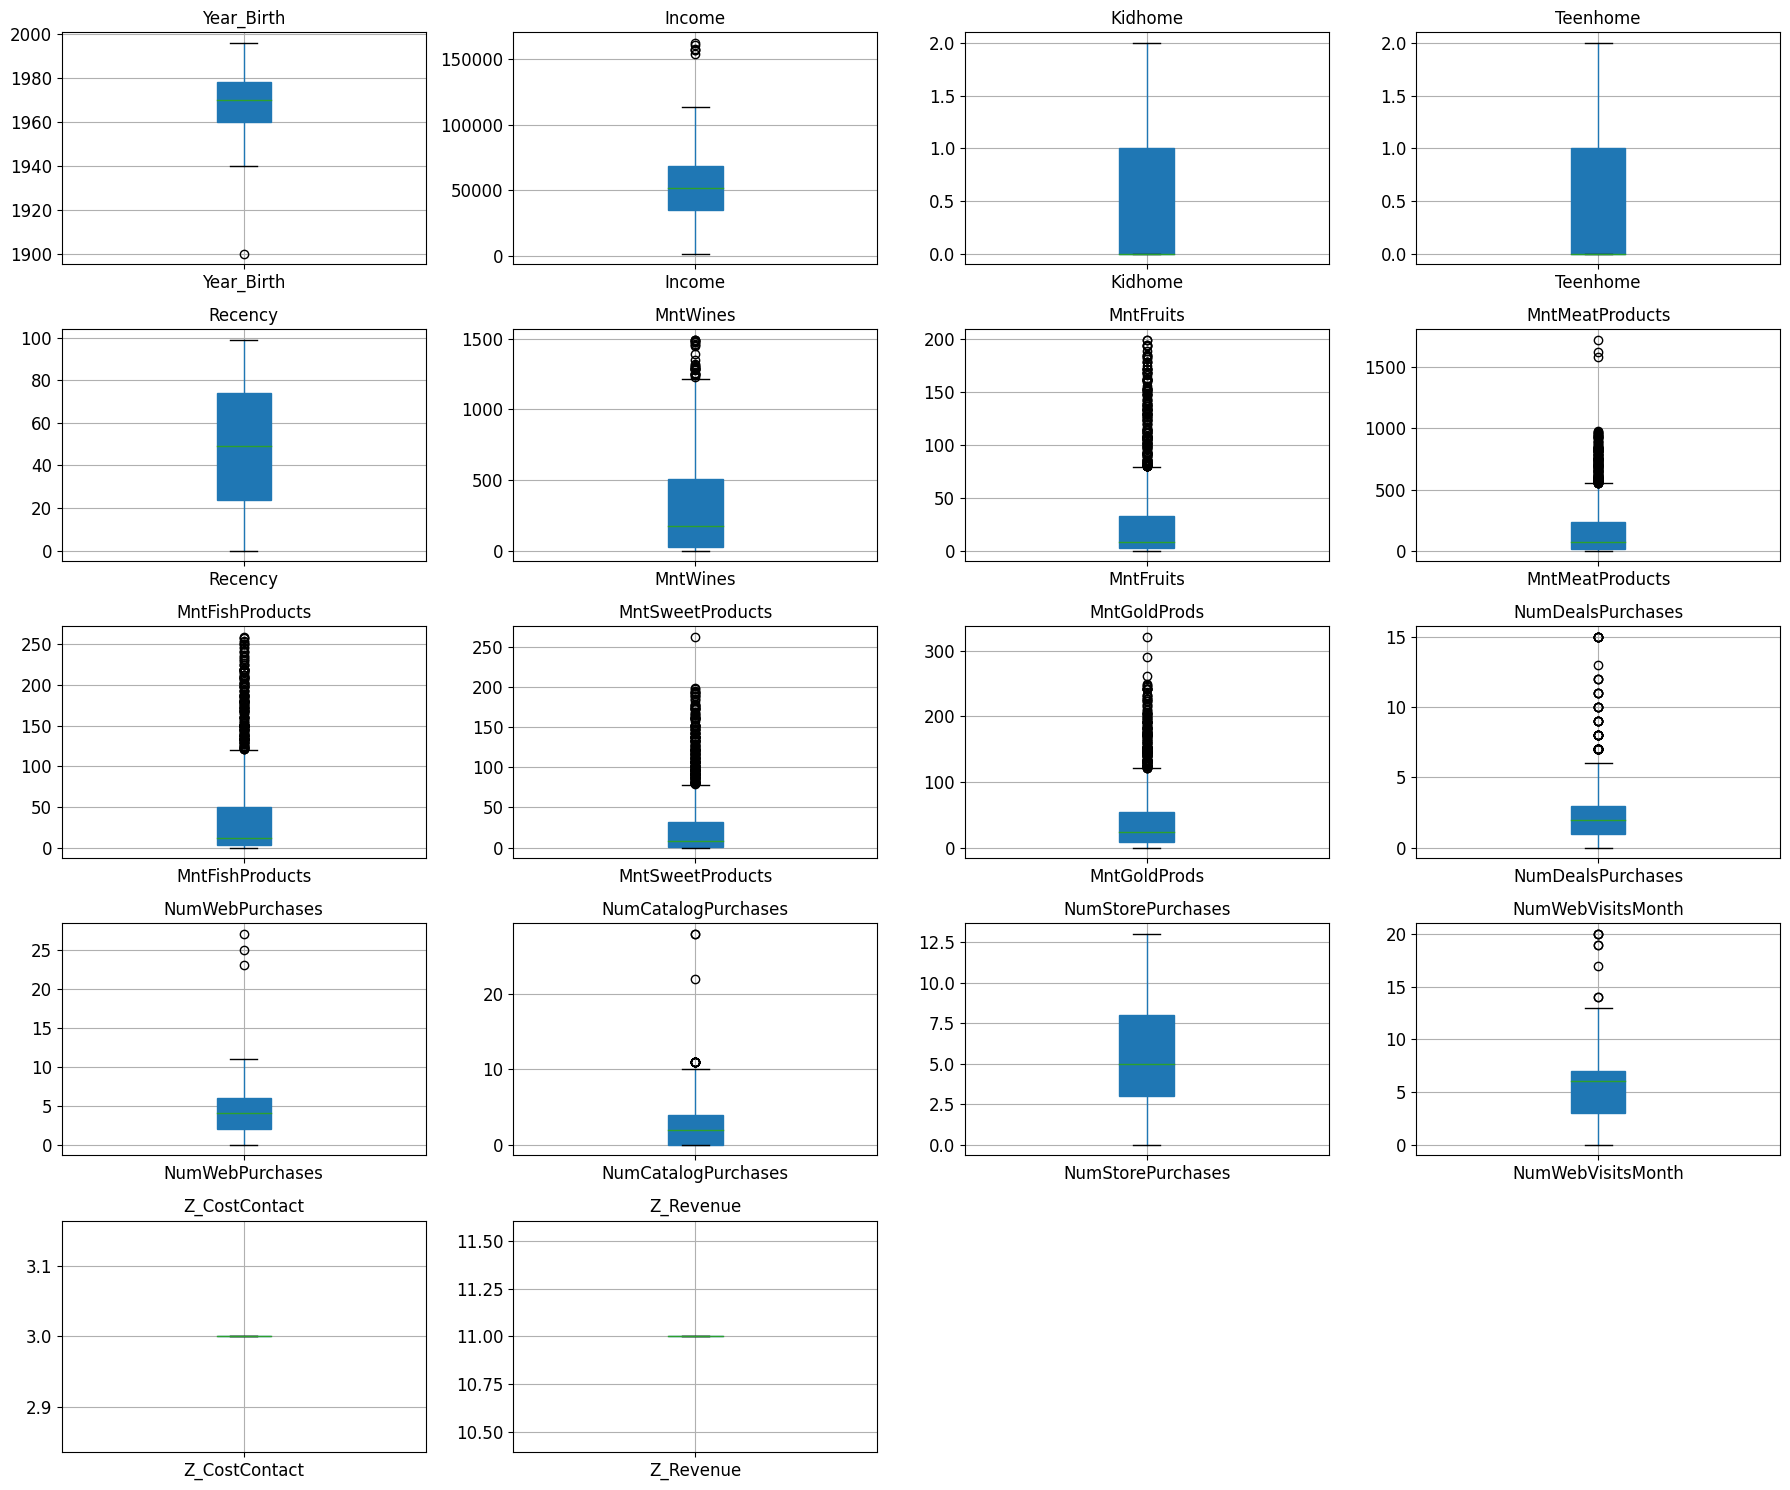

In [0]:
# Removing some variables of the plot
outliers_plot = ifood.drop(columns=['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']).select_dtypes(include=np.number)

# Calculate the number of rows and columns needed
num_vars = len(outliers_plot.columns)
num_cols = 4
num_rows = (num_vars + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 3*num_rows), squeeze=False)

# Flatten axes to iterate over them
axes = axes.flatten()

# Plot boxplots for each numerical variable
for i, column in enumerate(outliers_plot.columns):
    outliers_plot.boxplot(column=column, ax=axes[i], patch_artist=True)
    axes[i].set_title(column)

# Hide any empty subplots
for j in range(num_vars, num_cols*num_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
save_fig("outliers_plot")
plt.show()

#### Important note:

Strange to have a birth year 1893 when the oldest person in the world was born in 1907. I'll consider 100 years as the maximum, born after 1924. I will keep all other outliers because they seem relevant for analysis, even though additional treatments are needed to model with them.

In [0]:
# Removing age > 100
ifood = ifood.drop(ifood[ifood['Year_Birth'] < 1924].index)

#### Important note:

Z_CostContact (3 MU) and Z_Revenue (11 MU) are constants used for measuring results, so I'm going to drop them to have a cleaner dataset.

In [0]:
# Drop Z_CostContact and Z_Revenue
ifood.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True)

________________________________________________________________________________________________________________________________

### 1.4.2 Exploring distribution and correlations

In [0]:
ifood["Education"].value_counts()

Graduation    877
PhD           383
Master        303
2n Cycle      159
Basic          47
Name: Education, dtype: int64

In [0]:
# Count the education levels
education_counts = ifood['Education'].value_counts(normalize=True) * 100

# Create DataFrame
df_education = pd.DataFrame({'Education_Level': education_counts.index,
                             'Percentage': education_counts.values})

# Create bar chart
fig = px.bar(df_education, x='Education_Level', y='Percentage',
             title='Distribution of Education Levels',
             labels={'Percentage': 'Percentage (%)', 'Education_Level': 'Education Level'},
             color='Education_Level', color_discrete_sequence=ifood_colors)

# Add percentages on top of bars
fig.update_traces(texttemplate='%{y:.2f}%', textposition='outside')

# Show plot
save_fig("education_plot")
fig.show()

Saving figure education_plot


<Figure size 640x480 with 0 Axes>

In [0]:
ifood["Marital_Status"].value_counts()

Married     695
Together    452
Single      374
Divorced    182
Widow        59
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64

In [0]:
# Dropping rows with values "Alone", "Absurd", and "YOLO" in the "Marital_Status" column
ifood = ifood[~ifood["Marital_Status"].isin(["Alone", "Absurd", "YOLO"])]

In [0]:
# Count the marital status
marital_counts = ifood['Marital_Status'].value_counts(normalize=True) * 100

# Create DataFrame
df_marital = pd.DataFrame({'Marital_Status': marital_counts.index,
                           'Percentage': marital_counts.values})

# Create bar chart for Marital_Status with ifood_colors
fig_marital = px.bar(df_marital, x='Marital_Status', y='Percentage',
                      title='Distribution of Marital Status',
                      labels={'Percentage': 'Percentage (%)', 'Marital_Status': 'Marital Status'},
                      color='Marital_Status', color_discrete_sequence=ifood_colors)

# Add percentages on top of bars
fig_marital.update_traces(texttemplate='%{y:.2f}%', textposition='outside')

# Show plot
save_fig("marital_status_plot")
fig_marital.show()

Saving figure marital_status_plot


<Figure size 640x480 with 0 Axes>

Saving figure numeric_histogram_plots


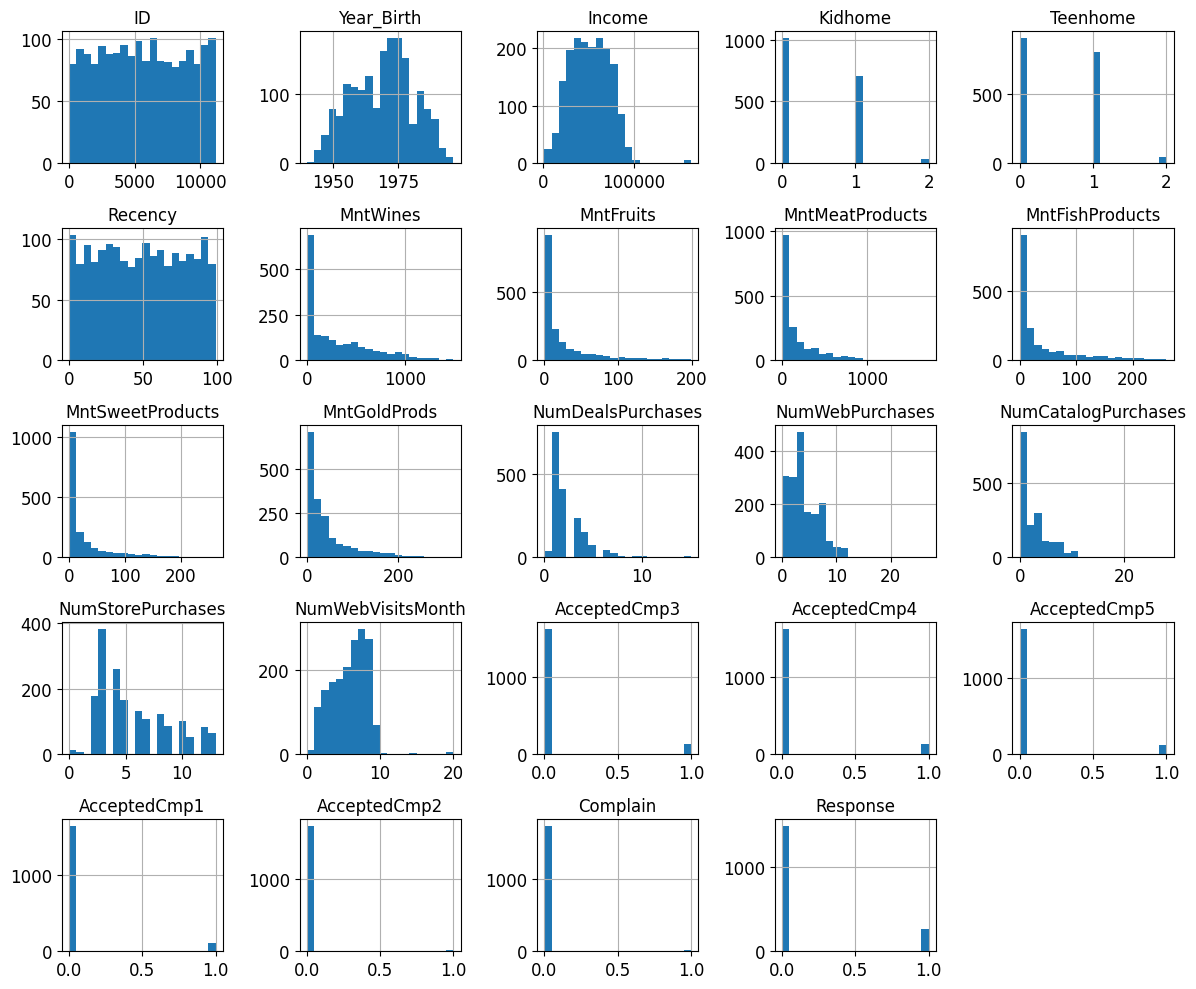

In [0]:
# Distribution visualization of numeric variables

# Get the list of numerical column names
numeric_vars = ifood.select_dtypes(include=['float64', 'int64']).columns

ifood[numeric_vars].hist(bins=20, figsize=(12, 10))
save_fig("numeric_histogram_plots")
plt.show()

In [0]:
ifood.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response'],
      dtype='object')

In [0]:
from scipy.stats import skew, kurtosis

numeric_cols = ['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
                'Recency', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','NumDealsPurchases', 'NumWebPurchases', 
                'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

skew_type_list = []
skew_val_list = []
kurtosis_val_list = []

for column in numeric_cols:
    data = ifood[column].dropna(axis=0) 
    q1 = data.quantile(q=0.25)
    mean = round(data.mean(), 3)
    median = data.median()
    mode = data.mode()[0]
    q3 = data.quantile(q=0.75)
    # skew_val = round(data.skew(),3)
    skew_val = round(skew(data, nan_policy="omit"),3)
    kurtosis_val = round(kurtosis(data, nan_policy="omit"),3)

    if (mean == median == mode) or (-0.2 < skew_val < 0.2):
        skew_type = "Normal Distribution (Symmetric)"
    elif mean < median < mode:
        skew_type = "Negatively Skewed"
        if skew_val <= -1:
            skew_type = "Highly Negatively Skewed"
        elif -0.5 >= skew_val > -1:
            skew_type = "Moderately Negatively Skewed"
        else :
            skew_type = "Moderately Normal Distribution (Symmetric)"
    else:
        skew_type = "Positively Skewed"
        if skew_val >= 1:
            skew_type = "Highly Positively Skewed"
        elif 0.5 <= skew_val < 1:
            skew_type = "Moderately Positively Skewed"
        else :
            skew_type = "Moderately Normal Distribution (Symmetric)"
    skew_type_list.append(skew_type)
    skew_val_list.append(skew_val)
    kurtosis_val_list.append(kurtosis_val)
            
dist = pd.DataFrame({
    "Column Name": numeric_cols,
    "Skewness": skew_val_list,
    "Kurtosis": kurtosis_val_list,
    "Type of Distribution": skew_type_list
})

# for bimodial

dist.loc[dist["Column Name"].isin(["Kidhome", "Teenhome"]), "Type of Distribution"] = "Bimodal Distribution"
dist

Column Name  ...                        Type of Distribution
0            Year_Birth  ...             Normal Distribution (Symmetric)
1                Income  ...  Moderately Normal Distribution (Symmetric)
2               Kidhome  ...                        Bimodal Distribution
3              Teenhome  ...                        Bimodal Distribution
4               Recency  ...             Normal Distribution (Symmetric)
5              MntWines  ...                    Highly Positively Skewed
6             MntFruits  ...                    Highly Positively Skewed
7       MntMeatProducts  ...                    Highly Positively Skewed
8               Recency  ...             Normal Distribution (Symmetric)
9       MntFishProducts  ...                    Highly Positively Skewed
10     MntSweetProducts  ...                    Highly Positively Skewed
11         MntGoldProds  ...                    Highly Positively Skewed
12    NumDealsPurchases  ...                    Highly Positively Skewed
13      NumWebPurchases  ...                    Highly Positively Skewed
14  NumCatalogPurchases  ...                    Highly Positively Skewed
15    NumStorePurchases  ...                Moderately Positively Skewed
16    NumWebVisitsMonth  ...  Moderately Normal Distribution (Symmetric)

[17 rows x 4 columns]

Saving figure distr_amount_plots


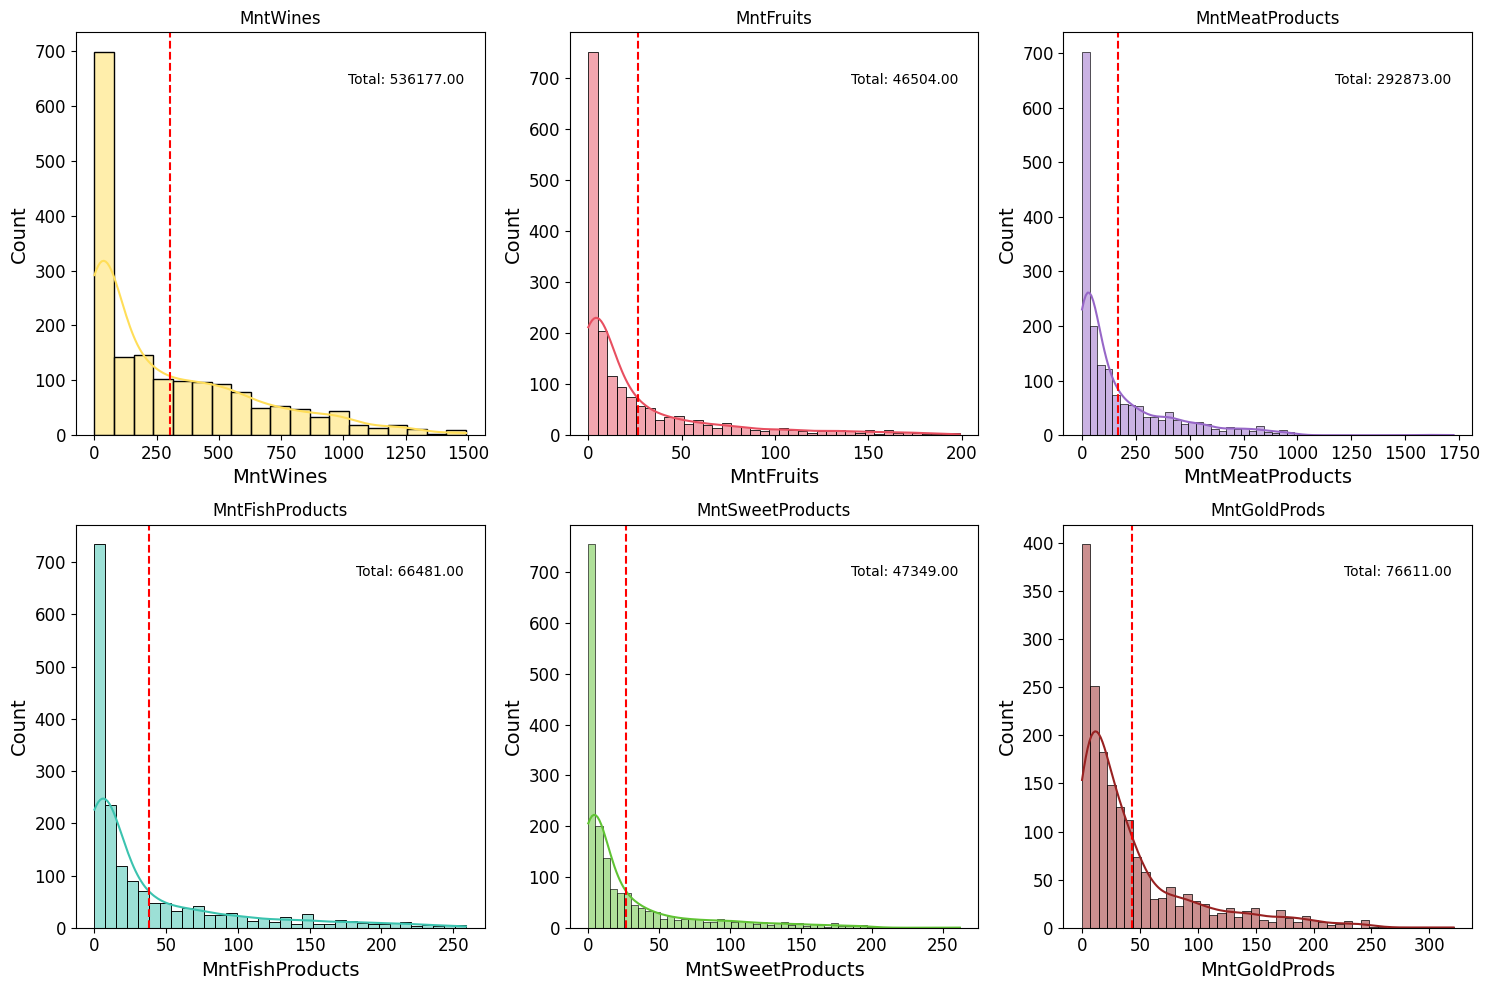

In [0]:
# List of variables that were summed to calculate total amounts
total_amount_vars = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Create subplots for distribution plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten axes to iterate over them
axes = axes.flatten()

# Create distribution plots for each variable
for i, var in enumerate(total_amount_vars):
    sns.histplot(ifood[var], ax=axes[i], kde=True, color=ifood_colors[i])
    axes[i].set_title(var)
    # Add mean to the plot
    mean_value = ifood[var].mean()
    axes[i].axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
    # Add total value to the plot
    total_value = ifood[var].sum()
    axes[i].text(0.95, 0.9, f'Total: {total_value:.2f}', ha='right', va='top', transform=axes[i].transAxes)

plt.tight_layout()
save_fig("distr_amount_plots")
plt.show()

Saving figure distr_purchases_plots


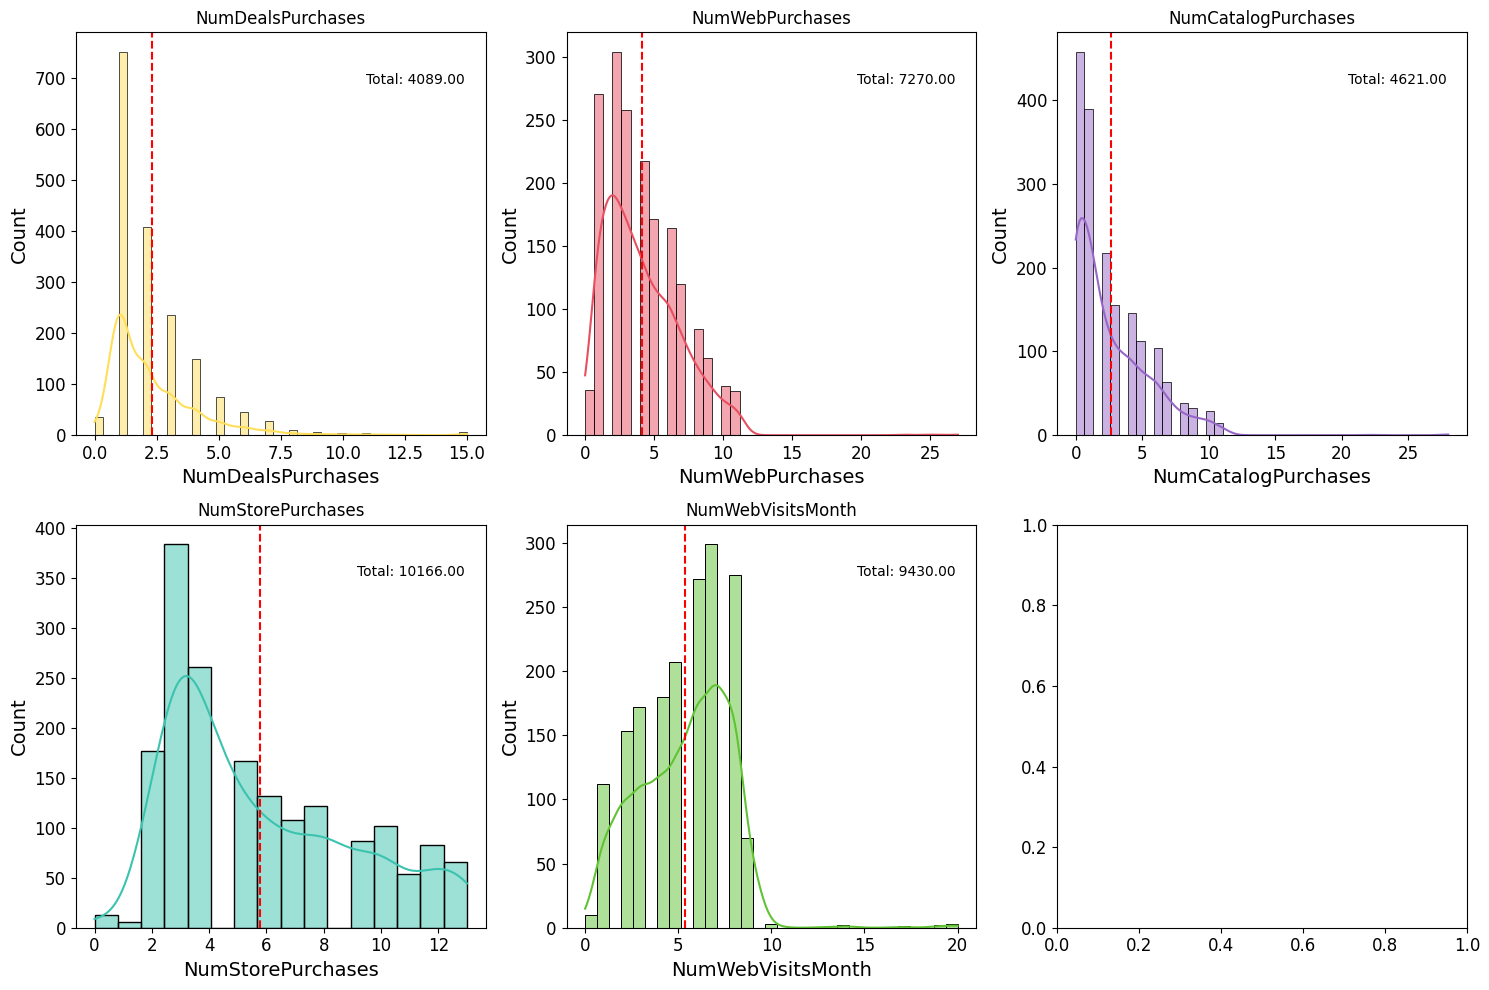

In [0]:
# List of variables related to volume of purchases
purchases_vars = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

# Create subplots for distribution plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten axes to iterate over them
axes = axes.flatten()

# Create distribution plots for each variable
for i, var in enumerate(purchases_vars):
    sns.histplot(ifood[var], ax=axes[i], kde=True, color=ifood_colors[i])
    axes[i].set_title(var)
    # Add mean to the plot
    mean_value = ifood[var].mean()
    axes[i].axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
    # Add total value to the plot
    total_value = ifood[var].sum()
    axes[i].text(0.95, 0.9, f'Total: {total_value:.2f}', ha='right', va='top', transform=axes[i].transAxes)

plt.tight_layout()
save_fig("distr_purchases_plots")
plt.show()

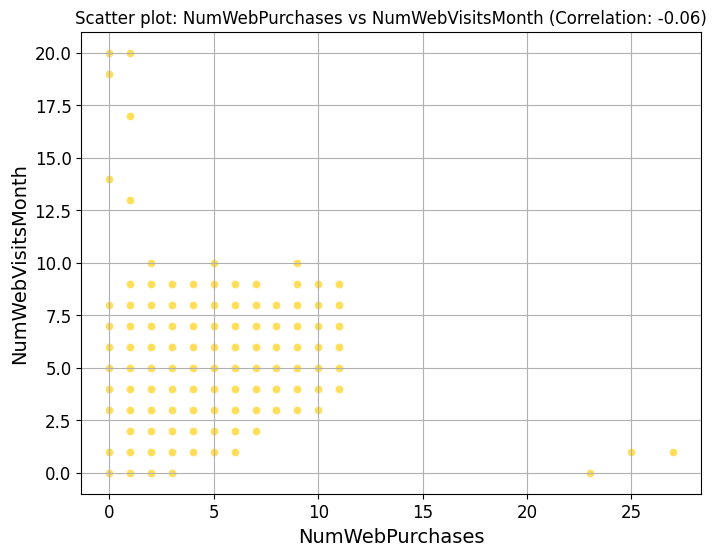

In [0]:
# Calculate correlation coefficient
correlation = ifood['NumWebPurchases'].corr(ifood['NumWebVisitsMonth'])

# Scatter plot between NumWebPurchases and NumWebVisitsMonth
plt.figure(figsize=(8, 6))
sns.scatterplot(x='NumWebPurchases', y='NumWebVisitsMonth', data=ifood, color=ifood_colors[0])
plt.title(f'Scatter plot: NumWebPurchases vs NumWebVisitsMonth (Correlation: {correlation:.2f})')
plt.xlabel('NumWebPurchases')
plt.ylabel('NumWebVisitsMonth')
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

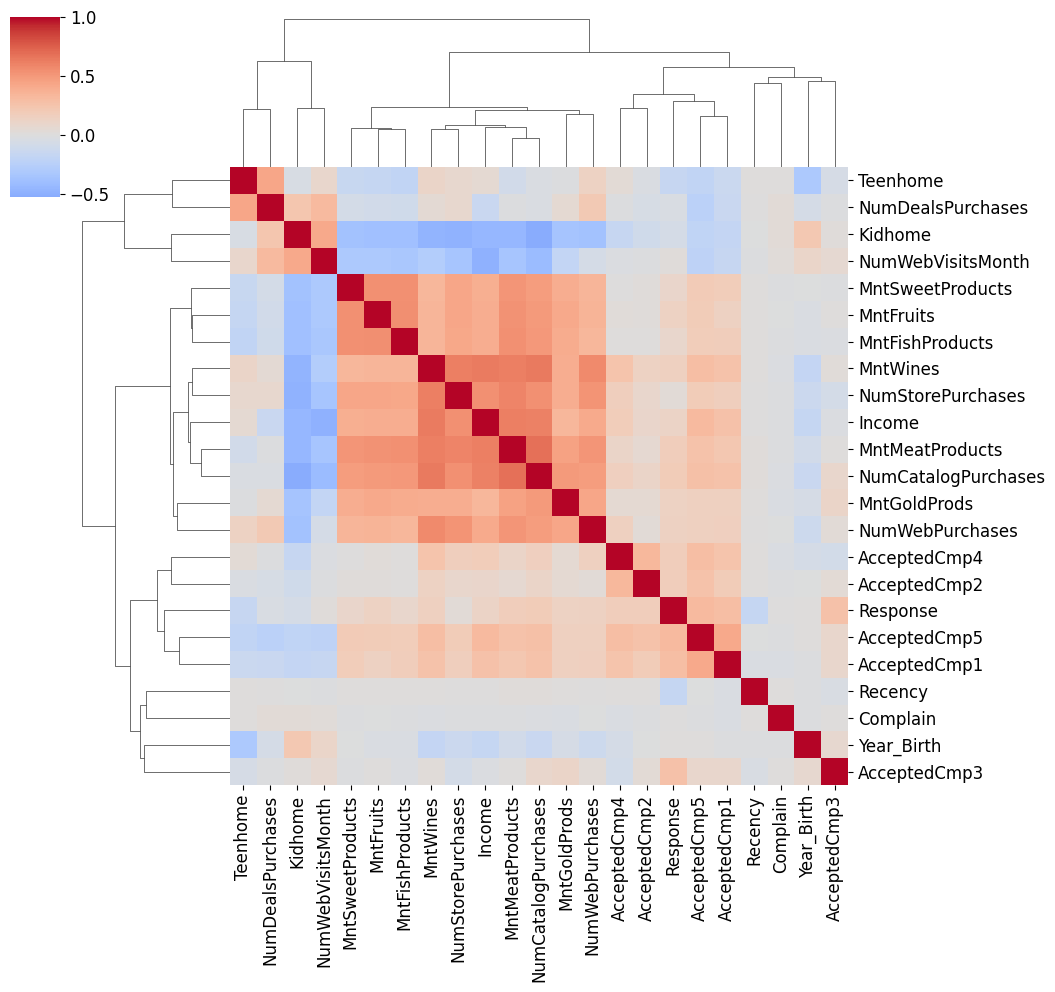

In [0]:
# Calculate correlation matrix using non-parametric test of correlation (Kendall)
corrs = ifood.drop(columns='ID').select_dtypes(include=np.number).corr(method='kendall')

# Plot clustered heatmap of correlations
plt.figure(figsize=(10, 8))
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0)
plt.show()

In [0]:
corr_matrix = ifood.corr(method='kendall')
corr_matrix['Response'].sort_values(ascending=False)

Response               1.000000
AcceptedCmp5           0.320623
AcceptedCmp1           0.297717
AcceptedCmp3           0.274044
NumCatalogPurchases    0.195358
AcceptedCmp2           0.176337
AcceptedCmp4           0.175754
MntMeatProducts        0.173132
MntWines               0.154900
NumWebPurchases        0.144719
MntGoldProds           0.141723
MntFruits              0.140679
Income                 0.124885
MntSweetProducts       0.101003
MntFishProducts        0.087294
NumStorePurchases      0.030880
NumWebVisitsMonth      0.020553
Year_Birth             0.016992
Complain               0.004962
NumDealsPurchases     -0.030183
ID                    -0.031190
Kidhome               -0.067404
Teenhome              -0.158013
Recency               -0.165174
Name: Response, dtype: float64

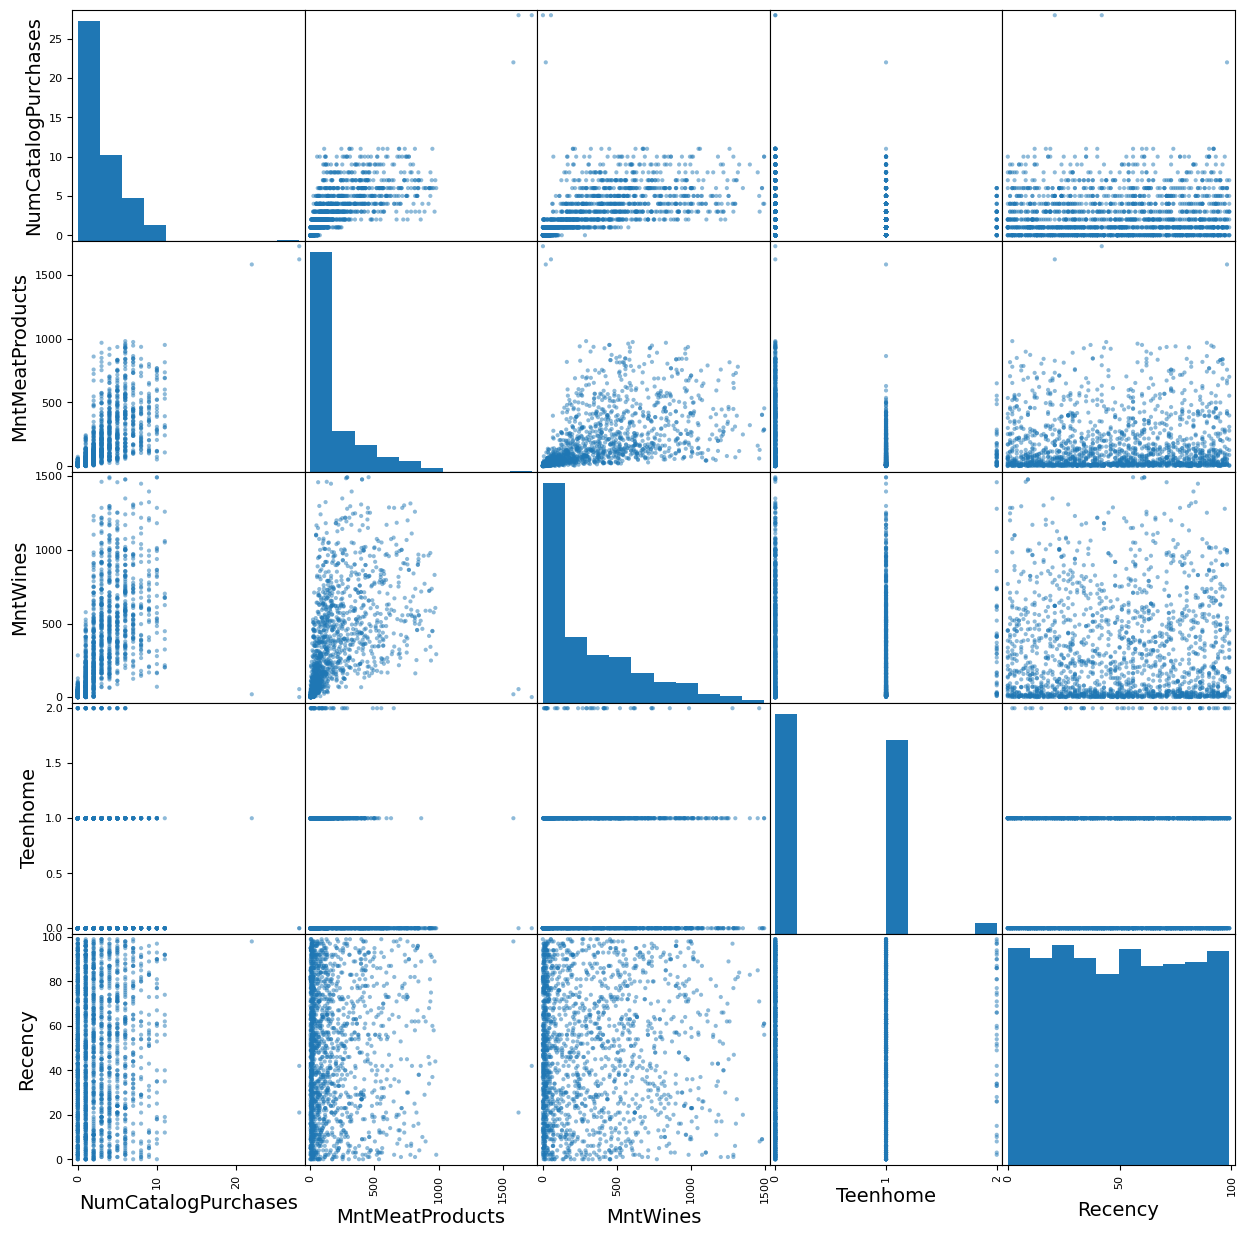

In [0]:
from pandas.plotting import scatter_matrix

attributes = ['NumCatalogPurchases', 'MntMeatProducts', 'MntWines', 'Teenhome', 'Recency']

scatter_matrix(ifood[attributes], figsize=(15, 15))
plt.show()

________________________________________________________________________________________________________________________________

### 1.4.3 Feature Engineering

### New features:

1. The time of being a customer can be calculated in years ('Time_Customer_Years') or months ('Time_Customer_Months') from 'Dt_Customer'.
2. Age can be calculated from 'Year_Birth'.
3. The total amount spent ('Total_Mnt') can be engineered from the sum of all features containing the keyword 'Mnt'.
4. The total purchases ('Total_Purchases') can be engineered from the sum of all features containing the keyword 'Purchases'.
5. The total number of campaigns accepted ('Total_Campaigns_Accepted') can be engineered from the sum of all features containing 6. the keywords 'Cmp' and 'Response'.
7. The number of children ('Num_Children') can be engineered from the sum of 'Kidhome' and 'Teenhome'.
8. 'Income_Per_Person' can be calculated considering Marital_Status and Children.

In [0]:
from datetime import datetime

# Calculate time as customer in months
current_date = datetime.now()  # Get the current date

# Time as customer in months
ifood['Time_Customer_Months'] = ((current_date - ifood['Dt_Customer']) / np.timedelta64(1, 'M')).astype(int)

# Time as customer in months into years
ifood['Time_Customer_Years'] = ifood['Time_Customer_Months'] / 12

# Round 'Time_As_Customer_Years' to one decimal place
ifood['Time_Customer_Years'] = ifood['Time_Customer_Years'].round(1)

In [0]:
# Calculate age
current_year = current_date.year
ifood['Age'] = current_year - ifood['Year_Birth']  # Calculate age

max_age = ifood['Age'].max()
print("Maximum Age:", max_age)

Maximum Age: 85


In [0]:
# Drop those 2 columns, they're not necessary anymore
ifood.drop(columns=['Year_Birth', 'Dt_Customer'], inplace=True)

In [0]:
# Total Amount Spent
mnt_cols = [col for col in ifood.columns if 'Mnt' in col and 'Gold' not in col]
ifood['Total_Mnt'] = ifood[mnt_cols].sum(axis=1)

# Total Purchases
purchase_cols = [col for col in ifood.columns if 'Purchases' in col]
ifood['Total_Purchases'] = ifood[purchase_cols].sum(axis=1)

# Total Campaigns Accepted
campaign_cols = [col for col in ifood.columns if 'Cmp' in col] + ['Response']
ifood['Total_Campaigns_Accepted'] = ifood[campaign_cols].sum(axis=1)

In [0]:
# Initial treatment according to the relationship status
ifood['Income_Per_Person'] = ifood['Income']  # Creating a new column for income per person

# Number of children
ifood['Num_Children'] = ifood['Kidhome'] + ifood['Teenhome']

# Mapping persons per Marital Status
marital_status_mapping = {'Married': 2, 'Together': 2, 'Single': 1, 'Divorced': 1, 'Widow': 1}
ifood['Marital_Status_Codf'] = ifood['Marital_Status'].map(marital_status_mapping)

# Adding the number of children
ifood['Num_Family_Members'] = ifood['Marital_Status_Codf'] + ifood['Num_Children']

# Calculating the average income per person
ifood['Income_Per_Person'] = ifood['Income_Per_Person'] / ifood['Num_Family_Members']

In [0]:
ifood.drop(columns='Marital_Status_Codf', inplace=True)

In [0]:
ifood[['Time_Customer_Months', 'Time_Customer_Years', 'Age', 'Total_Mnt', 'Total_Purchases', 'Num_Children', 'Income_Per_Person']].head()

Time_Customer_Months  ...  Income_Per_Person
1090                   127  ...       42922.000000
15                     145  ...       82800.000000
873                    129  ...       14131.666667
610                    136  ...       26877.000000
657                    147  ...       13245.000000

[5 rows x 7 columns]

________________________________________________________________________________________________________________________________

### 1.4.4 Deep dive into features

Saving figure outliers_eng_plot


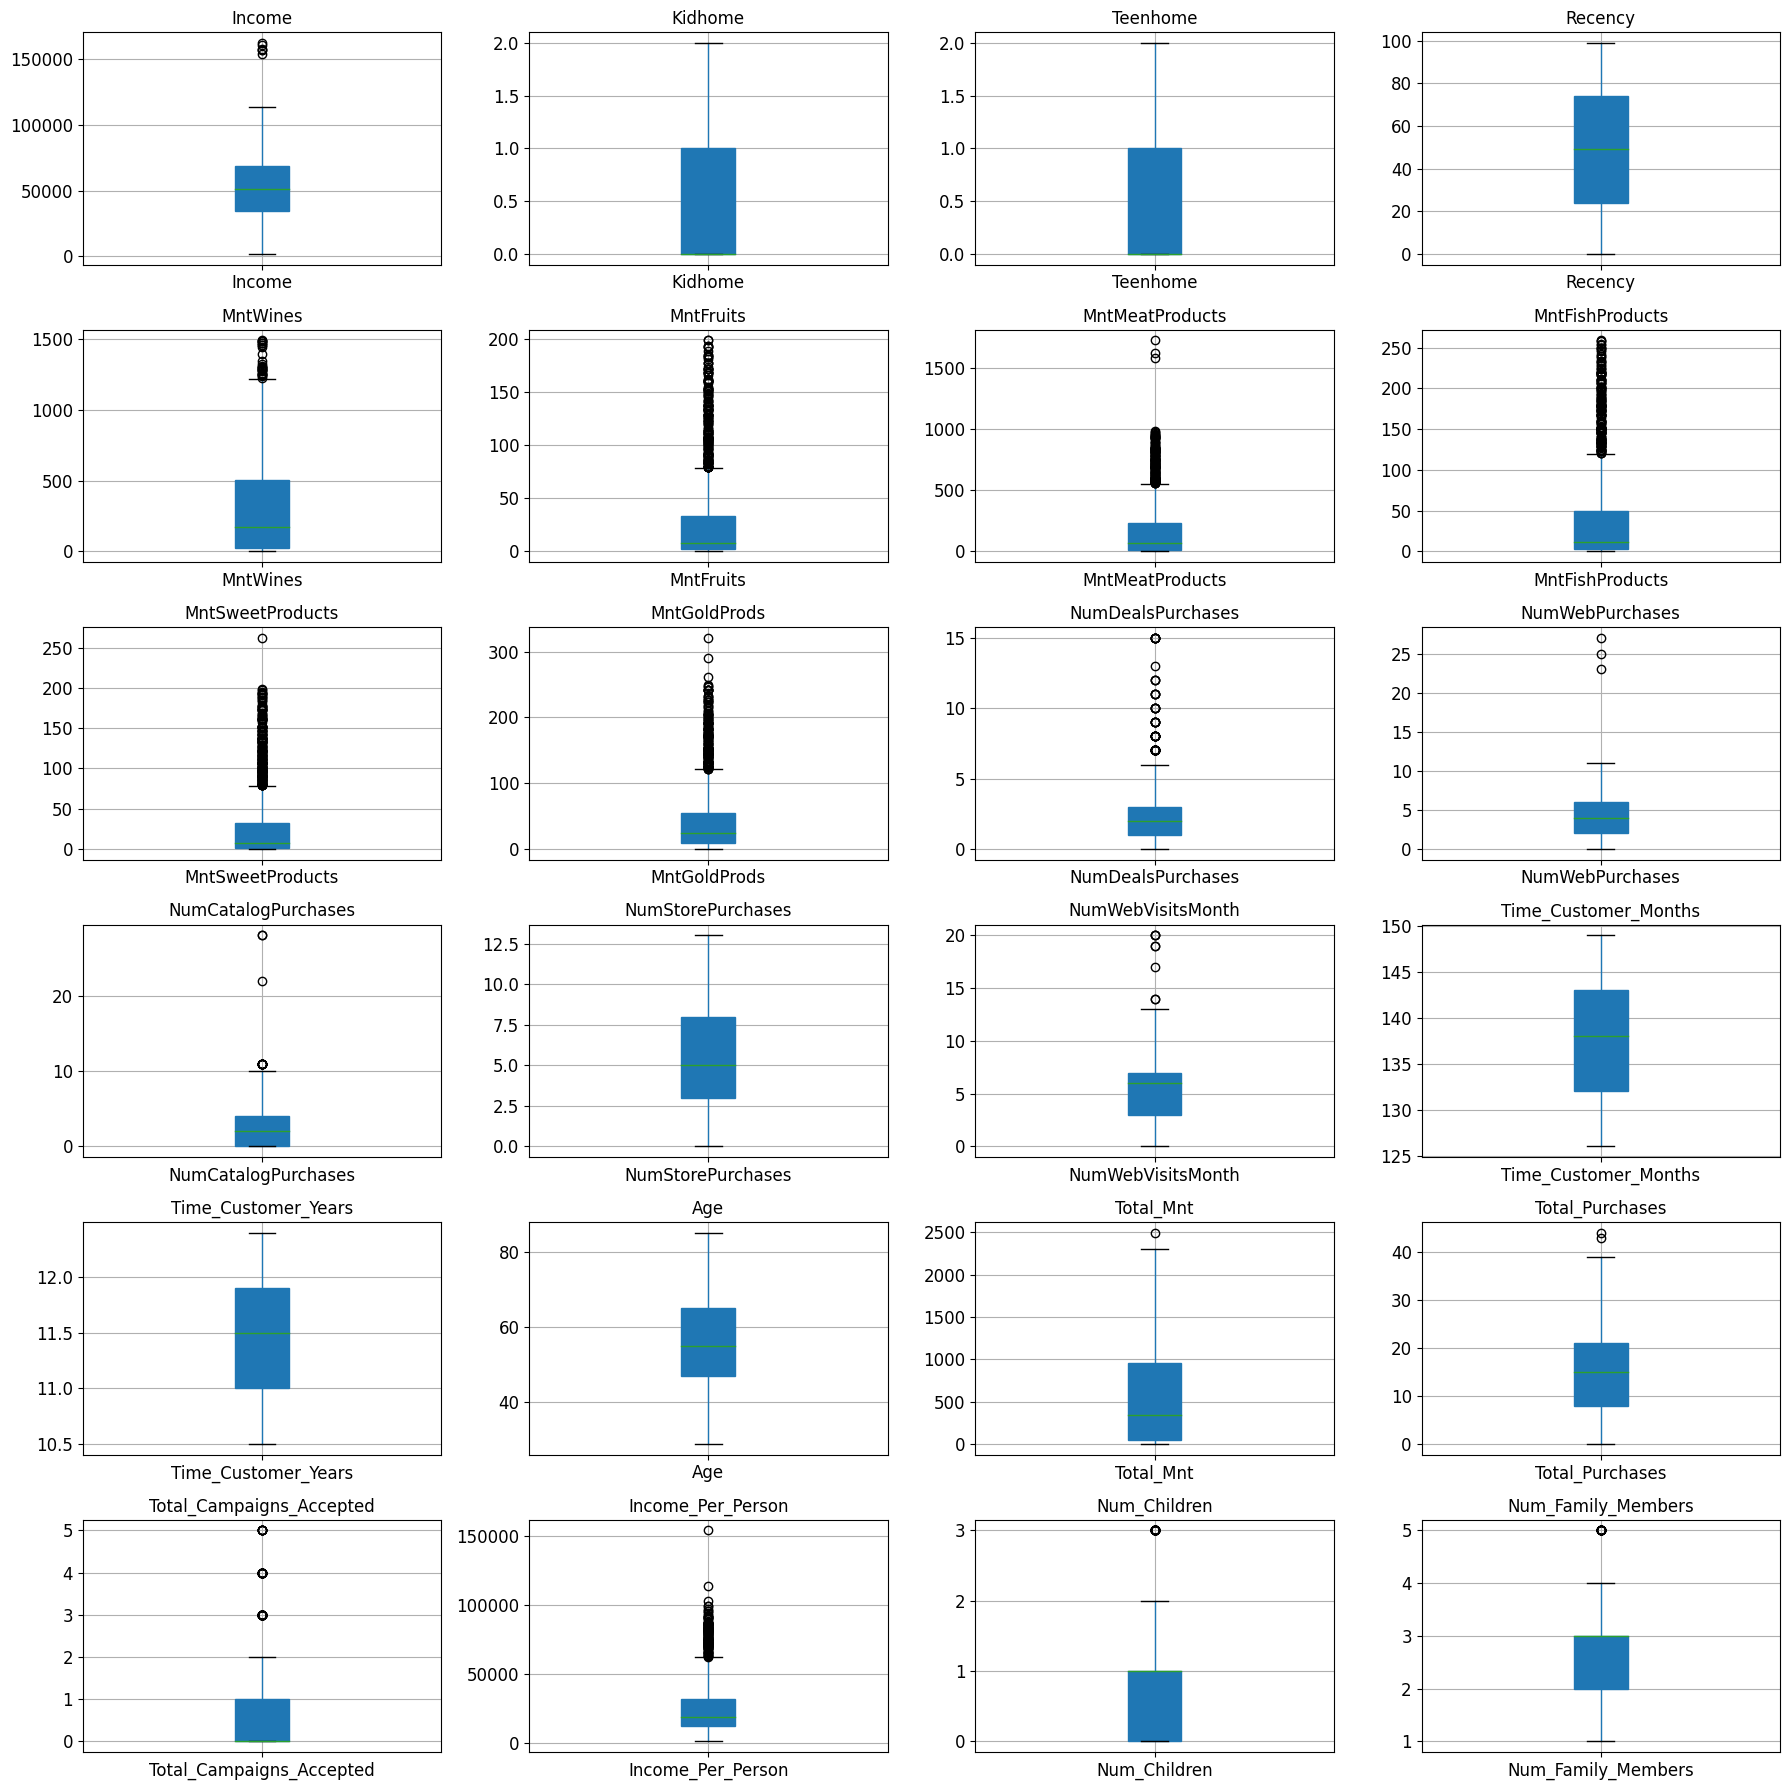

In [0]:
# Removing some variables of the plot
outliers_plot = ifood.drop(columns=['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']).select_dtypes(include=np.number)

# Calculate the number of rows and columns needed
num_vars = len(outliers_plot.columns)
num_cols = 4
num_rows = (num_vars + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 3*num_rows), squeeze=False)

# Flatten axes to iterate over them
axes = axes.flatten()

# Plot boxplots for each numerical variable
for i, column in enumerate(outliers_plot.columns):
    outliers_plot.boxplot(column=column, ax=axes[i], patch_artist=True)
    axes[i].set_title(column)

# Hide any empty subplots
for j in range(num_vars, num_cols*num_rows):
    fig.delaxes(axes[j])

plt.tight_layout()
save_fig("outliers_eng_plot")
plt.show()

<Figure size 1000x800 with 0 Axes>

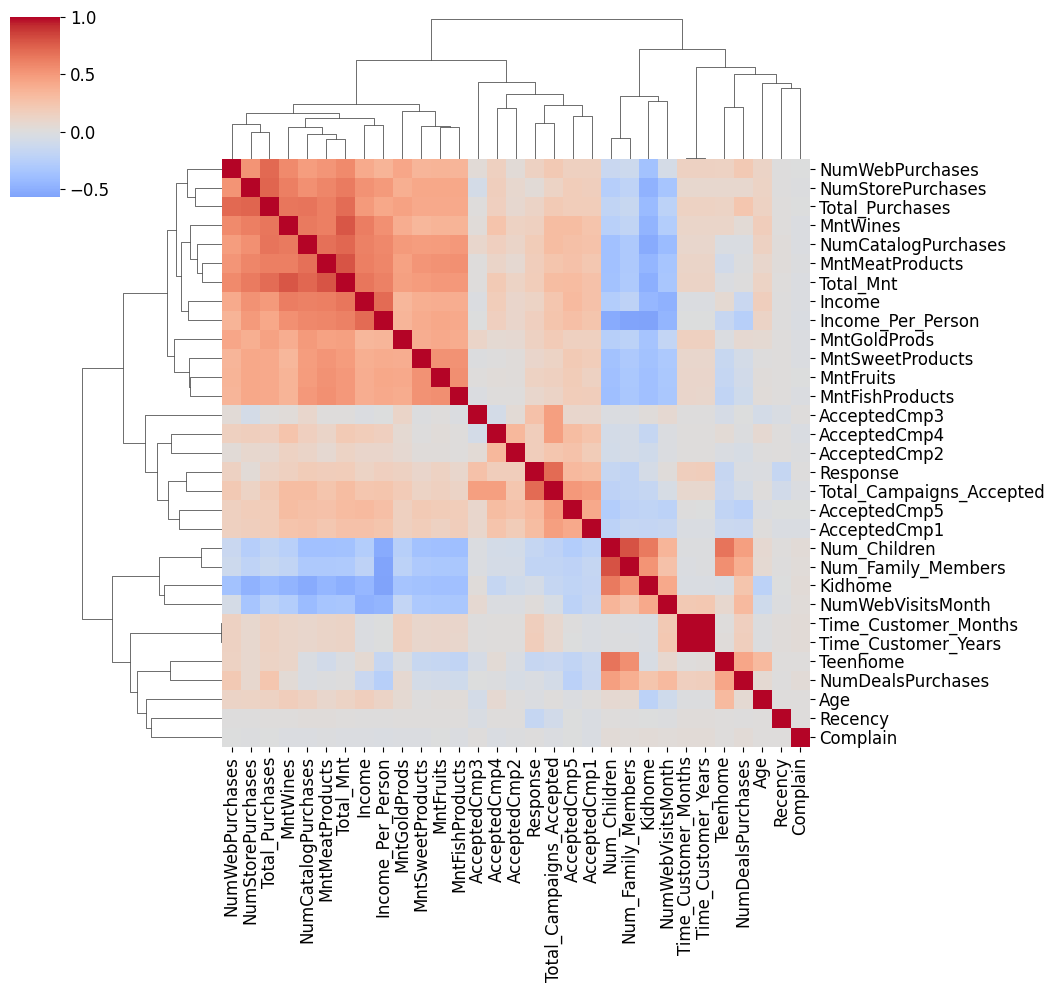

In [0]:
# Calculate correlation matrix using non-parametric test of correlation (Kendall)
corrs = ifood.drop(columns='ID').select_dtypes(include=np.number).corr(method='kendall')

# Plot clustered heatmap of correlations
plt.figure(figsize=(10, 8))
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0)
plt.show()

##### Important note:

We can observe three clusters of correlated variables:

    1. HIGH INCOME: Income, amount spent on products, and number of purchases show a moderate positive correlation.
    2. CAMPAIGNS: Acceptance of campaigns exhibits a moderate positive correlation.
    3. PARENTS: There is a moderate negative correlation between spending (value and volume) on products and the number of children.


Anomalies:

    1. 'NumWebVisitsMonth' does not correlate with an increased number of web purchases 'NumWebPurchases', but is positively correlated with 'NumDealsPurchases', suggesting that deals are an effective way to stimulate purchases on the website.

Saving figure total_mnt_income_effect


<Figure size 640x480 with 0 Axes>

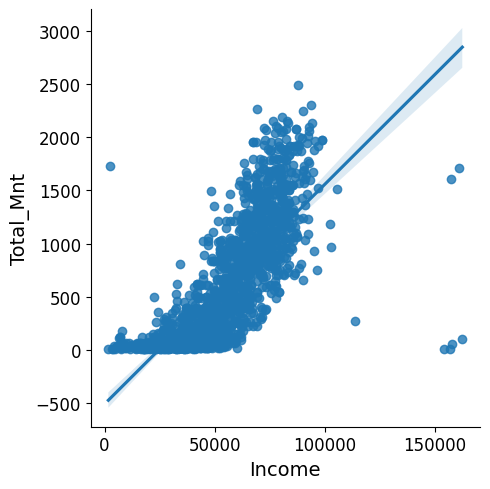

In [0]:
# Relationship between 'Total_Mnt' and 'Income'
save_fig('total_mnt_income_effect')
sns.lmplot(x='Income', y='Total_Mnt', data=ifood[ifood['Income'] < 200000])

Saving figure total_mnt_income_per_person_effect


<Figure size 640x480 with 0 Axes>

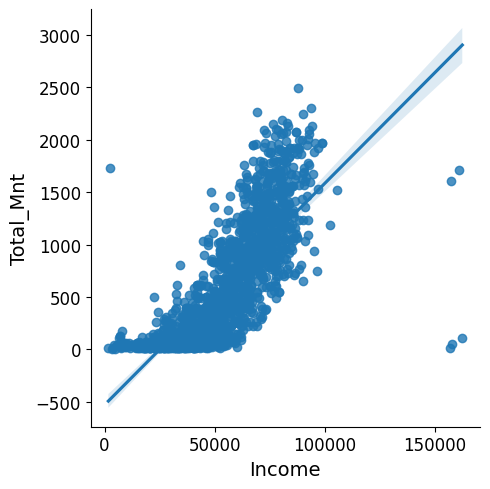

In [0]:
# Relationship between 'Total_Mnt' and 'Income_Per_Person'
save_fig('total_mnt_income_per_person_effect')
sns.lmplot(x='Income', y='Total_Mnt', data=ifood[ifood['Income_Per_Person'] < 100000])

Saving figure campaigns_income_plot


<Figure size 640x480 with 0 Axes>

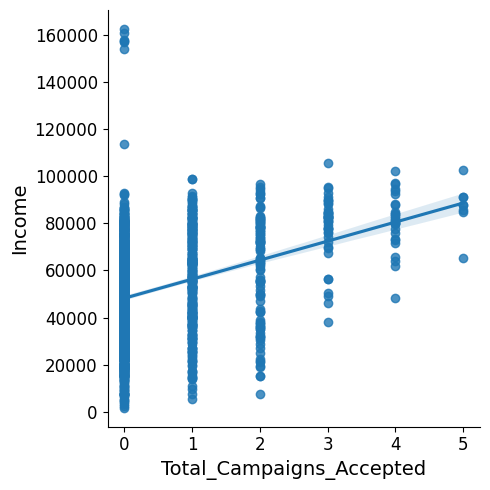

In [0]:
# Relationship between 'Total_Campaigns_Accepted' and 'Income'

save_fig('campaigns_income_plot')
sns.lmplot(x='Total_Campaigns_Accepted', y='Income', data=ifood)

Saving figure purchases_income_plot


<Figure size 640x480 with 0 Axes>

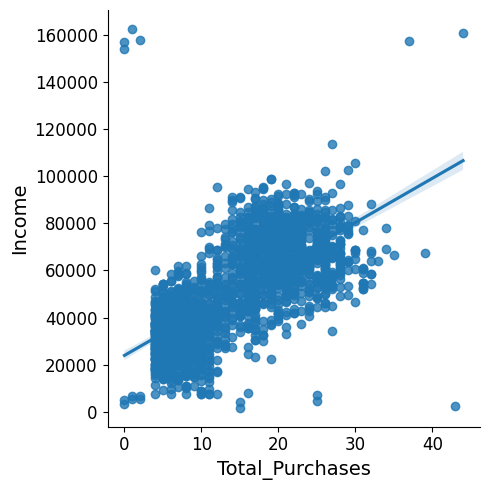

In [0]:
# Relationship between 'Total_Purchases' and 'Income'

save_fig('purchases_income_plot')
sns.lmplot(x='Total_Purchases', y='Income', data=ifood)

Saving figure income_deals_plot


<Figure size 640x480 with 0 Axes>

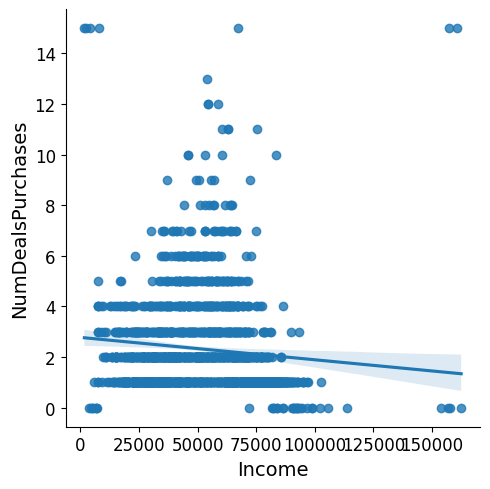

In [0]:
# Relationship between 'Income' and 'NumDealsPurchases'

save_fig('income_deals_plot')
sns.lmplot(x='Income', y='NumDealsPurchases', data=ifood)

Saving figure children_deals_plot


<Figure size 640x480 with 0 Axes>

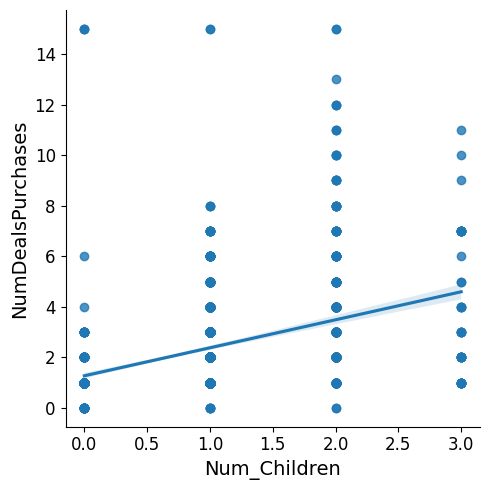

In [0]:
# Relationship between 'Num_Children' and 'NumDealsPurchases'

save_fig('children_deals_plot')
sns.lmplot(x='Num_Children', y='NumDealsPurchases', data=ifood)

Saving figure children_income_plot


<Figure size 640x480 with 0 Axes>

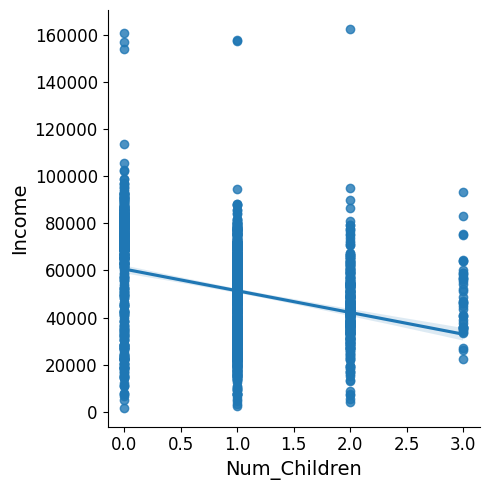

In [0]:
# Relationship between 'Num_Children' and 'Income'

save_fig('children_income_plot')
sns.lmplot(x='Num_Children', y='Income', data=ifood)

In [0]:
# Checking correlation with target

corr = ifood.corrwith(ifood["Response"])
corr = corr.reset_index(name='corr value')
corr["Corr Type"] = corr["corr value"].apply(lambda x : "Positive" if x >= 0 else "Negative")
corr["corr value"] = corr["corr value"].apply(lambda x : abs(x))
corr.sort_values('corr value', ascending=False, ignore_index=True)

index  corr value Corr Type
0                   Response    1.000000  Positive
1   Total_Campaigns_Accepted    0.727315  Positive
2               AcceptedCmp5    0.320623  Positive
3               AcceptedCmp1    0.297717  Positive
4          Income_Per_Person    0.276801  Positive
5               AcceptedCmp3    0.274044  Positive
6                  Total_Mnt    0.257591  Positive
7                   MntWines    0.242704  Positive
8            MntMeatProducts    0.226602  Positive
9        NumCatalogPurchases    0.209127  Positive
10        Num_Family_Members    0.207242  Negative
11      Time_Customer_Months    0.203762  Positive
12       Time_Customer_Years    0.203653  Positive
13                   Recency    0.200762  Negative
14              AcceptedCmp2    0.176337  Positive
15              AcceptedCmp4    0.175754  Positive
16              Num_Children    0.162596  Negative
17                  Teenhome    0.154985  Negative
18                    Income    0.150973  Positive
19           NumWebPurchases    0.147973  Positive
20                 MntFruits    0.141680  Positive
21           Total_Purchases    0.139066  Positive
22              MntGoldProds    0.125666  Positive
23           MntFishProducts    0.105854  Positive
24          MntSweetProducts    0.100482  Positive
25                   Kidhome    0.070301  Negative
26                        ID    0.037454  Negative
27         NumStorePurchases    0.020879  Positive
28                       Age    0.019325  Negative
29         NumWebVisitsMonth    0.009368  Positive
30         NumDealsPurchases    0.006070  Negative
31                  Complain    0.004962  Positive

Saving figure correlation_with_response


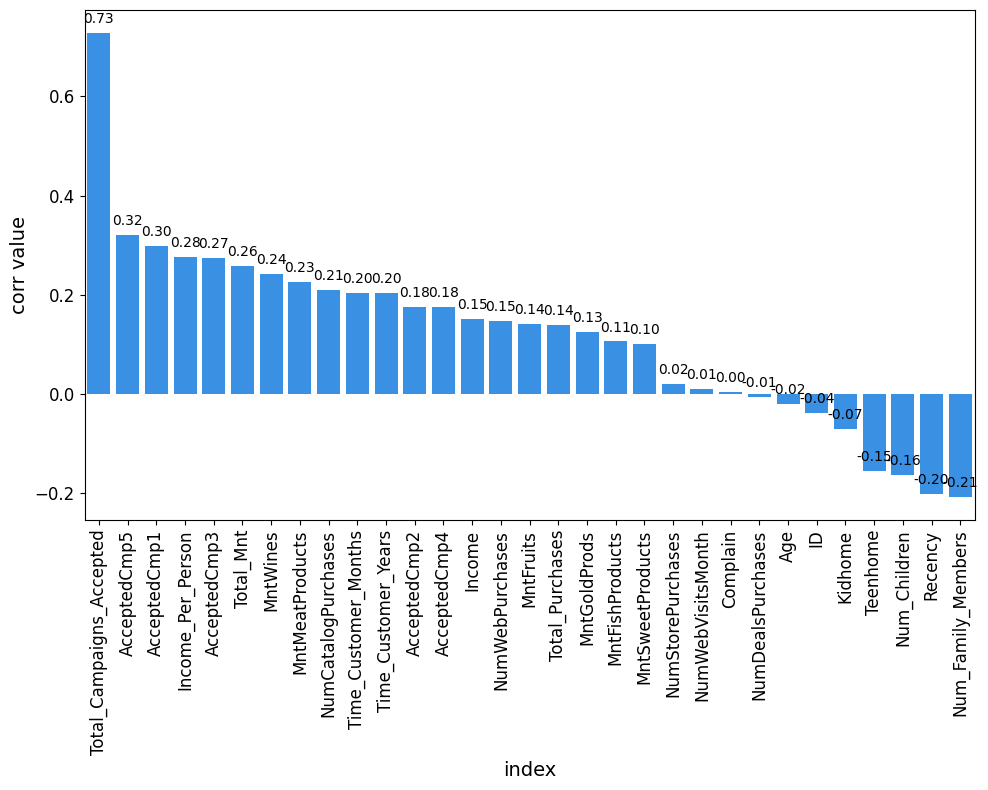

In [0]:
corr = ifood.corrwith(ifood["Response"])
corr = corr.reset_index(name='corr value')
corr = corr.sort_values('corr value', ascending=False)[1:]

plt.figure(figsize=(10, 8))
ax = sns.barplot(x='index', y="corr value", data=corr, order=corr["index"], color='dodgerblue')
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():0.2f}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', 
        va = 'center', 
        xytext = (0, 10), 
        fontsize=10,
        textcoords = 'offset points')
plt.xticks(rotation=90)
save_fig("correlation_with_response")
plt.show()

In [0]:
cat = ['Education', 'Marital_Status','Kidhome','Teenhome']

dfg_all = pd.DataFrame()

for category in cat:
    # Group data by 'Education', 'Marital_Status', 'Kidhome', and 'Teenhome' and 'Response'
    dfg1 = ifood.groupby([category, "Response"]).agg({"ID":"nunique"}).reset_index()
    dfg1.rename(columns={"ID":"Nº Customers"}, inplace=True)

    # Group data by 'Education', 'Marital_Status', 'Kidhome', and 'Teenhome'
    dfg2 = ifood.groupby([category]).agg({"ID":"nunique"}).reset_index()
    dfg2.rename(columns={"ID":"Total Customers"}, inplace=True)

    # Merge data
    dfg = dfg1.merge(dfg2, on=category)

    # Calculate ratio
    dfg["ratio"] = (dfg["Nº Customers"]/dfg["Total Customers"])*100

    # Change 1 and 0 category to Yes and No
    dfg["Response"] = dfg["Response"].apply(lambda x: "Yes" if x == 1 else "No")
    dfg["Category"] = category
    dfg.rename(columns={category: "Type"}, inplace=True)
    
    # Filter only rows with 'Response' == 'Yes'
    dfg = dfg[dfg["Response"] == "Yes"].copy()
    
    # Sort by ratio in descending order
    dfg.sort_values(by=['ratio'], ascending=False, inplace=True)
    
    # Concatenate the dataframes
    dfg_all = pd.concat([dfg_all, dfg], axis=0)

dfg_all.set_index(['Category', 'Type', 'Response'])

Nº Customers  Total Customers      ratio
Category       Type       Response                                          
Education      PhD        Yes                 76              380  20.000000
               Master     Yes                 44              301  14.617940
               Graduation Yes                120              875  13.714286
               2n Cycle   Yes                 21              159  13.207547
               Basic      Yes                  2               47   4.255319
Marital_Status Widow      Yes                 15               59  25.423729
               Single     Yes                 82              374  21.925134
               Divorced   Yes                 36              182  19.780220
               Married    Yes                 83              695  11.942446
               Together   Yes                 47              452  10.398230
Kidhome        0          Yes                172             1017  16.912488
               1          Yes                 89              708  12.570621
               2          Yes                  2               37   5.405405
Teenhome       0          Yes                187              913  20.481928
               2          Yes                  4               44   9.090909
               1          Yes                 72              805   8.944099

##### Important note:
    1. PhD, Master and Gratuation's degrees have high response rates, each with a response ratio of over 13.4% (maximum 20%).
    2. Widow, Single and Divorced statuses have high response rates.
    3. The more children/teenagers a customer has, the lower the likelihood of them responding to the marketing campaign. 

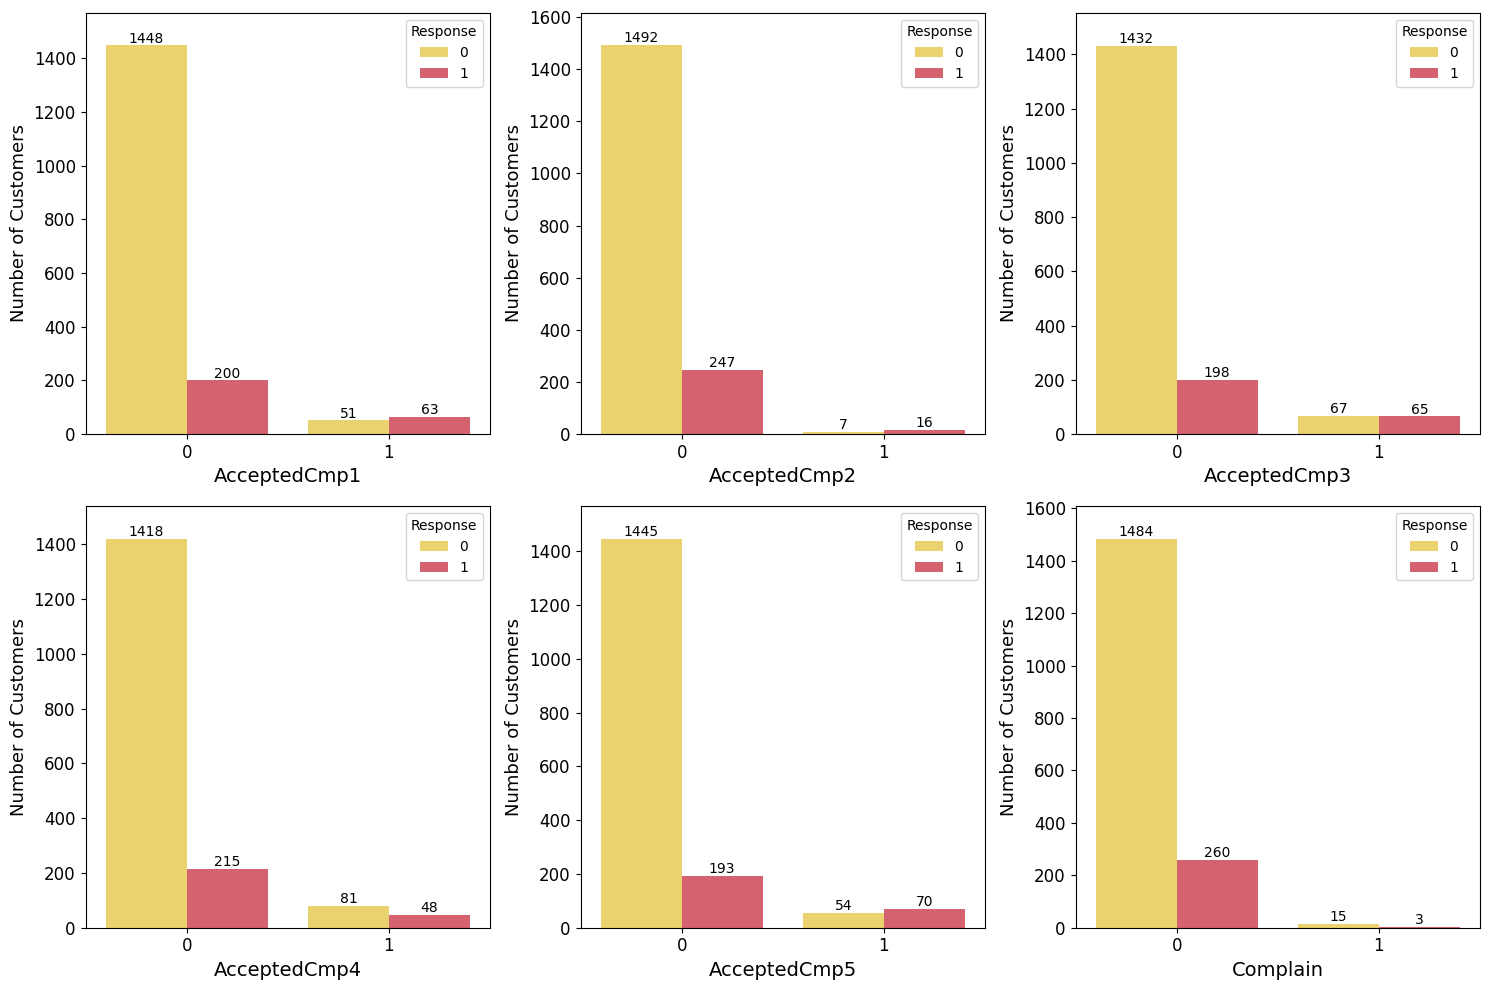

In [0]:
import math

cat = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5', 'Complain']

n=2
fig = plt.figure(figsize=(15, 10))
for i in range(0, len(cat)):
    ax = fig.add_subplot(n, math.ceil(len(cat)/n), i+1)
    bar = sns.countplot(x=ifood[cat[i]], hue=ifood["Response"], palette=ifood_colors, orient='h')
    for patch in bar.patches:
        bar.annotate(format(patch.get_height(), '.0f'),
                     (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                     ha = 'center', va = 'center', 
                     xytext = (0, 5), 
                     textcoords = 'offset points')
    sns.color_palette("YlOrBr")
    plt.xticks(rotation=0)
    y_start, y_end = ax.get_ylim()
    ax.set_ylim(0, y_end+50)
    plt.ylabel('Number of Customers',fontsize=13)
    plt.tight_layout()

##### Important note: 
   
The campaign acceptance (target) tends to be based on those who have accepted previous campaigns and have not complained.

Saving figure response_distribuition


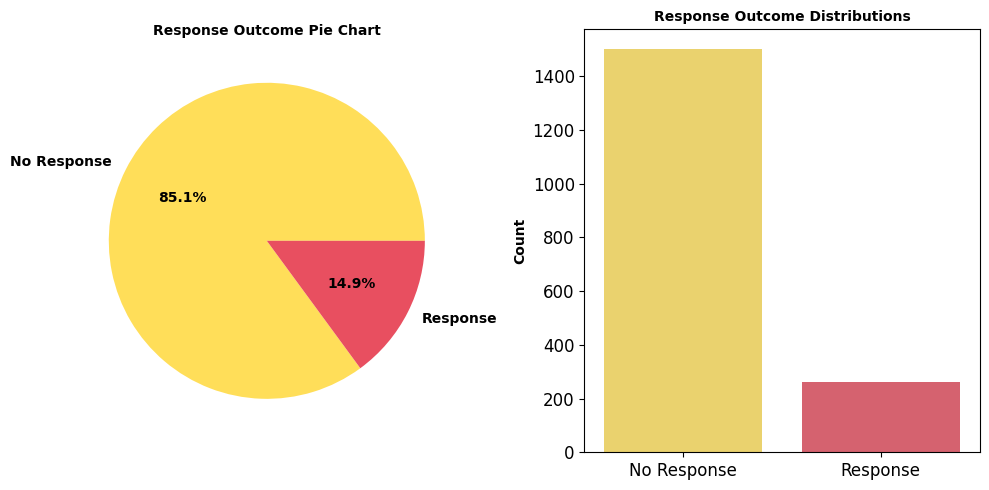

In [0]:
fig = plt.figure(figsize = (10, 5))

plt.subplot(121)
plt.pie(ifood["Response"].value_counts(),
        labels = ['No Response', 'Response'], 
        autopct = '%.1f%%', 
        radius = 1, 
        colors=ifood_colors,
        textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.title('Response Outcome Pie Chart', fontsize = 10, fontweight = 'bold')

plt.subplot(122)
resp = ifood["Response"].apply(lambda x: "No Response" if x == 0 else "Response")
t = sns.countplot(x=resp, palette=ifood_colors)
t.set_xlabel(None, fontweight = 'bold', fontsize = 10)
t.set_ylabel('Count', fontweight = 'bold', fontsize = 10)

plt.title('Response Outcome Distributions', fontsize = 10, fontweight = 'bold')
save_fig("response_distribuition")
plt.tight_layout()

In [0]:
# Acceptance of campaings

campaigns = ifood.copy()

# Membuat Acceptance Rate dari setiap campaign
camp = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'] 

for i in camp:
    campaigns[i] = campaigns[i].apply(lambda x: 1 if x == 1 else 0)

nm = []
acc_pp = []

for i, val in enumerate(camp):
    acc = (campaigns[val].astype("int64").sum()/campaigns.shape[0]) * 100
    nm.append(i+1)
    acc_pp.append(acc)

acceptance = pd.DataFrame({'Campaign': nm, 'Acceptance Percentage': acc_pp})
acceptance

Campaign  Acceptance Percentage
0         1               6.469921
1         2               1.305335
2         3               7.491487
3         4               7.321226
4         5               7.037457

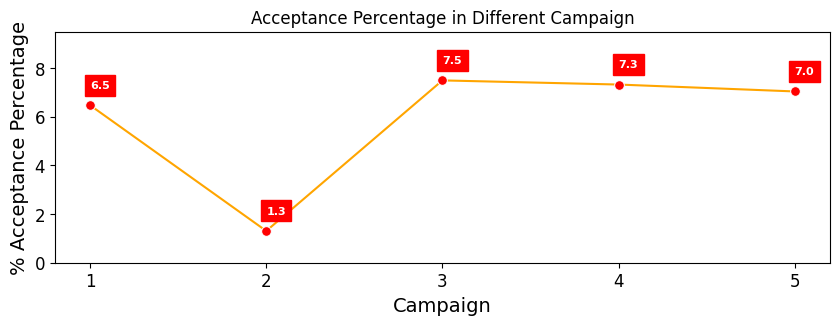

In [0]:
# Acceptance of campaigns

plt.figure(figsize=(10, 3))
line = sns.lineplot(x="Campaign", y="Acceptance Percentage", data=acceptance, 
                    marker='o', color='orange', markersize=7, markerfacecolor='red')

# label points on the plot
for x, y in zip(acceptance["Campaign"], acceptance["Acceptance Percentage"]):
    plt.text(x = x, y = y+0.7, s = "{:.1f}".format(y), color = "white", size=8, fontweight="bold").set_backgroundcolor("red")
    
# Set plot title and axes labels
plt.title('Acceptance Percentage in Different Campaign')
plt.xlabel('Campaign')
plt.ylabel('% Acceptance Percentage')
plt.ylim(0, max(acceptance["Acceptance Percentage"])+2)

plt.xticks(np.arange(1, 6, step=1))

plt.show()

Saving figure number_customers_response_age


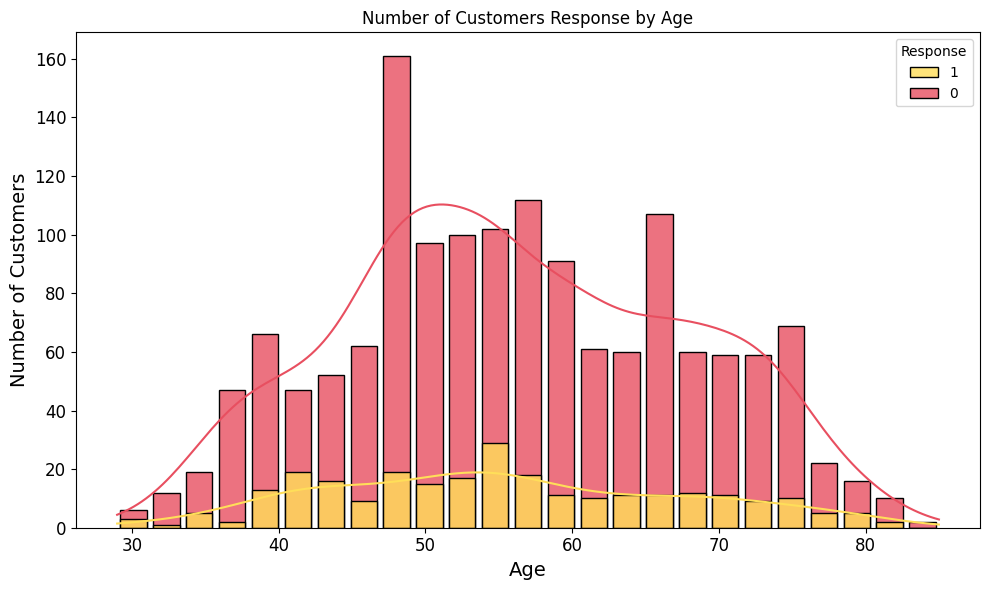

In [0]:
# Age and Response

fig, ax = plt.subplots(figsize=(10, 6))

# Ensure ifood_colors has exactly two colors
ifood_colors = ['#FFDE59', '#E84F60']

sns.histplot(data=ifood, x='Age', hue='Response', 
             palette=ifood_colors, alpha=0.8,
             kde=True, bins=25, shrink=0.8,
             hue_order=[1, 0])
ax.set_xlabel('Age')
ax.set_ylabel('Number of Customers')
ax.set_title('Number of Customers Response by Age')

plt.tight_layout()
save_fig("number_customers_response_age")
plt.show()

##### Important note:

The category of customers who received the most responses to the latest marketing campaign are those born between 1970-1975 (39-44 years old) and 1980-1990 (24-34 years old).

In [0]:
# Group data by Education-Response
dfg1 = ifood.groupby(["Education", "Response"]).agg({"ID":"nunique"}).reset_index()
dfg1.rename(columns={"ID":"Nº Customers"}, inplace=True)

# Group data by Education
dfg2 = ifood.groupby(["Education"]).agg({"ID":"nunique"}).reset_index()
dfg2.rename(columns={"ID":"Total Customers"}, inplace=True)

# Merge data
df_edu = dfg1.merge(dfg2, on="Education")

# Calculate ratio
df_edu["ratio"] = (df_edu["Nº Customers"]/df_edu["Total Customers"])*100

order = ['Basic', 'Graduation', 'Master', 'PhD']
df_edu = df_edu.set_index("Education").loc[order].reset_index()
df_edu

Education  Response  Nº Customers  Total Customers      ratio
0       Basic         0            45               47  95.744681
1       Basic         1             2               47   4.255319
2  Graduation         0           755              875  86.285714
3  Graduation         1           120              875  13.714286
4      Master         0           257              301  85.382060
5      Master         1            44              301  14.617940
6         PhD         0           304              380  80.000000
7         PhD         1            76              380  20.000000

Saving figure response_education_comparison


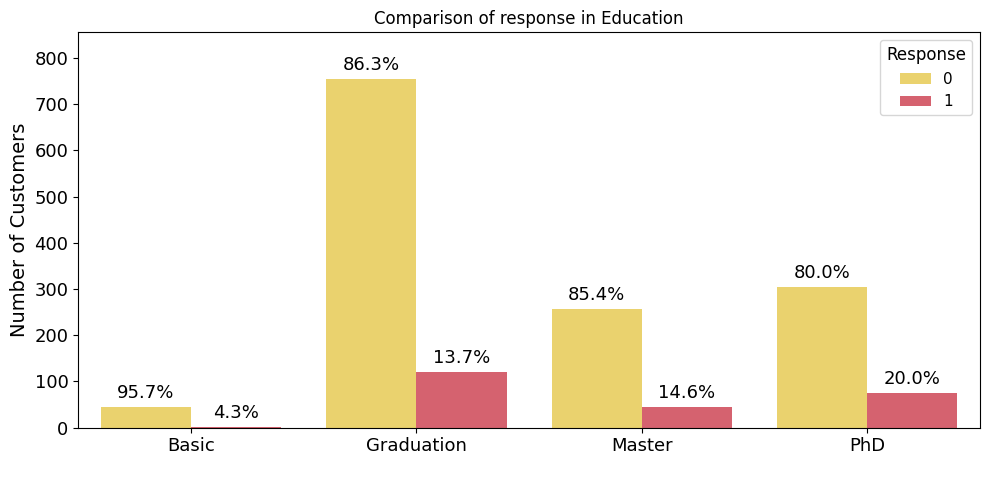

In [0]:
# Education and Response

plt.figure(figsize=(10, 5))

ax = sns.barplot(x="Education", y="Nº Customers", 
                 data=df_edu, hue="Response",
                 palette=ifood_colors)

# Set values label annotation
for p in ax.patches:
    ncus = df_edu[df_edu["Nº Customers"] == p.get_height()]["ratio"].values[0]
    ax.annotate(
        '{:.1f}%'.format(ncus), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), 
        fontsize=13,
        textcoords='offset points')

# Set title
plt.ylabel('Number of Customers', fontsize=14)
plt.xlabel(' ', fontsize=14)
plt.title("Comparison of response in Education")

# Setting ticks
plt.tick_params(axis='both', which='major', labelsize=13)

# Settings legend
lg = plt.legend(title="Response", prop={"size": 11})
title = lg.get_title()
title.set_fontsize(12)
plt.ylim(0, max(df_edu["Nº Customers"])+100)

plt.tight_layout()
save_fig("response_education_comparison")
plt.show()

In [0]:
# Group data by Marital_Status-Response
dfg1 = ifood.groupby(["Marital_Status", "Response"]).agg({"ID":"nunique"}).reset_index()
dfg1.rename(columns={"ID":"Nº Customers"}, inplace=True)

# Group data by Marital_Status_Simple
dfg2 = ifood.groupby(["Marital_Status"]).agg({"ID":"nunique"}).reset_index()
dfg2.rename(columns={"ID":"Total Customers"}, inplace=True)

# Merge data
df_mar = dfg1.merge(dfg2, on="Marital_Status")

# Calculate ratio
df_mar["ratio"] = (df_mar["Nº Customers"]/df_mar["Total Customers"])*100

order = ['Together', 'Married', 'Divorced', 'Widow', 'Single']
df_mar = df_mar.set_index("Marital_Status").loc[order].reset_index()
df_mar


Marital_Status  Response  Nº Customers  Total Customers      ratio
0       Together         0           405              452  89.601770
1       Together         1            47              452  10.398230
2        Married         0           612              695  88.057554
3        Married         1            83              695  11.942446
4       Divorced         0           146              182  80.219780
5       Divorced         1            36              182  19.780220
6          Widow         0            44               59  74.576271
7          Widow         1            15               59  25.423729
8         Single         0           292              374  78.074866
9         Single         1            82              374  21.925134

Saving figure response_marital_status


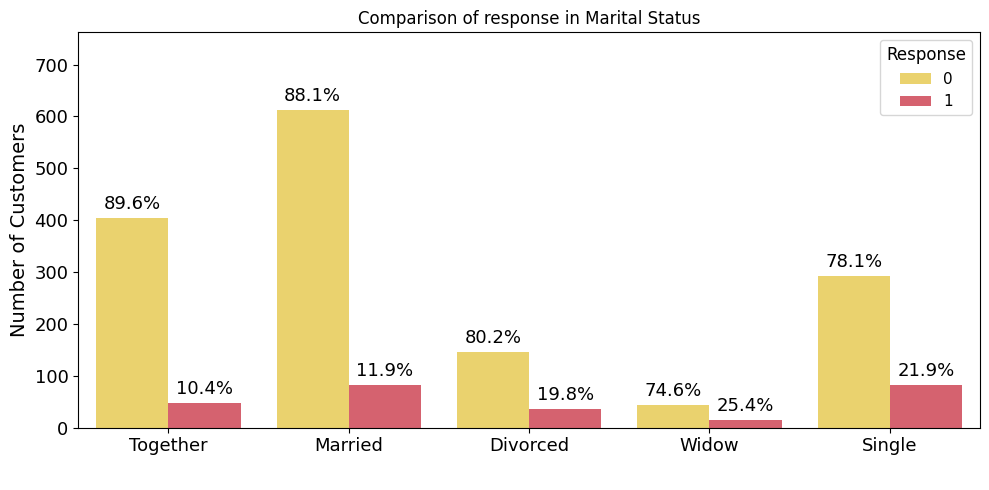

In [0]:
# Marital Status and Response

plt.figure(figsize=(10, 5))

ax = sns.barplot(x="Marital_Status", y="Nº Customers", 
                 data=df_mar, hue="Response",
                 palette=ifood_colors, order=order)

# Set values label annotation
for p in ax.patches:
    ncus = df_mar[df_mar["Nº Customers"] == p.get_height()]["ratio"].values[0]
    ax.annotate(
        '{:.1f}%'.format(ncus), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), 
        fontsize=13,
        textcoords='offset points')

# Set title
plt.ylabel('Number of Customers', fontsize=14)
plt.xlabel(' ', fontsize=14)
plt.title("Comparison of response in Marital Status")

# Setting ticks
plt.tick_params(axis='both', which='major', labelsize=13)

# Settings legend
lg = plt.legend(title="Response", prop={"size": 11})
title = lg.get_title()
title.set_fontsize(12)
plt.ylim(0, max(df_mar["Nº Customers"])+150)

plt.tight_layout()
save_fig("response_marital_status")
plt.show()

Saving figure customers_children_response


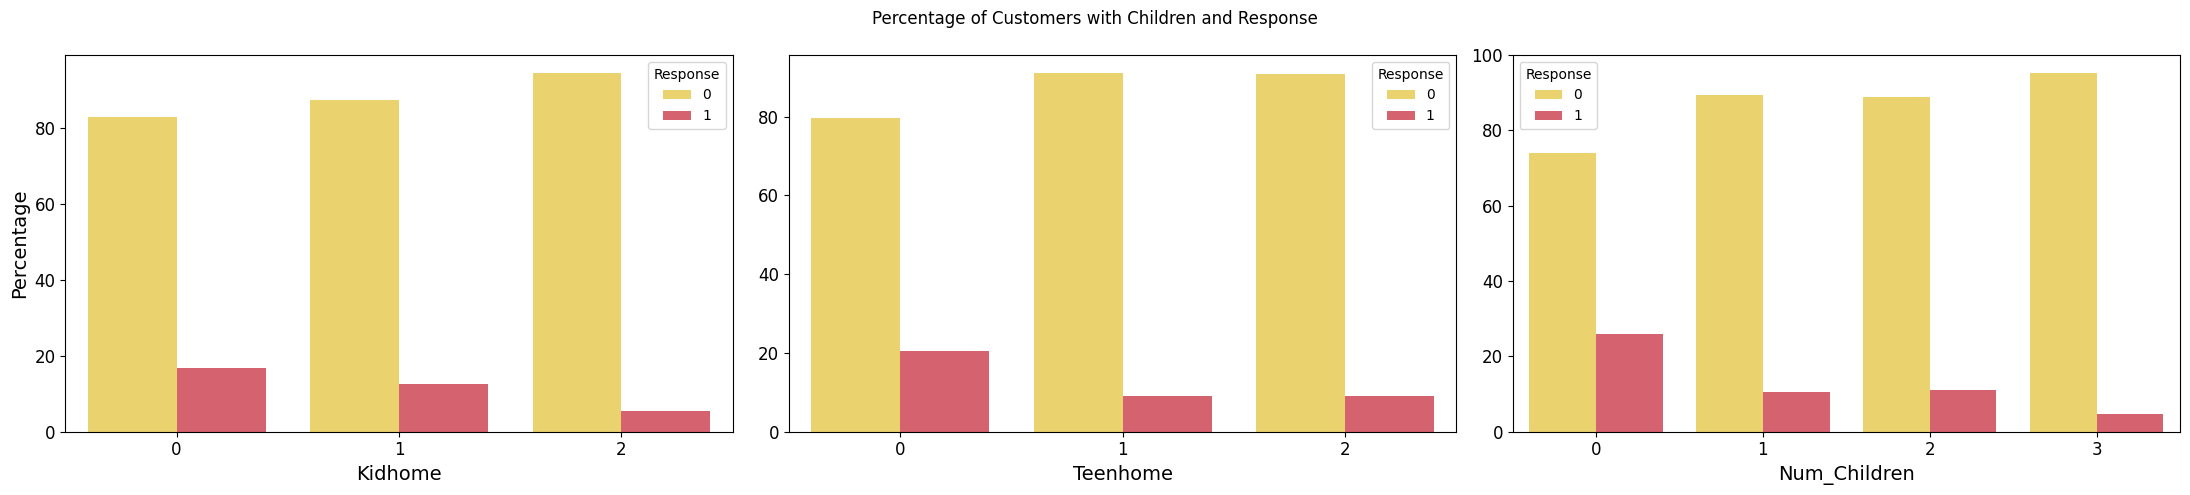

In [0]:
# Num of Children and Response

children = ['Kidhome', 'Teenhome', 'Num_Children']

fig = plt.figure(figsize=(22, 5))

for idx, i in enumerate(children):
    ax = fig.add_subplot(1, 3, idx+1)
    df_temp = ifood.groupby([i, 'Response'])['ID'].count().reset_index()
    df_temp_2 = ifood.groupby([i])['ID'].count().reset_index()
    df_merge = df_temp.merge(df_temp_2, on=i, how='inner')
    df_merge.columns = [i, 'Response', 'CountCust', 'TotalCust']
    df_merge['Percentage'] = df_merge['CountCust'] / df_merge['TotalCust'] * 100
    
    sns.barplot(x=i, y='Percentage', data=df_merge, hue='Response', palette=ifood_colors)
    if idx != 0:
        ax.set_ylabel(None)

plt.tight_layout()
fig.suptitle("Percentage of Customers with Children and Response")
save_fig("customers_children_response")
plt.show()

Saving figure recency_response


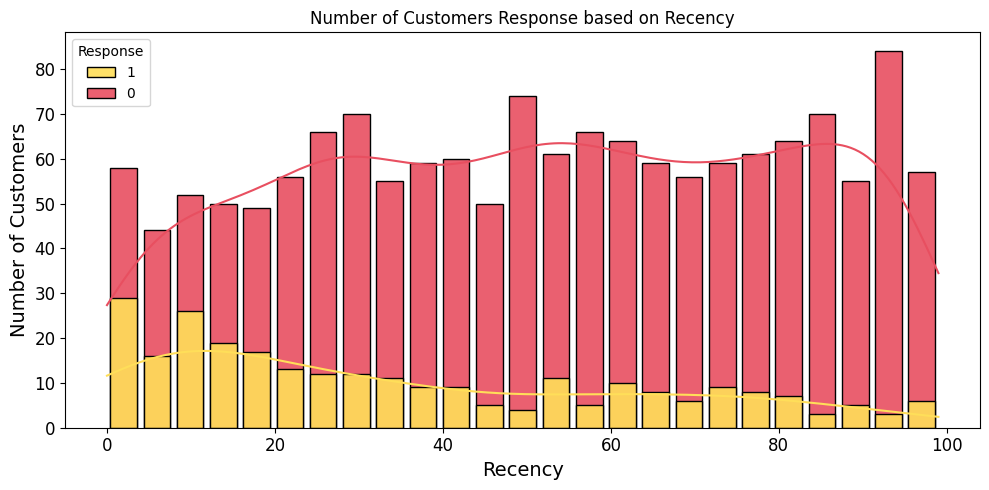

In [0]:
# Recency and Response

fig = plt.figure(figsize = (10, 5))

ax = sns.histplot(data=ifood, x='Recency', hue='Response', 
             palette=ifood_colors, alpha=0.9,
             kde = True, 
             bins = 25, shrink = 0.8,
            hue_order=[1,0])
plt.xlabel('Recency')
plt.ylabel('Number of Customers')
plt.title('Number of Customers Response based on Recency')

plt.tight_layout()
save_fig("recency_response")
plt.show()

##### Important note:

Based on recency (the time since the customer's last purchase), the lower the recency, the greater the likelihood that the customer will respond positively to the company's latest marketing campaign (Response). 

Saving figure response_income_per_person


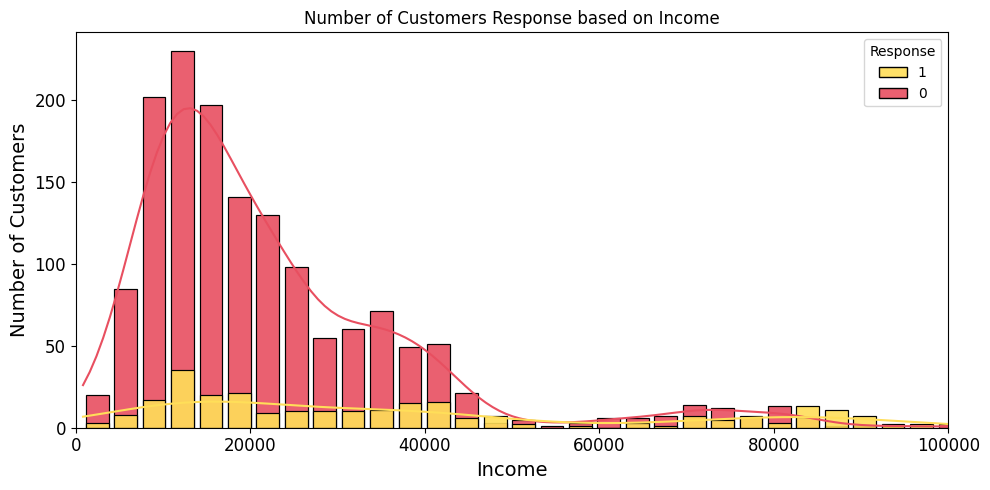

In [0]:
#  Response and Income per person

fig = plt.figure(figsize = (10, 5))

ax = sns.histplot(data=ifood, x='Income_Per_Person', hue='Response', 
             palette=ifood_colors, alpha=0.9,
             kde = True, shrink = 0.8,
            hue_order=[1,0])
plt.xlabel('Income')
plt.ylabel('Number of Customers')
plt.title('Number of Customers Response based on Income')

plt.xlim(0, 100000)

plt.tight_layout()
save_fig("response_income_per_person")
plt.show()

Saving figure purchase_response


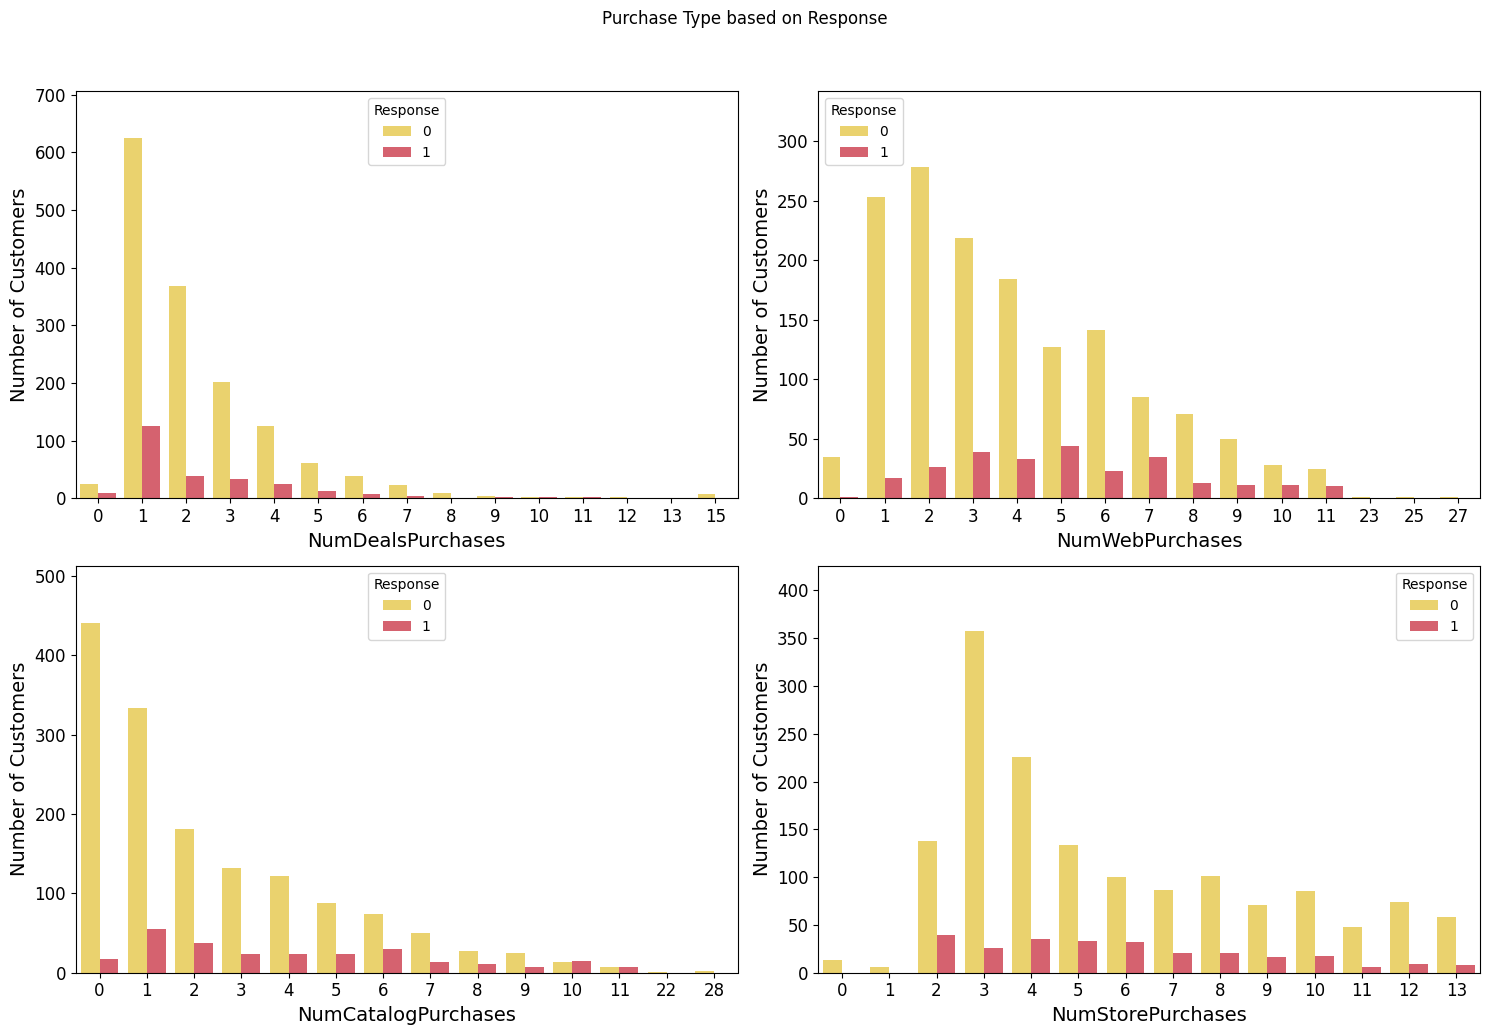

In [0]:
purchase_type = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

n=2
fig = plt.figure(figsize=(15, 10))
for i in range(0, len(purchase_type)):
    fig.add_subplot(n, math.ceil(len(purchase_type)/n), i+1)
    bar = sns.countplot(x=ifood[purchase_type[i]], hue=ifood["Response"], palette=ifood_colors, orient='h')

    y_start, y_end = plt.ylim()
    plt.ylim(0, y_end+50)
    plt.ylabel('Number of Customers')
    plt.tight_layout()
    
fig.suptitle("Purchase Type based on Response", y=1.03)
save_fig("purchase_response")

Saving figure income_total_amount_response


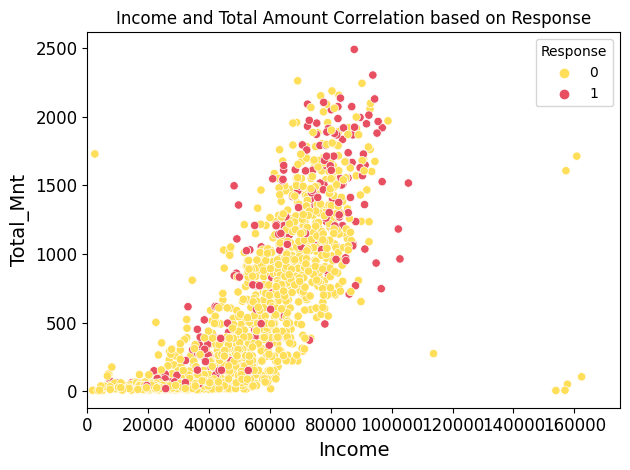

In [0]:
# Response and Total_Mnt

sns.scatterplot(x="Income",y='Total_Mnt', hue = 'Response', data=ifood, palette=ifood_colors)
plt.title("Income and Total Amount Correlation based on Response")
plt.xlim(0, 175000)
save_fig("income_total_amount_response")

Income and spending have a positive correlation with response, where higher income and spending values correspond to higher response rates

Saving figure mnt_purchase_response_boxplot


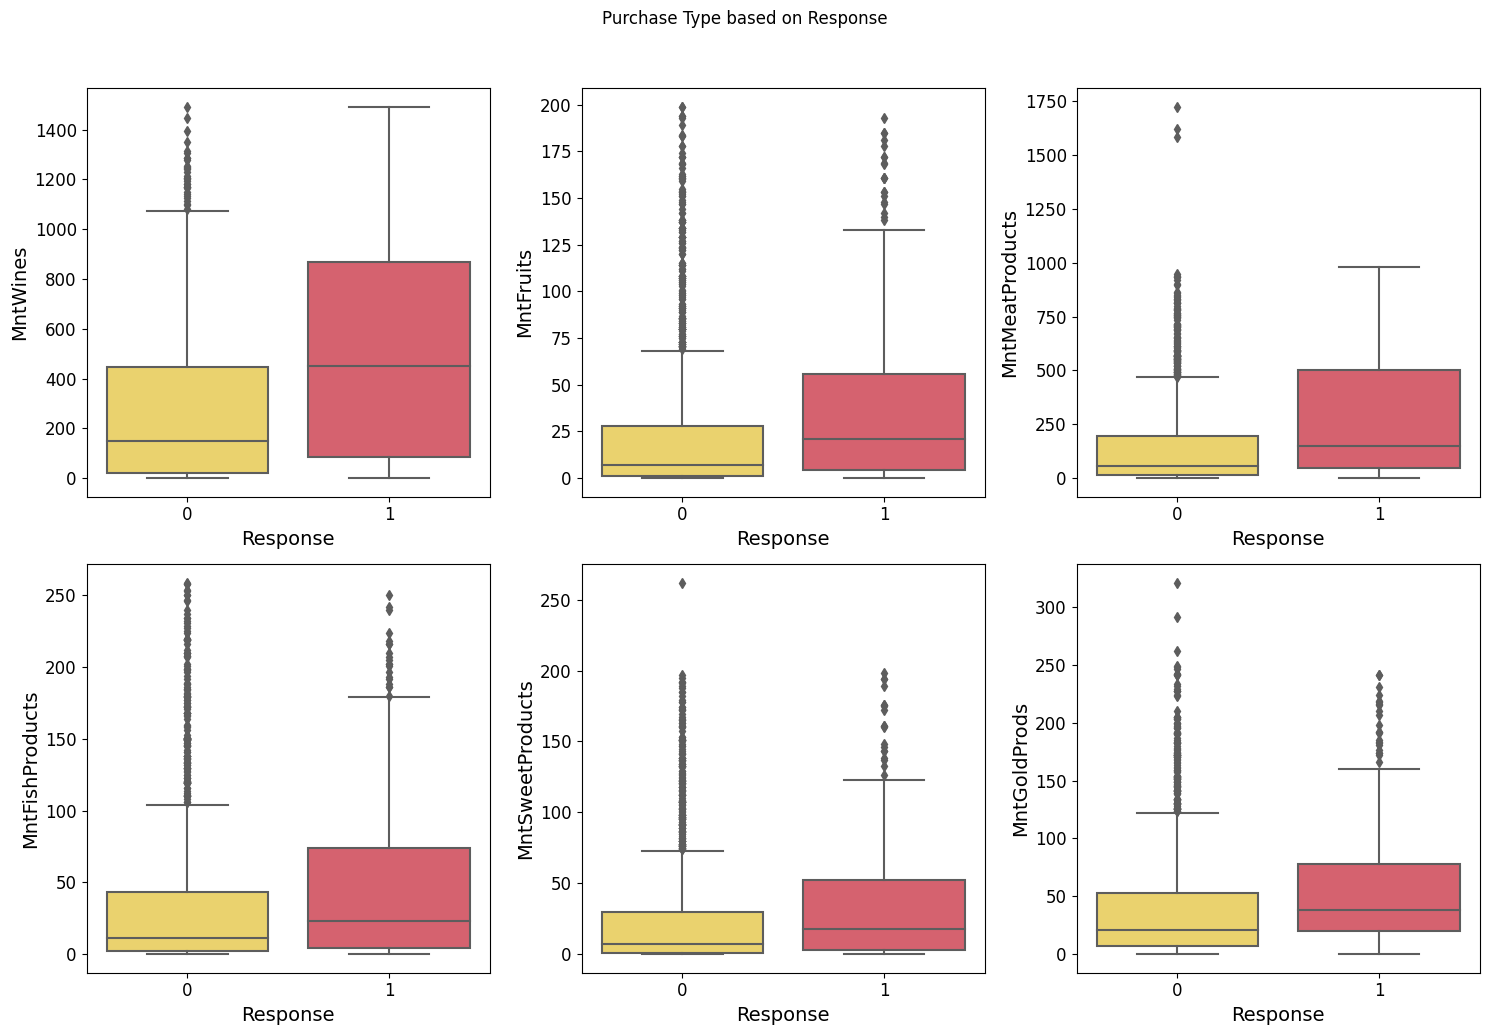

In [0]:
mnt_type = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

n = 2
fig = plt.figure(figsize=(15, 10))
for i in range(0, len(mnt_type)):
    fig.add_subplot(n, math.ceil(len(mnt_type)/n), i+1)
    box = sns.boxplot(x=ifood["Response"], y=ifood[mnt_type[i]], palette=ifood_colors)

    plt.ylabel(mnt_type[i])
    plt.tight_layout()
    
fig.suptitle("Purchase Type based on Response", y=1.03)
save_fig("mnt_purchase_response_boxplot")

In [0]:
categ_cols = ['Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 
              'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain']
              
numeric_cols = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 
                'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Time_Customer_Months', 
                'Time_Customer_Years', 'Age', 'Total_Mnt', 'Total_Purchases', 'Total_Campaigns_Accepted',
                'Income_Per_Person', 'Num_Children', 'Num_Family_Members']

In [0]:
from scipy.stats import kruskal

# Kruskal-Wallis test between response
for col in numeric_cols:
    groups = [ifood.loc[ifood['Response'] == response, col] for response in ifood['Response'].unique()]
    kw_results = kruskal(*groups)
    print("Kruskal-Wallis Test for", col)
    print("H-statistic:", kw_results.statistic)
    print("p-value:", kw_results.pvalue)
    print()

Kruskal-Wallis Test for Income
H-statistic: 41.16998242092995
p-value: 1.3954927691084235e-10

Kruskal-Wallis Test for Kidhome
H-statistic: 8.158104834609194
p-value: 0.004286914486359607

Kruskal-Wallis Test for Teenhome
H-statistic: 44.9874827240623
p-value: 1.982979544974306e-11

Kruskal-Wallis Test for Recency
H-statistic: 71.31345357947157
p-value: 3.047507198743469e-17

Kruskal-Wallis Test for MntWines
H-statistic: 63.100828604965095
p-value: 1.963914726139717e-15

Kruskal-Wallis Test for MntFruits
H-statistic: 49.961363835615266
p-value: 1.5680331307973504e-12

Kruskal-Wallis Test for MntMeatProducts
H-statistic: 78.6226185747593
p-value: 7.518363943102825e-19

Kruskal-Wallis Test for MntFishProducts
H-statistic: 19.286156016200223
p-value: 1.1251924142454603e-05

Kruskal-Wallis Test for MntSweetProducts
H-statistic: 25.672990748421448
p-value: 4.0444816650843207e-07

Kruskal-Wallis Test for MntGoldProds
H-statistic: 52.30007396601824
p-value: 4.763565216566177e-13

Kruskal-Wall

Categories with significant differences are: Income, Kidhome, Teenhome, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumWebPurchases, NumCatalogPurchases, Time_Customer_Months, Time_Customer_Years, Total_Mnt, Total_Purchases, Total_Campaigns_Accepted, Income_Per_Person, Num_Children, Num_Family_Members.

In [0]:
from scipy.stats import chi2_contingency

# Substitua 'response_column' pelo nome da sua coluna de resposta binária
response_column = 'Response'

# Loop através das colunas binárias
for col in categ_cols:
    # Crie uma tabela de contingência entre a coluna binária e a variável de resposta
    observed = pd.crosstab(ifood[col], ifood[response_column])
    
    # Execute o teste de qui-quadrado
    chi2, p, dof, expected = chi2_contingency(observed)
    
    # Exiba os resultados
    print(f'Chi-square test for {col} vs {response_column}:')
    print(f'Chi-square statistic: {chi2}')
    print(f'P-value: {p}')
    print('\n')

Chi-square test for Education vs Response:
Chi-square statistic: 13.322797027870248
P-value: 0.009801655556600843


Chi-square test for Marital_Status vs Response:
Chi-square statistic: 35.09514967343934
P-value: 4.4409124326497045e-07


Chi-square test for AcceptedCmp3 vs Response:
Chi-square statistic: 129.4208374644444
P-value: 5.4861412198321974e-30


Chi-square test for AcceptedCmp4 vs Response:
Chi-square statistic: 52.55003436510352
P-value: 4.194254093698611e-13


Chi-square test for AcceptedCmp5 vs Response:
Chi-square statistic: 177.63154828865976
P-value: 1.5942923691237924e-40


Chi-square test for AcceptedCmp1 vs Response:
Chi-square statistic: 152.79799475422757
P-value: 4.2405387909647395e-35


Chi-square test for AcceptedCmp2 vs Response:
Chi-square statistic: 50.51604394113474
P-value: 1.1819458662991877e-12


Chi-square test for Complain vs Response:
Chi-square statistic: 0.0
P-value: 1.0




Significant differences were found in the following categories: Education, Marital_Status, AccpetedCmp (all of them)

________________________________________________________________________________________________________________________________

## 1.5 Preprocessing for modeling

In [0]:
ifood_pr = ifood.drop('Response', axis=1) # drop labels (target) for training set
ifood_label = ifood['Response'].copy()

### 1.5.1 Dealing with categorical columns

In [0]:
# Creating new binary columns for each education category, considering the hierarchy
def apply_education_logic(df):
    df['Education_Basic'] = df['Education'].apply(lambda x: 1 if x in ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD'] else 0)
    df['Education_2n_Cycle'] = df['Education'].apply(lambda x: 1 if x in ['2n Cycle', 'Graduation', 'Master', 'PhD'] else 0)
    df['Education_Graduation'] = df['Education'].apply(lambda x: 1 if x in ['Graduation', 'Master', 'PhD'] else 0)
    df['Education_Master'] = df['Education'].apply(lambda x: 1 if x in ['Master', 'PhD'] else 0)
    df['Education_PhD'] = df['Education'].apply(lambda x: 1 if x == 'PhD' else 0)

apply_education_logic(ifood_pr)

# Checking the result
ifood_pr[['Education', 'Education_Basic', 'Education_2n_Cycle', 'Education_Graduation', 'Education_Master', 'Education_PhD']].head()

Education  Education_Basic  ...  Education_Master  Education_PhD
1090       PhD                1  ...                 1              1
15         PhD                1  ...                 1              1
873   2n Cycle                1  ...                 0              0
610     Master                1  ...                 1              0
657   2n Cycle                1  ...                 0              0

[5 rows x 6 columns]

In [0]:
from sklearn.preprocessing import OneHotEncoder

ifood_pr = pd.get_dummies(ifood_pr, columns=['Marital_Status'], prefix=['Marital_Status'])
ifood_pr

ID   Education  ...  Marital_Status_Together  Marital_Status_Widow
1090   1127         PhD  ...                        0                     0
15     2114         PhD  ...                        0                     0
873     738    2n Cycle  ...                        0                     0
610    7930      Master  ...                        0                     0
657     946    2n Cycle  ...                        1                     0
...     ...         ...  ...                      ...                   ...
252   10089  Graduation  ...                        0                     0
1128   8977       Basic  ...                        0                     0
1223    938  Graduation  ...                        0                     0
648    4679      Master  ...                        0                     0
952    5320      Master  ...                        0                     0

[1762 rows x 42 columns]

In [0]:
ifood_pr.drop(columns=['ID', 'Education'], inplace=True)

### 1.5.2 Standardization

In [0]:
from sklearn.preprocessing import StandardScaler

# Select the columns to normalize
columns_to_normalize = numeric_cols

# Normalize only the selected columns
scaled_features = StandardScaler().fit_transform(ifood_pr[columns_to_normalize])

# Remove the numeric columns from 'ifood_pr'
ifood_pr.drop(columns_to_normalize, axis=1, inplace=True)

# Create a DataFrame with the normalized data
scaled_features_ifood = pd.DataFrame(scaled_features, index=ifood_pr.index, columns=columns_to_normalize)

# Concatenate the normalized DataFrames with the original 'ifood_pr' DataFrame
ifood_pr = pd.concat([ifood_pr, scaled_features_ifood], axis=1)

ifood_pr

AcceptedCmp3  AcceptedCmp4  ...  Num_Children  Num_Family_Members
1090             0             0  ...     -1.260159           -0.662176
15               0             0  ...     -1.260159           -1.762888
873              0             0  ...      1.391065            0.438536
610              0             0  ...     -1.260159           -1.762888
657              0             0  ...     -1.260159           -0.662176
...            ...           ...  ...           ...                 ...
252              0             1  ...     -1.260159           -1.762888
1128             0             0  ...     -1.260159           -1.762888
1223             1             0  ...      1.391065            1.539247
648              0             0  ...      0.065453            0.438536
952              0             0  ...      1.391065            0.438536

[1762 rows x 40 columns]

In [0]:
# Removing the 'Time_Customer_Years' variable because there is another variable for time as a customer.

ifood_pr.drop(columns=['Time_Customer_Years'], inplace=True)

### 1.5.3 Selecting variables (PCA)

In [0]:
from sklearn.decomposition import PCA

# Convert the data to a numpy array
X = np.array(ifood_pr)

# Calculate the covariance matrix
S = np.cov(X.T)

# Variances
variances = np.diagonal(S)

# Initialize and fit the PCA model
pca = PCA(n_components=10)
pca.fit(X)

# Get the weights of the principal components
principal_components = pca.components_[0]

# Variance of the principal components
pca.explained_variance_ratio_

# Print the variances
print("Variances:")
print(variances)

# Print the weights of the principal components
print("\nWeights of the principal components:")
print(principal_components)

# Print the variance of the principal components
print("\nVariance of the principal components:")
print(np.round(pca.explained_variance_ratio_,2))

Variances:
[0.06934199 0.06789075 0.06545914 0.06054758 0.01289027 0.01011705
 0.         0.02597746 0.10330267 0.23725072 0.1692491  0.09267513
 0.23899233 0.16729995 0.19082904 0.03238183 1.00056786 1.00056786
 1.00056786 1.00056786 1.00056786 1.00056786 1.00056786 1.00056786
 1.00056786 1.00056786 1.00056786 1.00056786 1.00056786 1.00056786
 1.00056786 1.00056786 1.00056786 1.00056786 1.00056786 1.00056786
 1.00056786 1.00056786 1.00056786]

Weights of the principal components:
[ 3.83457395e-03  1.85219720e-02  3.61705317e-02  3.06746392e-02
  5.41046022e-03 -8.85955410e-04 -1.65265158e-22  7.32511451e-03
  7.64370895e-03  2.10951662e-05  3.69092256e-03  1.56540529e-03
 -9.39273388e-03  6.47806491e-03 -3.81989288e-03  5.16915656e-03
  2.72984557e-01 -2.29845821e-01 -6.41736326e-02  3.74157131e-03
  2.55616973e-01  2.22703569e-01  2.69359320e-01  2.32849410e-01
  2.21304824e-01  1.80724220e-01 -4.86524293e-02  1.81543839e-01
  2.71008459e-01  2.40362219e-01 -2.03655621e-01  3.5161009

In [0]:
# Select components with eigenvalues >= 1
selected_components = pca.explained_variance_[pca.explained_variance_ >= 1]

# Print the selected components
print("Selected components with eigenvalues >= 1:", selected_components)

Selected components with eigenvalues >= 1: [9.14614244 3.02703655 1.5689581  1.25025721 1.15726681 1.00524929]


Saving figure scree_plot


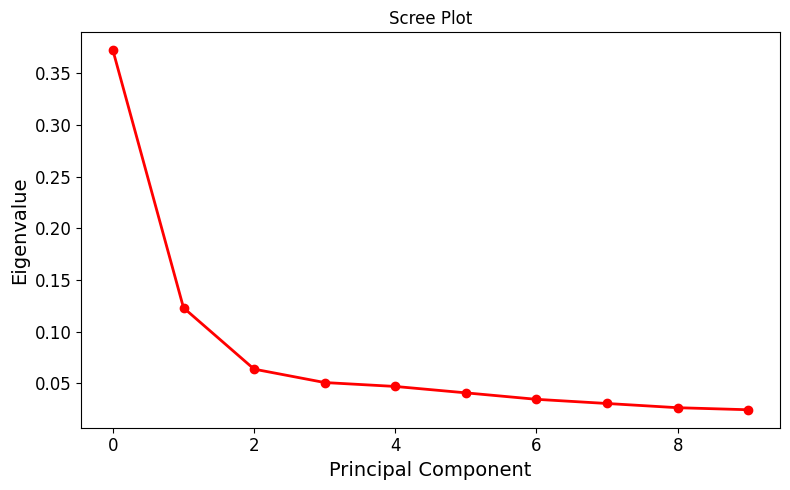

In [0]:
fig = plt.figure(figsize=(8,5))

plt.plot(pca.explained_variance_ratio_,  'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
save_fig("scree_plot")
plt.show()

Let's select 6 principal components because of the eigenvalue. 69% of explained variance.

In [0]:
from sklearn.decomposition import PCA

# Create an instance of PCA with the desired number of components and the svd_solver solver
pcanew = PCA(n_components=6, svd_solver='full')

# Fit PCA to your original data (ifood_pr)
pcanew.fit(ifood_pr)

# Create a DataFrame of the loadings of the principal components
loadings = pd.DataFrame(pcanew.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=ifood_pr.columns)

# Select the loadings that are greater than 0.3 or less than -0.3
selected_loadings = loadings[(loadings > 0.3) | (loadings < -0.3)]

# Display the selected loadings
print(selected_loadings)

                               PC1       PC2  ...       PC5       PC6
AcceptedCmp3                   NaN       NaN  ...       NaN       NaN
AcceptedCmp4                   NaN       NaN  ...       NaN       NaN
AcceptedCmp5                   NaN       NaN  ...       NaN       NaN
AcceptedCmp1                   NaN       NaN  ...       NaN       NaN
AcceptedCmp2                   NaN       NaN  ...       NaN       NaN
Complain                       NaN       NaN  ...       NaN       NaN
Education_Basic                NaN       NaN  ...       NaN       NaN
Education_2n_Cycle             NaN       NaN  ...       NaN       NaN
Education_Graduation           NaN       NaN  ...       NaN       NaN
Education_Master               NaN       NaN  ...       NaN       NaN
Education_PhD                  NaN       NaN  ...       NaN       NaN
Marital_Status_Divorced        NaN       NaN  ...       NaN       NaN
Marital_Status_Married         NaN       NaN  ...       NaN       NaN
Marital_Status_Singl

##### PCA SUMMARY: 

- PC1: Total_Mnt (Total expenses)
- PC2: Teenhome, NumDealsPurchases, Num_Purchases, Num_Children, Num_Family_Members (Presence of teenagers, number of deals and purchases, and family size)
- PC3: Time_Customer_Months, NumWebVisitsMonth, Age, Teenhome (Time as customers, number of web visits per month, age, and presence of teenagers)
- PC4: MntWines, MntFruits, MntFishProducts, MntSweetProducts, Total_Campaigns_Accepted (Spending on various product categories and acceptance of campaigns)
- PC5: Kidhome, Total_Campaigns_Accepted, Age, Num_Family_Members (Presence of kids, acceptance of campaigns, age, and family size)
- PC6: Recency (Recency of purchases)

________________________________________________________________________________________________________________________________

## 1.6 Clustering

### 1.6.1 Finding the ideal number of clusters

In [0]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

# Apply dimensionality reduction
pca = PCA(n_components=6).fit_transform(ifood_pr)

# Determining a range of K
k_range = range(1, 12)

# Applying the K-Means model for each value of K
k_means_var = [KMeans(n_clusters=k).fit(pca) for k in k_range]

# Fitting the cluster centroid for each model
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculating the Euclidean distance from each data point to the centroid
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]

# Sum of squares of distances within the cluster
intra_cluster_sum_of_squares = [sum(d**2) for d in dist]

# Total sum of squares
total_sum_of_squares = sum(pdist(pca)**2) / pca.shape[0]

# Sum of squares between clusters
inter_cluster_sum_of_squares = total_sum_of_squares - intra_cluster_sum_of_squares

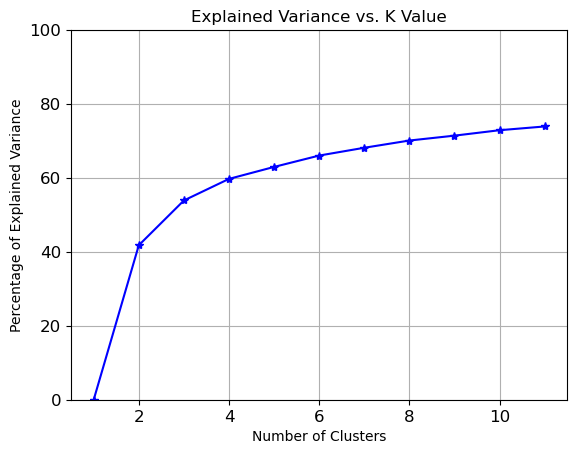

In [0]:
# Elbow Curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, inter_cluster_sum_of_squares / total_sum_of_squares * 100, 'b*-')
ax.set_ylim((0, 100))
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Percentage of Explained Variance')
plt.title('Explained Variance vs. K Value')
plt.show()

Saving figure elbow_wcss


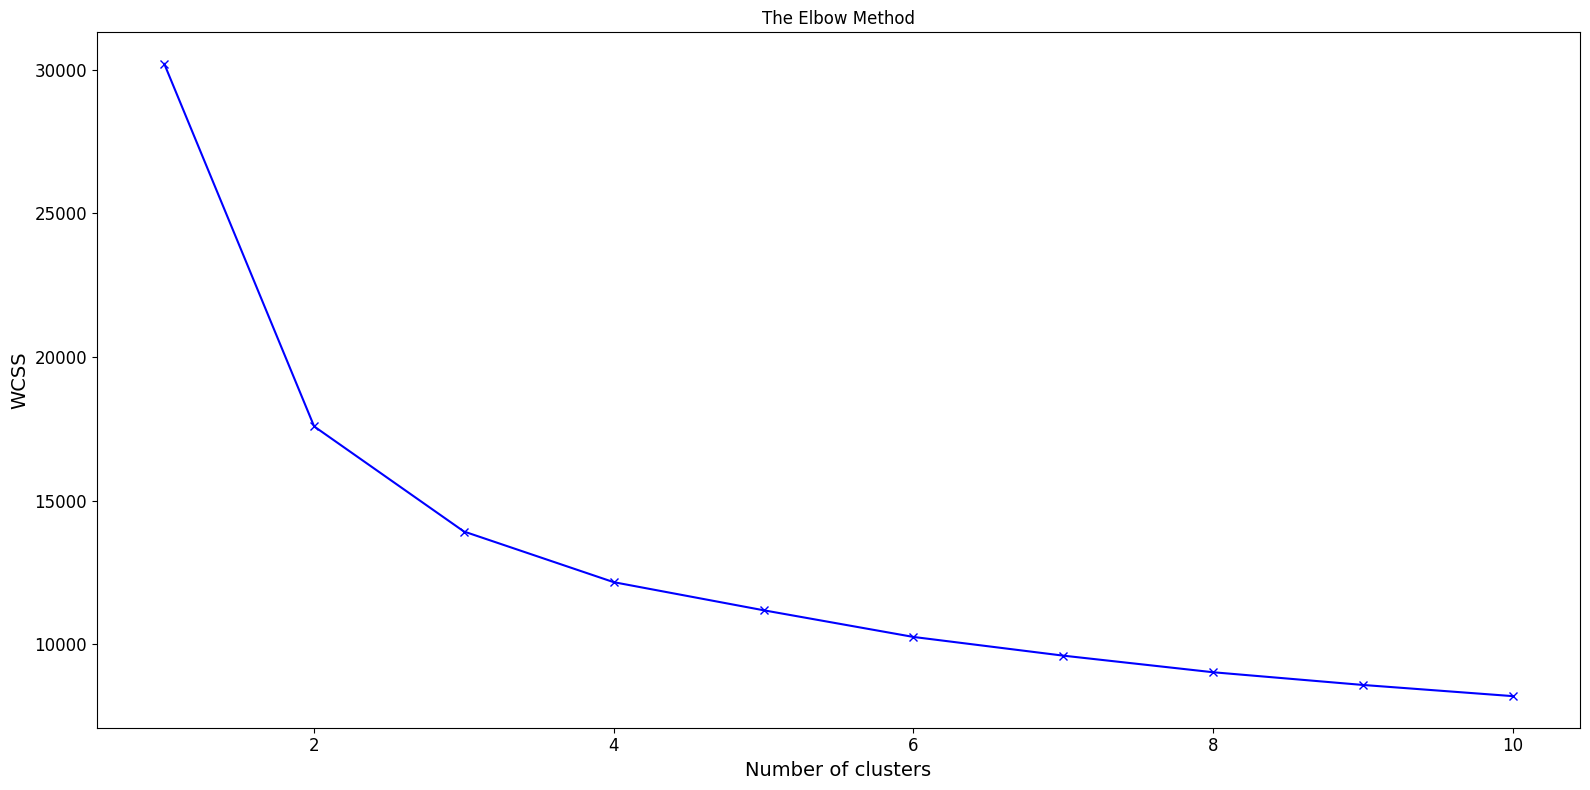

In [0]:
wcss=[]
for i in range (1,11):
 kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
 kmeans.fit(pca)
 wcss.append(kmeans.inertia_)
plt.figure(figsize=(16,8))
plt.plot(range(1,11),wcss, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
save_fig("elbow_wcss")
plt.show()

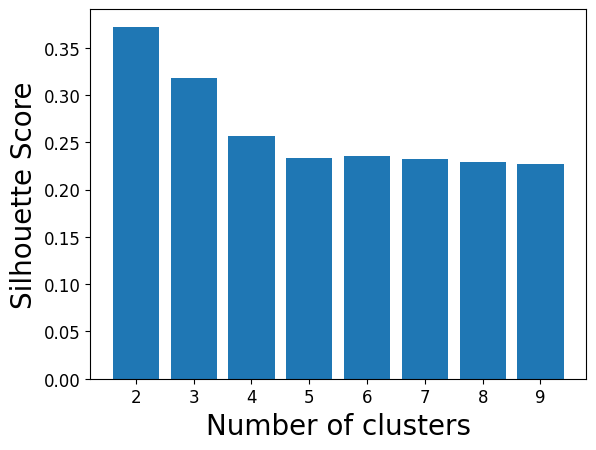

In [0]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for i in range(2, 10):
    m1 = KMeans(n_clusters=i, random_state=42)
    labels = m1.fit_predict(pca)
    silhouette_scores.append(silhouette_score(pca, labels)) 

plt.bar(range(2, 10), silhouette_scores) 
plt.xlabel('Number of clusters', fontsize=20) 
plt.ylabel('Silhouette Score', fontsize=20) 
plt.show()

### 1.6.2 Model building

In [0]:
# Training a predicting using K-Means Algorithm.

kmeans=KMeans(n_clusters=3, random_state=42).fit(pca)
pred=kmeans.predict(pca)


# Appending those cluster value into main dataframe (without standard-scalar)
ifood['Cluster'] = pred + 1

In [0]:
ifood.head()

ID Education Marital_Status  ...  Num_Children  Num_Family_Members  Cluster
1090  1127       PhD        Married  ...             0                   2        2
15    2114       PhD         Single  ...             0                   1        2
873    738  2n Cycle         Single  ...             2                   3        3
610   7930    Master         Single  ...             0                   1        3
657    946  2n Cycle       Together  ...             0                   2        3

[5 rows x 35 columns]

Saving figure cluster_distribution


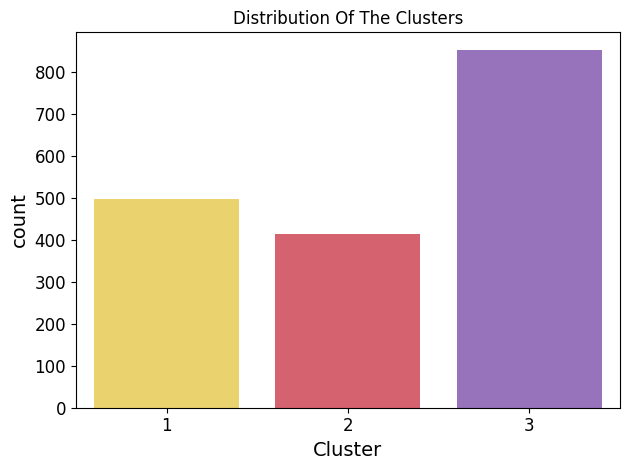

In [0]:
pl = sns.countplot(x=ifood["Cluster"], palette=ifood_colors)
pl.set_title("Distribution Of The Clusters")
save_fig('cluster_distribution')
plt.show()

In [0]:
# Kruskal-Wallis test between cluster
for col in numeric_cols:
    groups = [ifood.loc[ifood['Cluster'] == cluster, col] for cluster in ifood['Cluster'].unique()]
    kw_results = kruskal(*groups)
    print("Kruskal-Wallis Test for", col)
    print("H-statistic:", kw_results.statistic)
    print("p-value:", kw_results.pvalue)
    print()

Kruskal-Wallis Test for Income
H-statistic: 1222.209908129206
p-value: 3.985571328841854e-266

Kruskal-Wallis Test for Kidhome
H-statistic: 695.0279505506754
p-value: 1.1928838356672935e-151

Kruskal-Wallis Test for Teenhome
H-statistic: 603.3045842330752
p-value: 9.86447735827157e-132

Kruskal-Wallis Test for Recency
H-statistic: 0.042797095380897904
p-value: 0.9788287768720543

Kruskal-Wallis Test for MntWines
H-statistic: 1242.8346700168208
p-value: 1.3239770188259194e-270

Kruskal-Wallis Test for MntFruits
H-statistic: 769.6559551974548
p-value: 7.435888121857591e-168

Kruskal-Wallis Test for MntMeatProducts
H-statistic: 1304.1537978733822
p-value: 6.406207701459279e-284

Kruskal-Wallis Test for MntFishProducts
H-statistic: 807.2054508932255
p-value: 5.218713524834485e-176

Kruskal-Wallis Test for MntSweetProducts
H-statistic: 702.4620159699784
p-value: 2.89942152541434e-153

Kruskal-Wallis Test for MntGoldProds
H-statistic: 692.8125581230274
p-value: 3.611307808590343e-151

Kruska

These results indicate that most of the variables exhibit significant differences across different clusters, except for Recency, where no significant differences were observed.

In [0]:
# Chi2 test between clusters

for col in categ_cols:
    contingency_table = pd.crosstab(ifood['Cluster'], ifood[col])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-square Test for {col}:")
    print(f"Chi-square value: {chi2}")
    print(f"P-value: {p_value}")
    print()

Chi-square Test for Education:
Chi-square value: 57.82557388703416
P-value: 1.242343138341992e-09

Chi-square Test for Marital_Status:
Chi-square value: 27.24628469240893
P-value: 0.0006409729870845673

Chi-square Test for AcceptedCmp3:
Chi-square value: 0.48350463997238985
P-value: 0.7852506443584997

Chi-square Test for AcceptedCmp4:
Chi-square value: 85.05367316832182
P-value: 3.394919952667125e-19

Chi-square Test for AcceptedCmp5:
Chi-square value: 358.56936044119846
P-value: 1.3729435793039034e-78

Chi-square Test for AcceptedCmp1:
Chi-square value: 237.50483438364978
P-value: 2.6698108944775035e-52

Chi-square Test for AcceptedCmp2:
Chi-square value: 36.63486612091002
P-value: 1.1087659981091778e-08

Chi-square Test for Complain:
Chi-square value: 1.5436957500052522
P-value: 0.4621582680616497



These results suggest that certain demographic and behavioral factors, such as education level and response to marketing campaigns (except for campaign 3), are associated with the clustering of customers.

Saving figure cluster_education


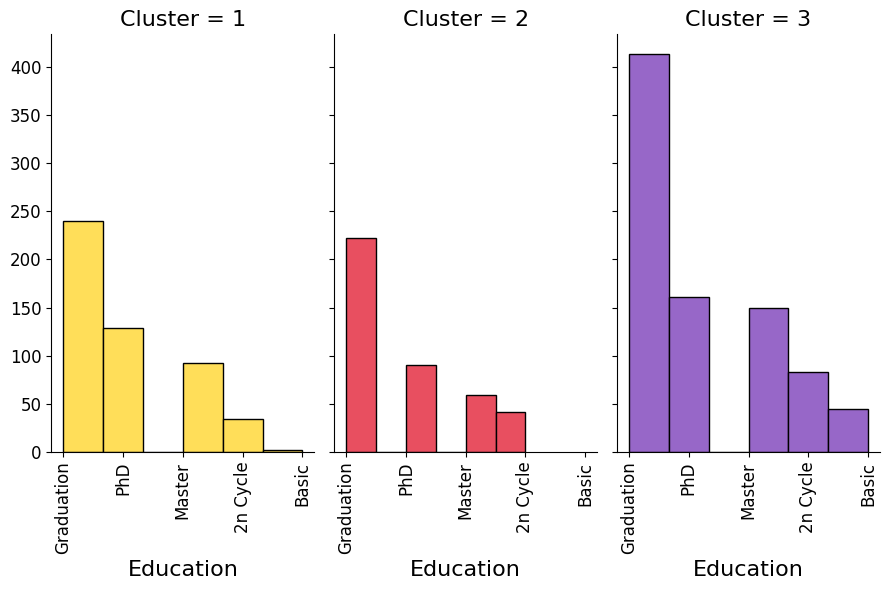

In [0]:
# Cluster versus education

diag = sns.FacetGrid(ifood, col="Cluster", hue="Cluster", palette=ifood_colors)
diag.map(plt.hist, "Education", bins=6, ec="k")
diag.set_xticklabels(rotation=90, color='black')
diag.set_xlabels(size=16, color='black')
diag.set_titles(size=16, color='black')
diag.fig.set_figheight(6)
save_fig("cluster_education")
plt.show()

Saving figure cluster_marital_status


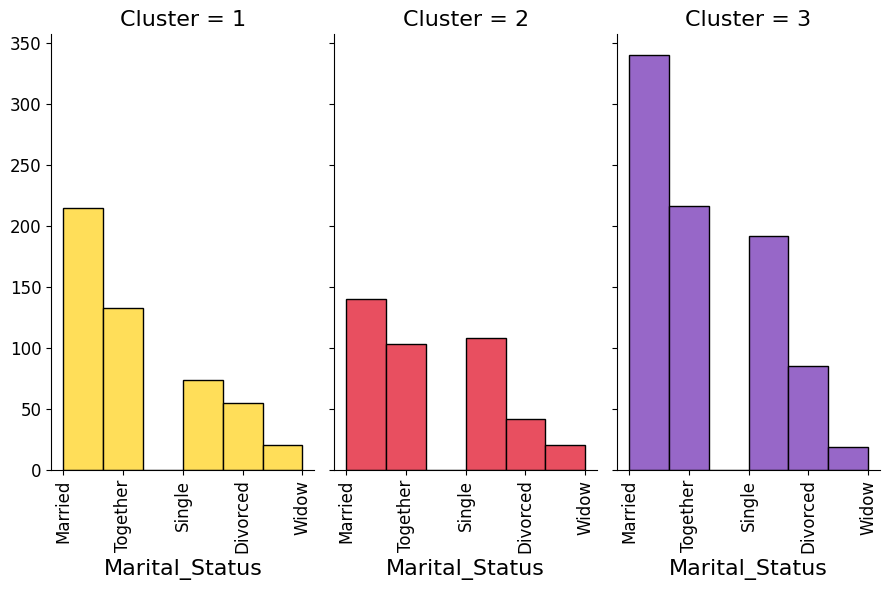

In [0]:
# Cluster versus marital status

diag = sns.FacetGrid(ifood, col="Cluster", hue="Cluster", palette=ifood_colors)
diag.map(plt.hist, "Marital_Status", bins=6, ec="k")
diag.set_xticklabels(rotation=90, color='black')
diag.set_xlabels(size=16, color='black')
diag.set_titles(size=16, color='black')
diag.fig.set_figheight(6)
save_fig("cluster_marital_status")
plt.show()

Saving figure cluster_income_per_person


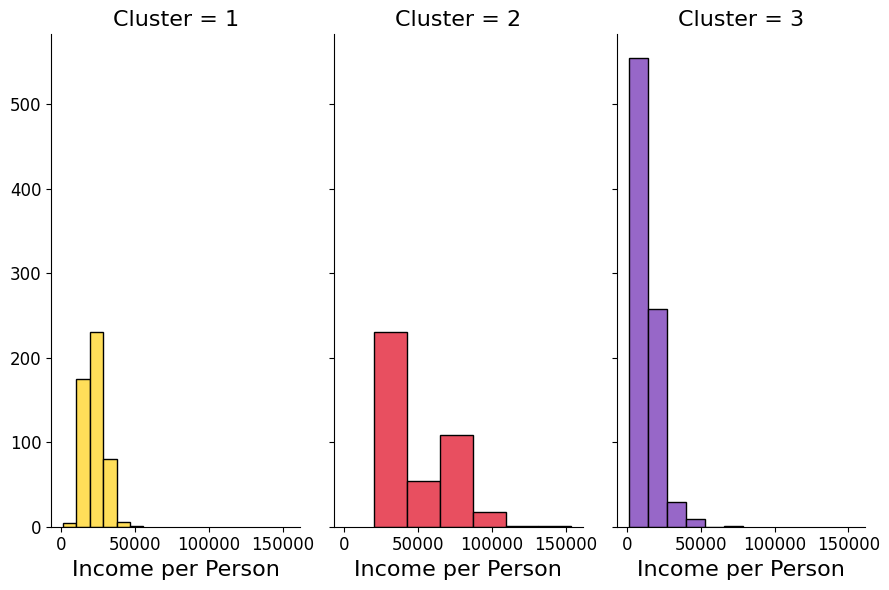

In [0]:
# Cluster versus income per person

diag = sns.FacetGrid(ifood, col="Cluster", hue="Cluster", palette=ifood_colors)
diag.map(plt.hist, "Income_Per_Person", bins=6, ec="k")
diag.set_xlabels('Income per Person', size=16, color='black')
diag.set_titles(size=16, color='black')
diag.fig.set_figheight(6)
save_fig("cluster_income_per_person")
plt.show()

Saving figure cluster_income_person_boxplot


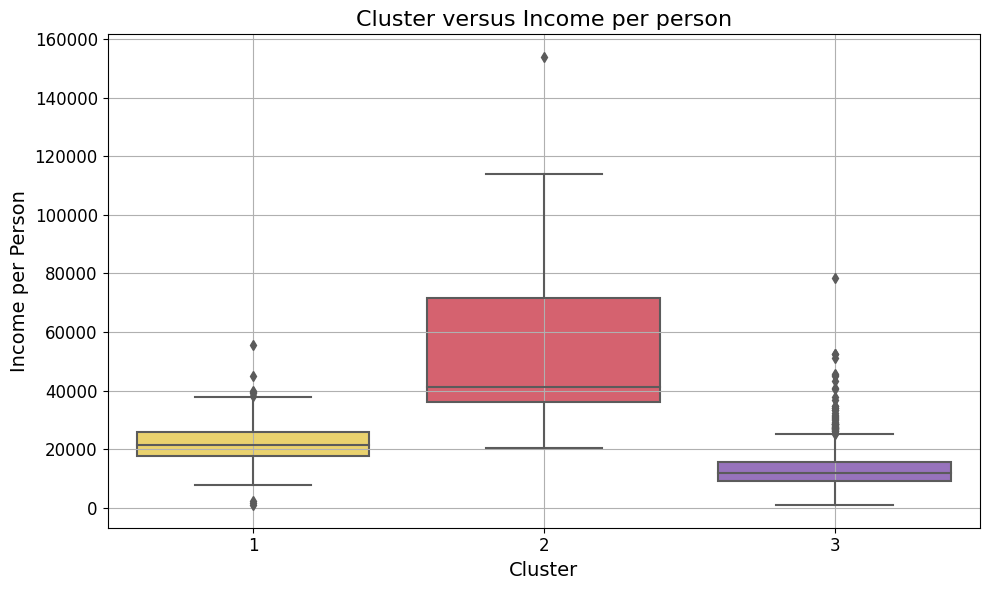

In [0]:
# Cluster versus Income per person

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Income_Per_Person', data=ifood, palette=ifood_colors)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Income per Person', fontsize=14)
plt.title('Cluster versus Income per person', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
save_fig("cluster_income_person_boxplot")
plt.show()

Saving figure cluster_num_children


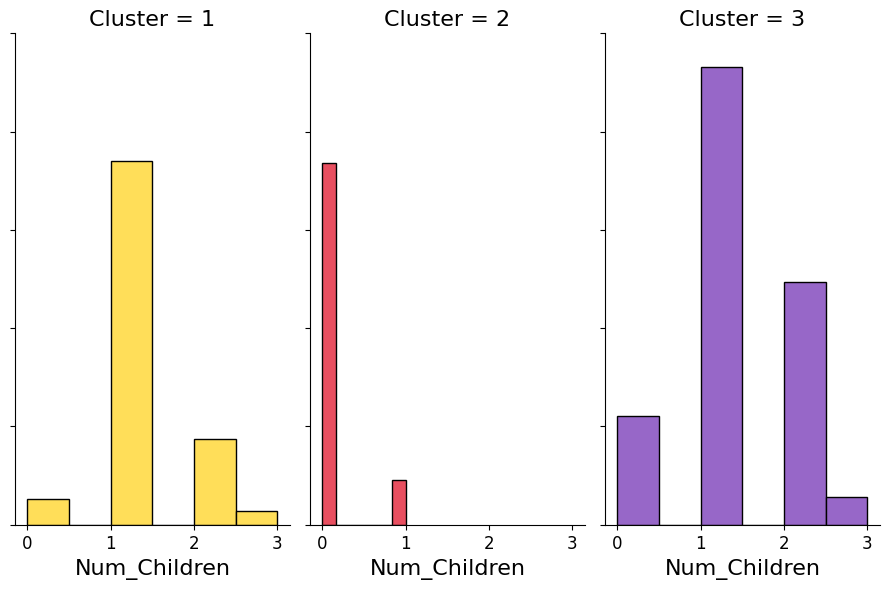

In [0]:
# Cluster versus number of children

diag = sns.FacetGrid(ifood, col="Cluster", hue="Cluster", palette=ifood_colors)
diag.map(plt.hist, "Num_Children", bins=6, ec="k")
diag.set_yticklabels(color='black')
diag.set_xlabels(size=16, color='black')
diag.set_titles(size=16, color='black')
diag.fig.set_figheight(6)
save_fig("cluster_num_children")
plt.show()

Saving figure cluster_children_boxplot


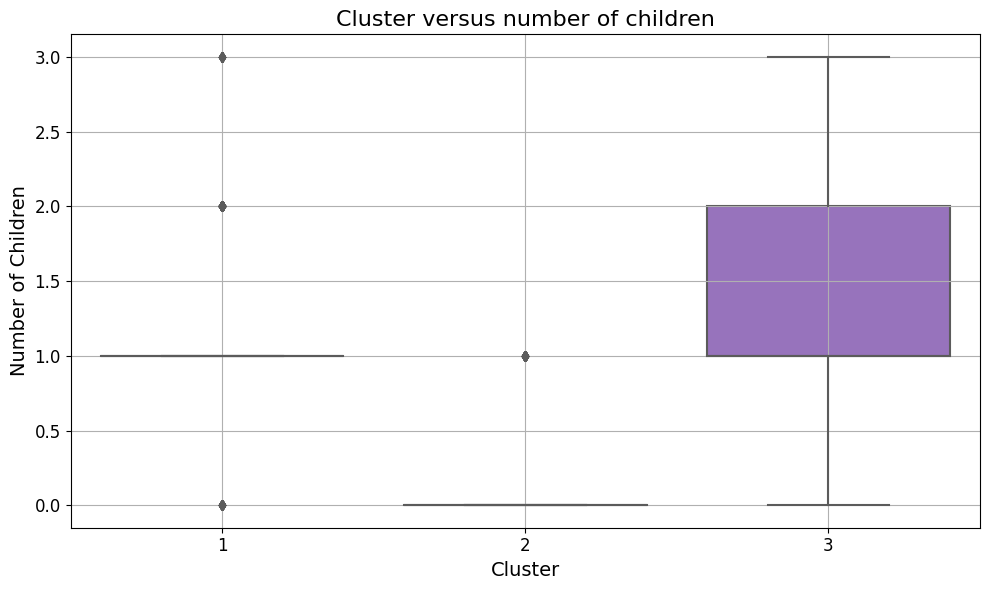

In [0]:
# Cluster versus number of children

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Num_Children', data=ifood, palette=ifood_colors)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Children', fontsize=14)
plt.title('Cluster versus number of children', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
save_fig("cluster_children_boxplot")
plt.show()

Saving figure cluster_num_family_members


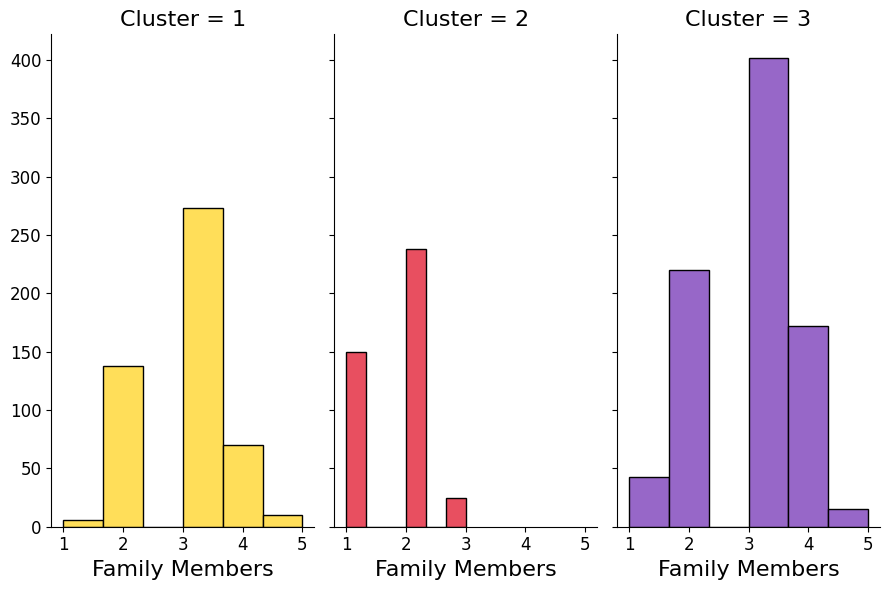

In [0]:
# Cluster versus number of family members

diag = sns.FacetGrid(ifood, col="Cluster", hue="Cluster", palette=ifood_colors)
diag.map(plt.hist, "Num_Family_Members", bins=6, ec="k")
diag.set_xlabels('Family Members', size=16, color='black')
diag.set_titles(size=16, color='black')
diag.fig.set_figheight(6)
save_fig("cluster_num_family_members")
plt.show()

Saving figure cluster_family_members_boxplot


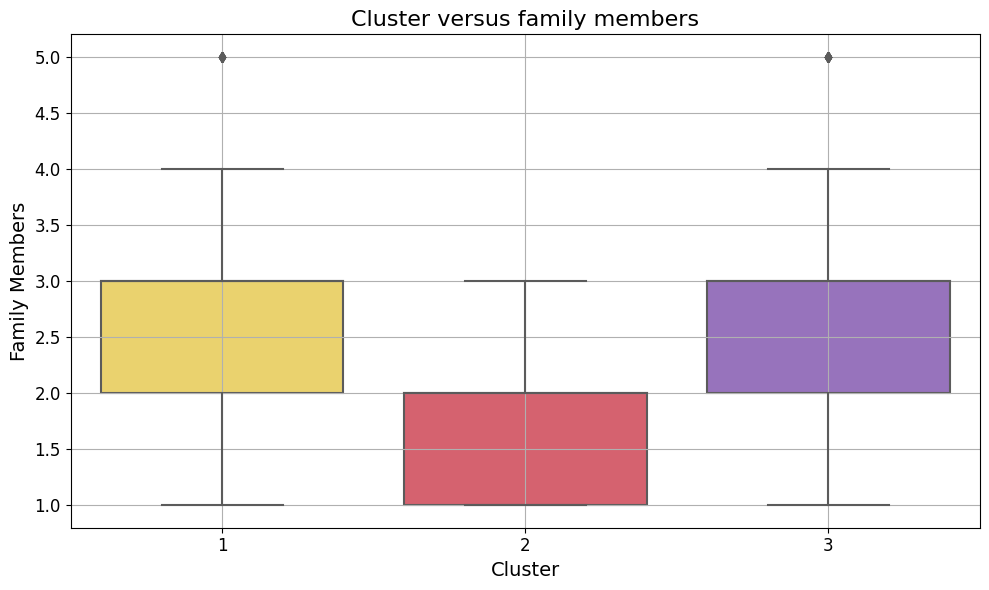

In [0]:
# Cluster versus number of family members

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Num_Family_Members', data=ifood, palette=ifood_colors)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Family Members', fontsize=14)
plt.title('Cluster versus family members', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
save_fig("cluster_family_members_boxplot")
plt.show()

Saving figure cluster_age


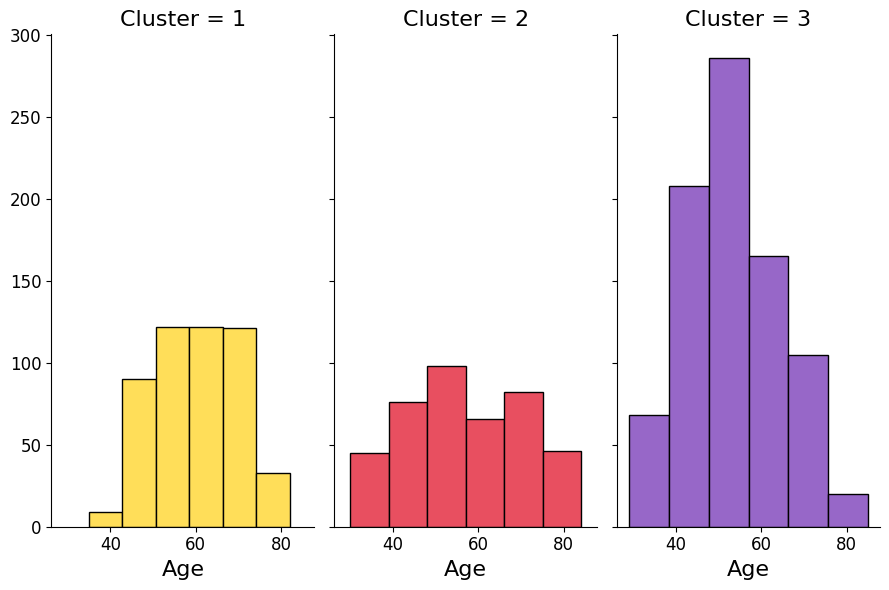

In [0]:
# Cluster versus age

diag = sns.FacetGrid(ifood, col="Cluster", hue="Cluster", palette=ifood_colors)
diag.map(plt.hist, "Age", bins=6, ec="k")
diag.set_xlabels(size=16, color='black')
diag.set_titles(size=16, color='black')
diag.fig.set_figheight(6)
save_fig("cluster_age")
plt.show()

Saving figure cluster_age_boxplot


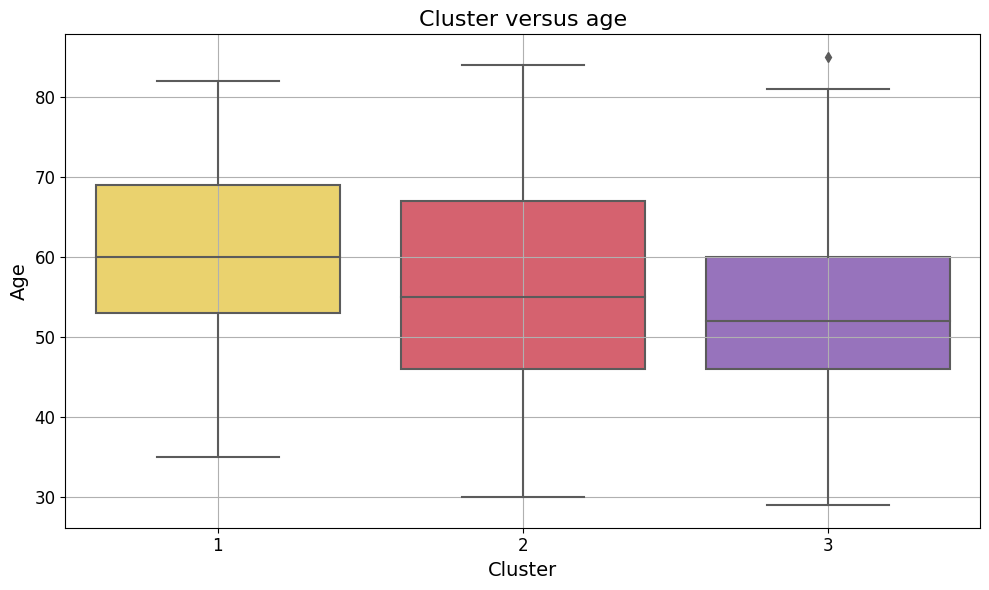

In [0]:
# Cluster versus age

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Age', data=ifood, palette=ifood_colors)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.title('Cluster versus age', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
save_fig("cluster_age_boxplot")
plt.show()

Saving figure cluster_expenses


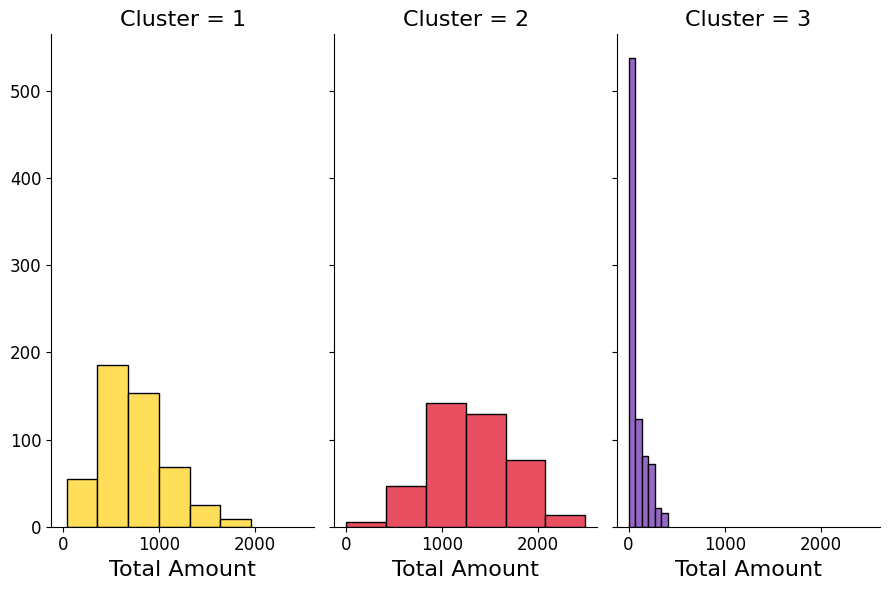

In [0]:
# Cluster versus total amount (Expenses)

diag = sns.FacetGrid(ifood, col="Cluster", hue="Cluster", palette=ifood_colors)
diag.map(plt.hist, "Total_Mnt", bins=6, ec="k")
diag.set_xlabels('Total Amount', size=16, color='black')
diag.set_titles(size=16, color='black')
diag.fig.set_figheight(6)
save_fig("cluster_expenses")
plt.show()

Saving figure cluster_total_mnt_boxplot


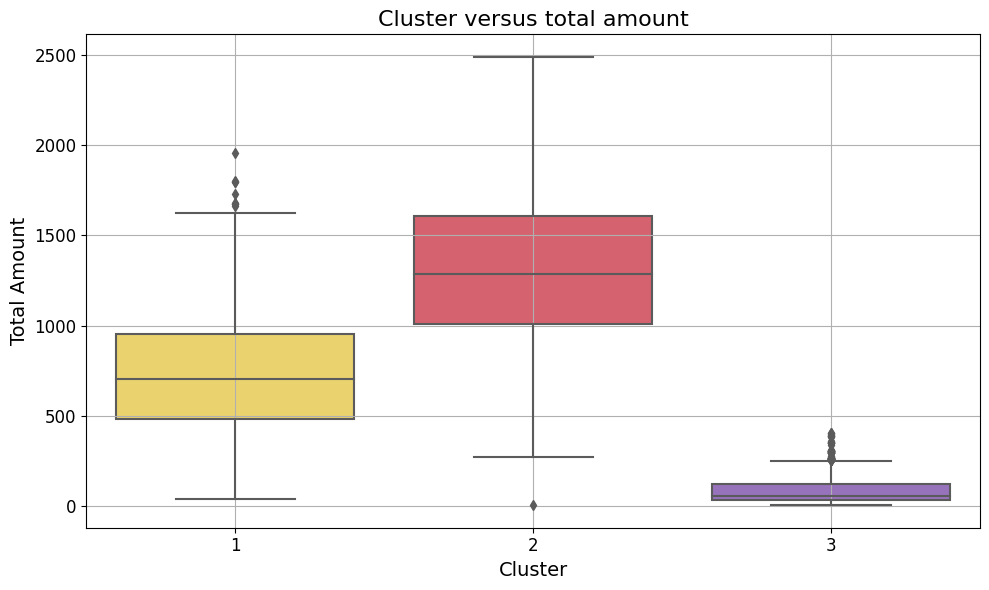

In [0]:
# Cluster versus total amount (Expenses)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Total_Mnt', data=ifood, palette=ifood_colors)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Total Amount', fontsize=14)
plt.title('Cluster versus total amount', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
save_fig("cluster_total_mnt_boxplot")
plt.show()

Saving figure cluster_total_purchases


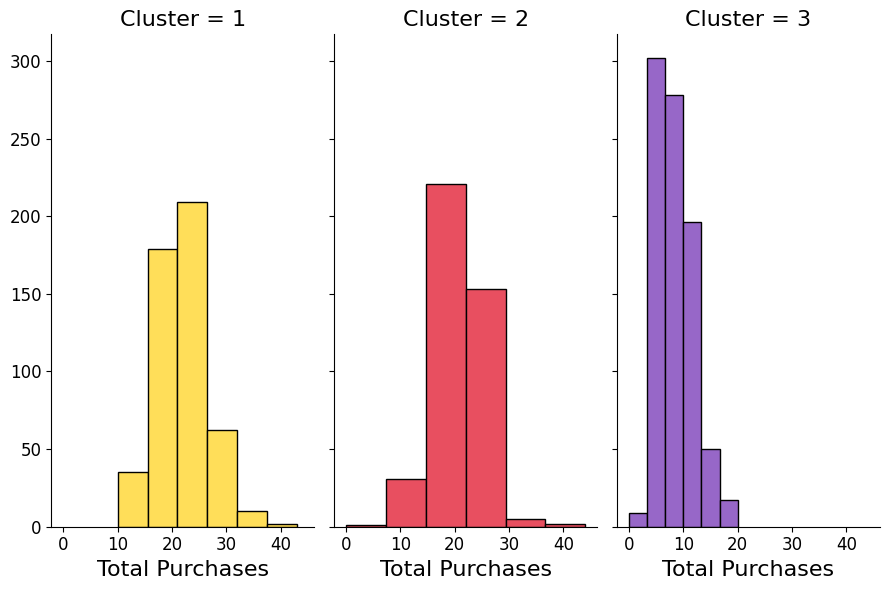

In [0]:
# Cluster versus total purchases

diag = sns.FacetGrid(ifood, col="Cluster", hue="Cluster", palette=ifood_colors)
diag.map(plt.hist, "Total_Purchases", bins=6, ec="k")
diag.set_xlabels('Total Purchases', size=16, color='black')
diag.set_titles(size=16, color='black')
diag.fig.set_figheight(6)
save_fig("cluster_total_purchases")
plt.show()

Saving figure cluster_total_purchases_boxplot


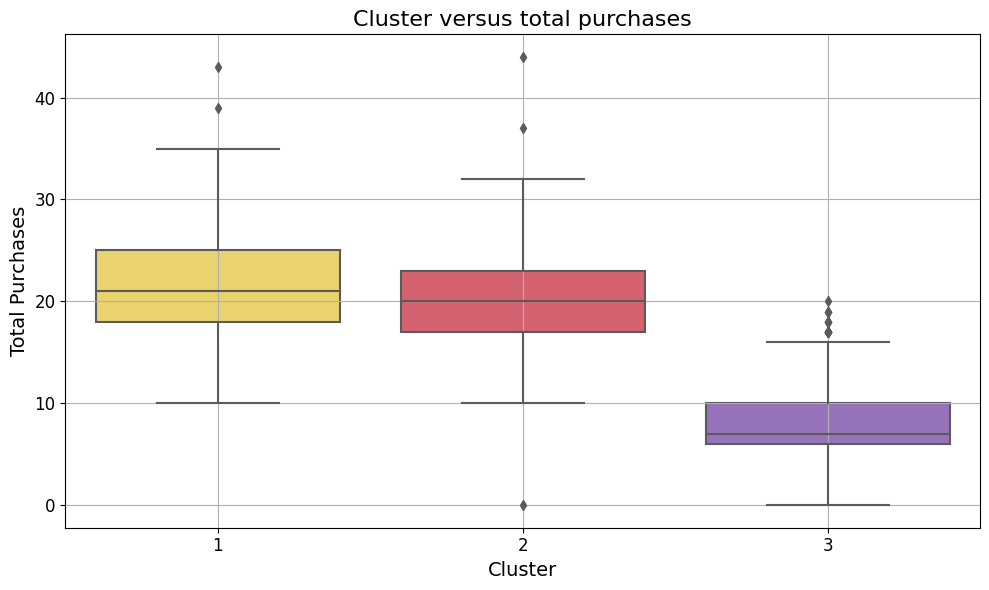

In [0]:
# Cluster versus total purchases

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Total_Purchases', data=ifood, palette=ifood_colors)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Total Purchases', fontsize=14)
plt.title('Cluster versus total purchases', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
save_fig("cluster_total_purchases_boxplot")
plt.show()

Saving figure cluster_campaigns_accepted


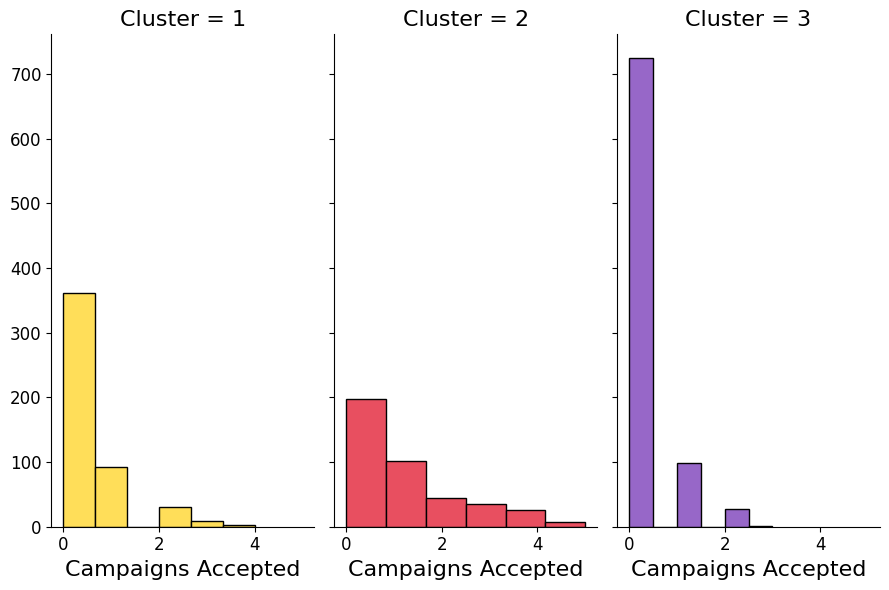

In [0]:
# Cluster versus total campaigns accepted

diag = sns.FacetGrid(ifood, col="Cluster", hue="Cluster", palette=ifood_colors)
diag.map(plt.hist, "Total_Campaigns_Accepted", bins=6, ec="k")
diag.set_xlabels('Campaigns Accepted', size=16, color='black')
diag.set_titles(size=16, color='black')
diag.fig.set_figheight(6)
save_fig("cluster_campaigns_accepted")
plt.show()

Saving figure cluster_total_campaigns_boxplot


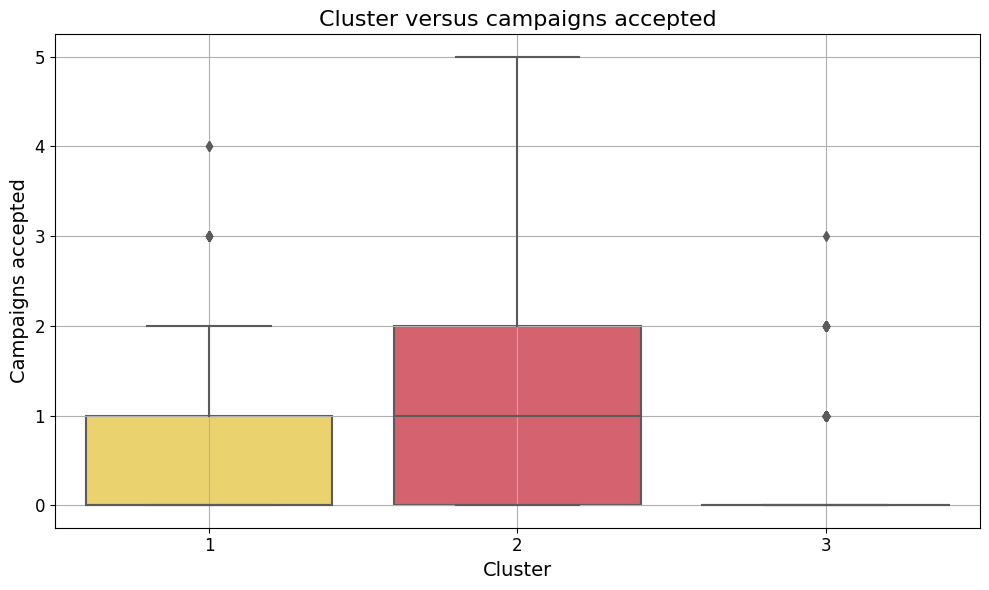

In [0]:
# Cluster versus campaigns accepted

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Total_Campaigns_Accepted', data=ifood, palette=ifood_colors)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Campaigns accepted', fontsize=14)
plt.title('Cluster versus campaigns accepted', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
save_fig("cluster_total_campaigns_boxplot")
plt.show()

Saving figure cluster_target


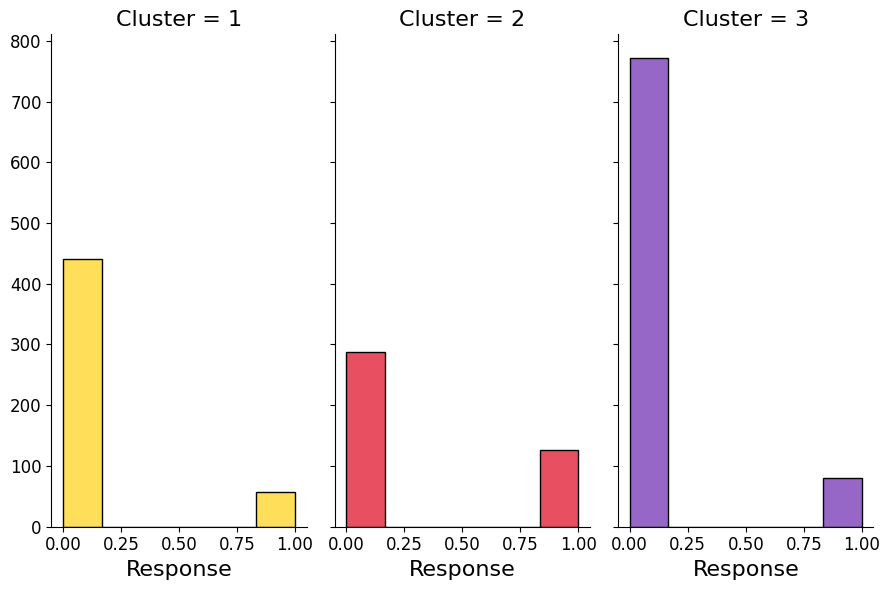

In [0]:
# Cluster versus target

diag = sns.FacetGrid(ifood, col="Cluster", hue="Cluster", palette=ifood_colors)
diag.map(plt.hist, "Response", bins=6, ec="k")
diag.set_xlabels('Response', size=16, color='black')
diag.set_titles(size=16, color='black')
diag.fig.set_figheight(6)
save_fig("cluster_target")
plt.show()

In [0]:
# Grouping the data by cluster and calculating the mean and standard deviation
cluster_stats = ifood.groupby('Cluster').agg({'Income_Per_Person': ['mean', 'std'],
                                              'Num_Children': ['mean', 'std'],
                                              'Age': ['mean', 'std'],
                                              'Num_Family_Members': ['mean', 'std'],
                                              'Total_Mnt': ['mean', 'std'],
                                              'Total_Purchases': ['mean', 'std'],
                                              'Total_Campaigns_Accepted': ['mean', 'std']})

# Renaming the columns
cluster_stats.columns = ['Income_Per_Person_Mean', 'Income_Per_Person_Std',
                         'Children_Mean', 'Children_Std',
                         'Age_Mean', 'Age_Std',
                         'Num_Family_Members_Mean', 'Num_Family_Members_Std',
                         'Total_Mnt_Mean', 'Total_Mnt_Std',
                         'Total_Purchases_Mean', 'Total_Purchases_Std',
                         'Total_Campaigns_Accepted_Mean', 'Total_Campaigns_Accepted_Std']

# Transposing the DataFrame for better readability
cluster_stats_transposed = cluster_stats.transpose()

# Displaying the transposed table
cluster_stats_transposed

Cluster                                   1             2             3
Income_Per_Person_Mean         21895.326928  51505.271994  13238.571518
Income_Per_Person_Std           6670.293291  21043.217495   7086.988602
Children_Mean                      1.179074      0.108959      1.225352
Children_Std                       0.555512      0.311965      0.708130
Age_Mean                          60.265594     56.537530     53.258216
Age_Std                            9.700031     13.538750     11.012075
Num_Family_Members_Mean            2.879276      1.697337      2.877934
Num_Family_Members_Std             0.730605      0.577001      0.847548
Total_Mnt_Mean                   746.760563   1313.612591     88.875587
Total_Mnt_Std                    347.374422    422.583329     84.017378
Total_Purchases_Mean              21.682093     20.370460      8.165493
Total_Purchases_Std                4.724629      4.447733      3.403818
Total_Campaigns_Accepted_Mean      0.382294      1.062954      0.183099
Total_Campaigns_Accepted_Std       0.720333      1.342331      0.469313

In [0]:
# Contingency table for Marital_Status by cluster
marital_status_cross = pd.crosstab(ifood['Marital_Status'], ifood['Cluster'])

# Contingency table for Education by cluster
education_cross = pd.crosstab(ifood['Education'], ifood['Cluster'])

# Calculating percentages
marital_status_percentage = marital_status_cross.apply(lambda x: x / x.sum(), axis=1)
education_percentage = education_cross.apply(lambda x: x / x.sum(), axis=1)

# Displaying the tables
print("Marital_Status Frequencies by Cluster (%):")
marital_status_percentage

Marital_Status Frequencies by Cluster (%):


Cluster                1         2         3
Marital_Status                              
Divorced        0.302198  0.230769  0.467033
Married         0.309353  0.201439  0.489209
Single          0.197861  0.288770  0.513369
Together        0.294248  0.227876  0.477876
Widow           0.338983  0.338983  0.322034

In [0]:
print("\nEducation Frequencies by Cluster (%):")
education_percentage


Education Frequencies by Cluster (%):


Cluster            1         2         3
Education                               
2n Cycle    0.213836  0.264151  0.522013
Basic       0.042553  0.000000  0.957447
Graduation  0.274286  0.253714  0.472000
Master      0.305648  0.196013  0.498339
PhD         0.339474  0.236842  0.423684

##### Important note:

    Cluster 1: High income per person, higher expenditure on products, with larger volume of purchases and greater acceptance of campaigns, relatively older, smaller family structure.

    Cluster 2: Low income, less expenditure on products and lower volume of purchases, higher number of children, slightly lower educational level.

The first one is more aligned with the campaign profiles.

________________________________________________________________________________________________________________________________

## 1.7 Predictive model (classification)

I will use only logistic regression for prediction. I understand that there is little data to choose any more complex model.

In [0]:
ifood_pr.drop(columns=['Total_Campaigns_Accepted', 'Num_Children', 'Num_Family_Members'], inplace=True)

In [0]:
X_train, y_train, X_test, y_test = ifood_pr, ifood_label, strat_test_set.drop('Response', axis=1), strat_test_set.Response

In [0]:
# Find NaN Values
nan_values = X_test[X_test.isna().any(axis=1)]

# Show NaN values
print("NaN values found on X_test:")
nan_values

NaN values found on X_test:


ID  Year_Birth   Education Marital_Status  Income  Kidhome  Teenhome  \
10    1994        1983  Graduation        Married     NaN        1         0   
2059  7187        1969      Master       Together     NaN        1         1   
1382  2902        1958  Graduation       Together     NaN        1         1   

     Dt_Customer  Recency  MntWines  ...  NumStorePurchases  \
10    2013-11-15       11         5  ...                  2   
2059  2013-05-18       52       375  ...                  4   
1382  2012-09-03       87        19  ...                  3   

      NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
10                    7             0             0             0   
2059                  3             0             0             0   
1382                  5             0             0             0   

      AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  
10               0             0         0              3         11  
2059             0             0         0              3         11  
1382             0             0         0              3         11  

[3 rows x 28 columns]

In [0]:
# Impute median for NaN values in each column of DataFrame X_test
X_test = X_test.fillna(X_test.median())

# Check if NaN values have been successfully imputed with the median
print("NaN values have been imputed with the median in DataFrame X_test.")

NaN values have been imputed with the median in DataFrame X_test.


C:\Users\andre\AppData\Local\Temp\ipykernel_6132\240274150.py:2: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



### 1.7.1 Feature engineering on the test set

In [0]:
# Time as customer in months
X_test['Dt_Customer'] = pd.to_datetime(X_test['Dt_Customer'])
X_test['Time_Customer_Months'] = ((current_date - X_test['Dt_Customer']) / np.timedelta64(1, 'M')).astype(int)

# Calculate age
X_test['Age'] = current_year - X_test['Year_Birth']

# Total Amount Spent
mnt_cols = [col for col in X_test.columns if 'Mnt' in col and 'Gold' not in col]
X_test['Total_Mnt'] = X_test[mnt_cols].sum(axis=1)

# Total Purchases
purchase_cols = [col for col in X_test.columns if 'Purchases' in col]
X_test['Total_Purchases'] = X_test[purchase_cols].sum(axis=1)

# Mapping persons per Marital Status
marital_status_mapping = {'Married': 2, 'Together': 2, 'Single': 1, 'Divorced': 1, 'Widow': 1}
X_test['Marital_Status_Codf'] = X_test['Marital_Status'].map(marital_status_mapping)

# Adding the number of children
X_test['Num_Family_Members'] = X_test['Marital_Status_Codf'] + X_test['Kidhome'] + X_test['Teenhome']

# Calculating the average income per person
X_test['Income_Per_Person'] = X_test['Income'] / X_test['Num_Family_Members']

# Creating new binary columns for each education category, considering the hierarchy
apply_education_logic(X_test)

# Dummies for Marital_Status
X_test = pd.get_dummies(X_test, columns=['Marital_Status'], prefix=['Marital_Status'])

In [0]:
X_test.drop(columns=['Dt_Customer', 'Year_Birth', 'Z_CostContact', 'Z_Revenue', 'Marital_Status_Codf', 'Num_Family_Members', 'ID', 'Education'], inplace=True)

### 1.7.2 Standardization on the test set

In [0]:
from sklearn.preprocessing import StandardScaler

# Select the columns to normalize
columns_to_normalize = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 
                        'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                        'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Time_Customer_Months', 'Age', 
                        'Total_Mnt', 'Total_Purchases', 'Income_Per_Person']

# Normalize only the selected columns
scaled_features = StandardScaler().fit_transform(X_test[columns_to_normalize])

# Remove the numeric columns from 'ifood_pr'
X_test.drop(columns_to_normalize, axis=1, inplace=True)

# Create a DataFrame with the normalized data
scaled_features_test = pd.DataFrame(scaled_features, index=X_test.index, columns=columns_to_normalize)

# Concatenate the normalized DataFrames with the original 'ifood_pr' DataFrame
X_test = pd.concat([X_test, scaled_features_test], axis=1)

X_test

AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
2044             0             0             0             0             0   
467              0             0             0             0             0   
1707             0             0             0             0             0   
704              0             0             0             0             0   
1464             0             0             0             0             0   
...            ...           ...           ...           ...           ...   
748              1             0             0             0             0   
959              0             0             0             0             0   
1695             0             0             0             0             0   
652              0             0             0             0             0   
606              0             0             0             0             0   

      Complain  Education_Basic  Education_2n_Cycle  Education_Graduation  \
2044         0                1                   1                     1   
467          0                1                   1                     1   
1707         0                1                   1                     1   
704          0                1                   1                     1   
1464         0                1                   1                     1   
...        ...              ...                 ...                   ...   
748          0                1                   1                     1   
959          0                1                   1                     1   
1695         0                1                   1                     1   
652          0                1                   1                     1   
606          0                1                   1                     1   

      Education_Master  ...  NumDealsPurchases  NumWebPurchases  \
2044                 0  ...           2.944657         0.038725   
467                  0  ...          -0.683808        -1.144146   
1707                 0  ...          -0.165456         0.433015   
704                  1  ...           0.352896         0.038725   
1464                 1  ...          -0.683808        -1.144146   
...                ...  ...                ...              ...   
748                  0  ...          -0.683808        -1.144146   
959                  1  ...           0.871248         0.433015   
1695                 0  ...          -0.165456        -0.355565   
652                  0  ...           1.389601         2.010177   
606                  0  ...          -0.165456        -1.144146   

      NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
2044             0.039291           0.021877           0.795467   
467             -0.887145          -1.203246           1.233806   
1707            -0.269521          -0.590684           0.795467   
704             -0.578333          -0.590684           0.795467   
1464            -0.887145          -0.896965           0.795467   
...                   ...                ...                ...   
748             -0.887145          -1.203246           0.795467   
959             -0.269521          -0.284404           0.357129   
1695             0.039291           2.165843          -1.396226   
652              0.965727           1.859562           0.357129   
606             -0.578333          -0.896965          -0.081210   

      Time_Customer_Months       Age  Total_Mnt  Total_Purchases  \
2044              1.571606 -0.222287  -0.371517         0.764835   
467               1.262460 -0.143000  -0.945027        -1.410289   
1707              1.726179  0.253435  -0.527160        -0.258753   
704              -0.746987  0.015574  -0.657426        -0.386701   
1464              0.025877 -1.411591  -0.894274        -1.282341   
...                    ...       ...        ...              ...   
748              -0.283269 -0.143000  -0.936568        -1.

### 1.7.2  Predicting on train

In [0]:
X_train.drop(columns=['Marital_Status_Widow', 'MntWines','MntFruits','MntMeatProducts','MntFishProducts',
                      'MntSweetProducts', 'NumStorePurchases', 'Education_Basic', 'Total_Purchases'], inplace=True)

In [0]:
# Removing multicolinearity

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant to the DataFrame X
X_with_const = sm.add_constant(X_train)

# Calculate the GVIF for each variable
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["GVIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display the DataFrame with the GVIF results
vif_data

Feature       GVIF
0                     const  72.456753
1              AcceptedCmp3   1.104861
2              AcceptedCmp4   1.314147
3              AcceptedCmp5   1.562786
4              AcceptedCmp1   1.358525
5              AcceptedCmp2   1.189839
6                  Complain   1.013882
7        Education_2n_Cycle   1.336879
8      Education_Graduation   1.372684
9          Education_Master   1.908504
10            Education_PhD   1.814896
11  Marital_Status_Divorced   3.745599
12   Marital_Status_Married   8.967463
13    Marital_Status_Single   6.038357
14  Marital_Status_Together   7.403309
15                   Income   6.140585
16                  Kidhome   2.067548
17                 Teenhome   2.246556
18                  Recency   1.011541
19             MntGoldProds   1.509039
20        NumDealsPurchases   1.639571
21          NumWebPurchases   1.868058
22      NumCatalogPurchases   3.145950
23        NumWebVisitsMonth   2.712452
24     Time_Customer_Months   1.302660
25                      Age   1.333432
26                Total_Mnt   5.289626
27        Income_Per_Person   6.314397

<Figure size 1000x800 with 0 Axes>

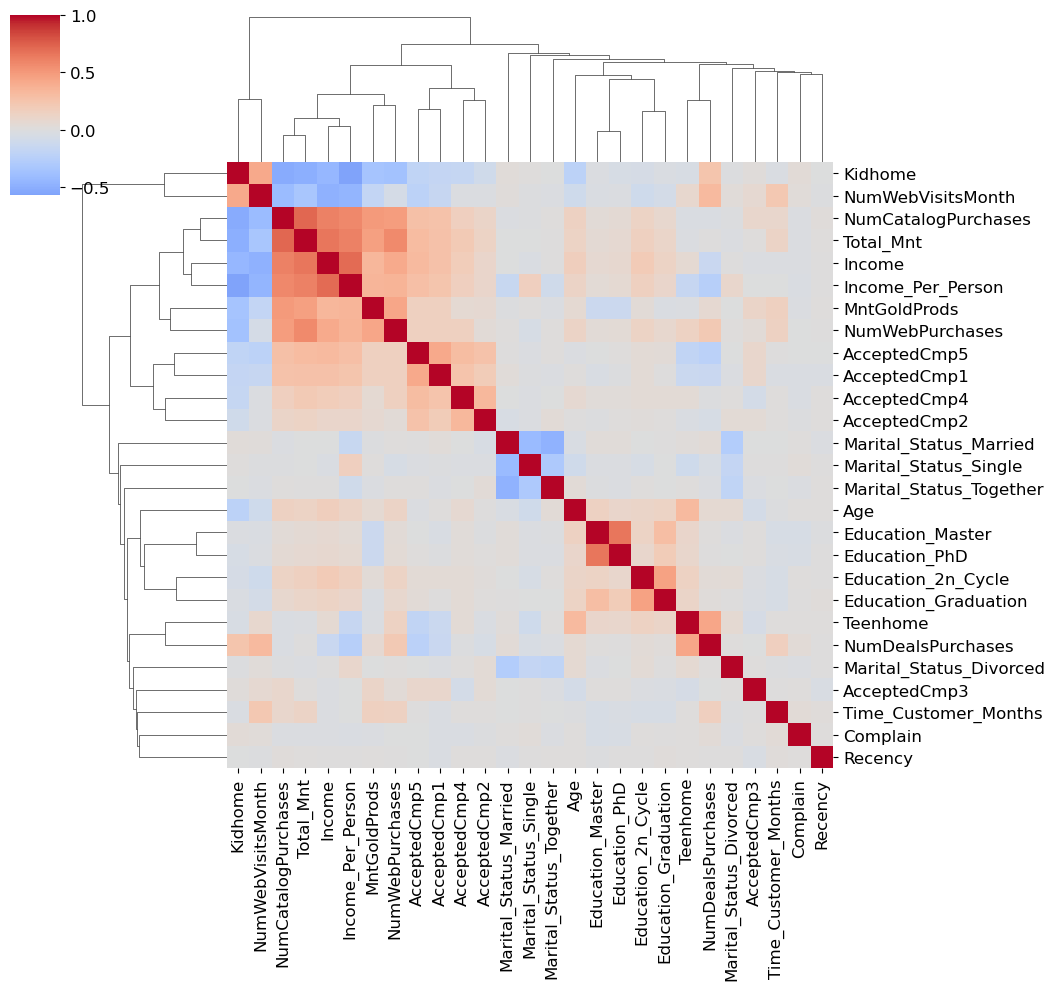

In [0]:
# Calculate correlation matrix using non-parametric test of correlation (Kendall)
corrs = X_train.select_dtypes(include=np.number).corr(method='kendall')

# Plot clustered heatmap of correlations
plt.figure(figsize=(10, 8))
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0)
plt.show()

In [0]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(solver='lbfgs', max_iter=len(X_train), random_state=42).fit(X_train, y_train)
print(log_model)

LogisticRegression(max_iter=1762, random_state=42)


### 1.7.3 Evaluation on train

    - Precision: True Positives/(True Positives + False Positives) 
    - Recall: True Positives/(True Positives + False Negatives)

#### F1-Score takes the harmonic mean of Precision and Recall. This is a good metric to use for imbalanced datasets.

    - F1-Score: (2 x Precision x Recall)/(Precision + Recall)

ROC-AUC is another metric that works well for imbalanced classes. PR-AUC behaves similar to ROC-AUC, except we're evaluating the tradeoff between Precision and Recall.

In [0]:
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve

def model_eval_train(classifier, model_name, X_train, y_train):

    # predict data train
    y_train_pred = classifier.predict(X_train)
    y_train_pred_prob = classifier.predict_proba(X_train)

    # print classification report
    print('Classification Report Training Model ('+model_name+'):\n')
    f1_s = round(f1_score(y_train, y_train_pred), 3)
    rocauc_score = round(roc_auc_score(y_train, y_train_pred_prob[:, 1]), 3)
    
    print(f'F1 Score = {f1_s}')
    print(f'ROC AUC = {rocauc_score}\n')

    # form confusion matrix as a dataFrame
    conf_matrix = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No Response', 'Response'), ('No Response', 'Response'))
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()

    print("==== Actual Data (Train) =====")
    print("Total =", len(y_train))
    print("No Response =", len(y_train[y_train == 0]))
    print("Response =", len(y_train[y_train == 1]))
    print("==== Predicted Data (Train) =====")
    print("TP = {}, FP = {}, TN = {}, FN = {}".format(tp, fp, tn, fn))
    print("Predictly Correct =", tn+tp)
    print("Predictly Wrong =", fn+fp, "\n")

    # plot confusion matrix
    plt.figure(figsize=[8,5])
    
    c_matrix = confusion_matrix(y_train, y_train_pred)
    names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    heatmap = sns.heatmap(conf_matrix, annot = labels, annot_kws={'size': 13}, fmt='', cmap='Oranges')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=13)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=13)

    plt.title('Confusion Matrix for Training Model ('+model_name+')\n', fontsize=13, color='black')
    plt.ylabel('Actual Label', fontsize=13)
    plt.xlabel('\nPredicted Label', fontsize=13)
    plt.show()
    print("\n")

    # ROC AUC Curve
    plt.figure(figsize=[8,5])
    fpr, tpr, threshold = roc_curve(y_train, y_train_pred_prob[:, 1])
    plt.plot(fpr, tpr, label = model_name+' (Area (Score) = %0.2f)'%rocauc_score, color='orange')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Customer Purchase Deposit')
    plt.legend(loc="lower right")
    plt.show()


Classification Report Training Model (Logistic Regression):

F1 Score = 0.56
ROC AUC = 0.907

==== Actual Data (Train) =====
Total = 1762
No Response = 1499
Response = 263
==== Predicted Data (Train) =====
TP = 119, FP = 43, TN = 1456, FN = 144
Predictly Correct = 1575
Predictly Wrong = 187 



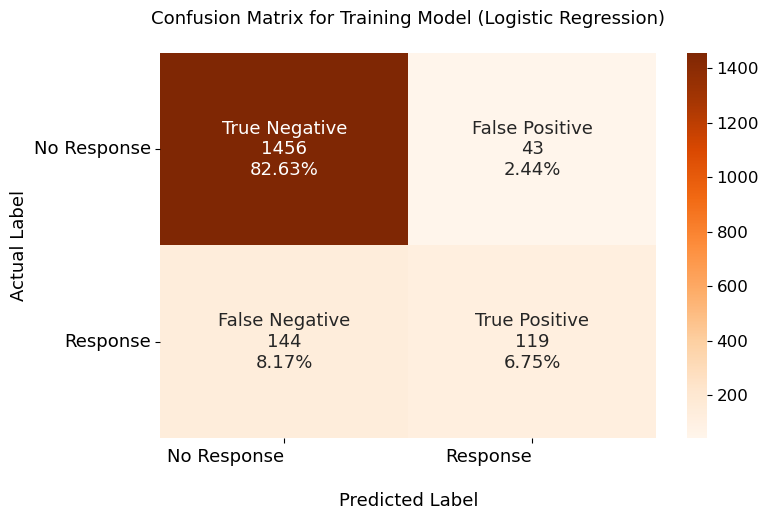

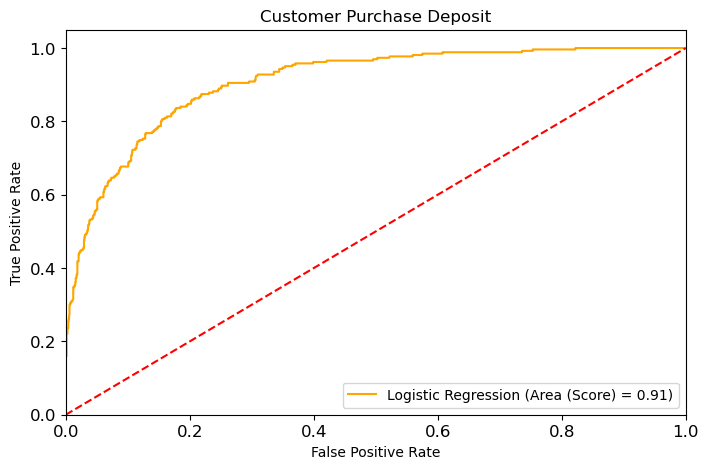

In [0]:
model_eval_train(log_model, "Logistic Regression", X_train, y_train)

In [0]:
profit_TP = 8  # Profit per each successful campaign
cost_FP = -3    # Cost per each falsely predicted successful campaign
loss_FN = -8   # Profit loss per each falsely predicted unsuccessful campaign

# Defining the confusion matrix (example)
TP = 119  # True positives
FP = 43   # False positives
FN = 144   # False negatives

# Calculating the total profit
total_profit = profit_TP * TP + cost_FP * FP + loss_FN * FN

print("Total Profit:", total_profit)

Total Profit: -329


In [0]:
def feature_importance_plot(model, X_train):
    imp = pd.DataFrame(data={
        'Attribute': X_train.columns,
        'Importance': model.coef_[0]
    })
    imp = imp.sort_values(by='Importance', ascending=False).set_index("Attribute")
    importances = imp["Importance"]

    plt.figure(figsize=(10,7))
    fig = importances.plot(kind='barh', color='#7faadb', width=0.8)
    plt.title('Features Importance Plot (Logistic Regression)\n', fontsize=14)

    # Annotate every single Bar with its value, based on it's width   
    N = len(importances)
    thickness = range(1, N+1)
    thick_sum = sum(thickness) 
    barmax = max(importances) 
    for i, p in enumerate(fig.patches):
            fig.annotate("%.2f" % (p.get_width()),
                        (p.get_x() + p.get_width(), p.get_y() + 1),
                        xytext=(5, 15), textcoords='offset points')
            fig.set_ylim(N, -1)
            fig.set_xlim(0,barmax*1.4)

    fig.figure.tight_layout()
    plt.show()

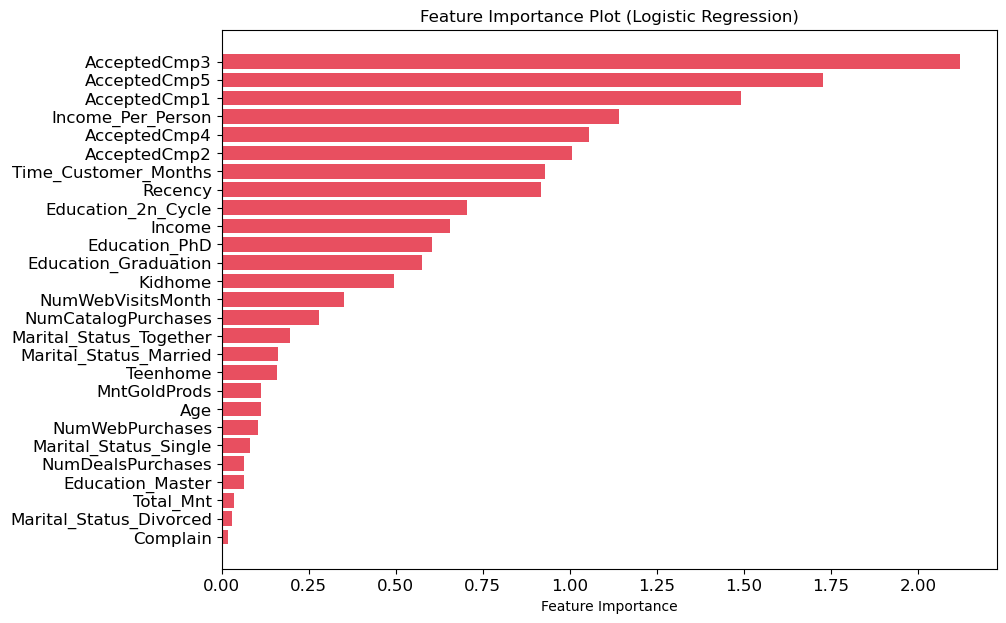

In [0]:
def feature_importance_plot(model, X_train):
    feature_importance = np.abs(model.coef_[0])
    feature_names = X_train.columns
    sorted_idx = np.argsort(feature_importance)
    
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color=ifood_colors[1])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Plot (Logistic Regression)')
    plt.show()

feature_importance_plot(log_model, X_train)

### 1.7.4 Trying oversampling on train

In [0]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Verifique o balanceamento das classes antes do oversampling
print("Contagem de classes antes do oversampling:", Counter(y_train))

# Crie uma instância do SMOTE
smote = SMOTE(random_state=42)

# Aplique o SMOTE ao conjunto de treinamento
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verifique o balanceamento das classes após o oversampling
print("Contagem de classes após o oversampling:", Counter(y_train_resampled))

Contagem de classes antes do oversampling: Counter({0: 1499, 1: 263})
Contagem de classes após o oversampling: Counter({0: 1499, 1: 1499})


In [0]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(solver='lbfgs', max_iter=len(X_train_resampled), random_state=42).fit(X_train_resampled, y_train_resampled)
print(log_model)

LogisticRegression(max_iter=2998, random_state=42)


Classification Report Training Model (Logistic Regression):

F1 Score = 0.83
ROC AUC = 0.922

==== Actual Data (Train) =====
Total = 2998
No Response = 1499
Response = 1499
==== Predicted Data (Train) =====
TP = 1224, FP = 226, TN = 1273, FN = 275
Predictly Correct = 2497
Predictly Wrong = 501 



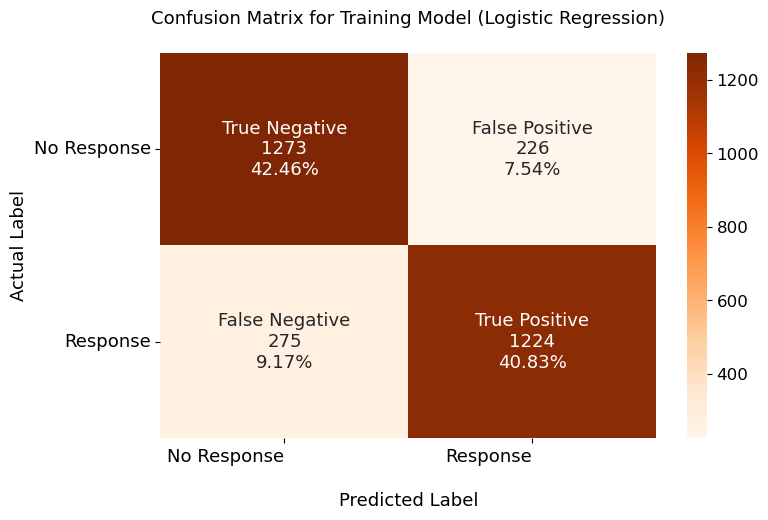

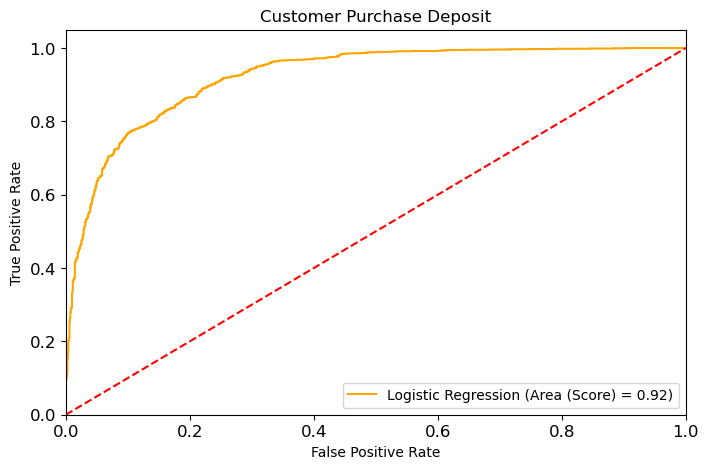

In [0]:
model_eval_train(log_model, "Logistic Regression", X_train_resampled, y_train_resampled)

In [0]:
profit_TP = 8  # Profit per each successful campaign
cost_FP = -3    # Cost per each falsely predicted successful campaign
loss_FN = -8   # Profit loss per each falsely predicted unsuccessful campaign

# Defining the confusion matrix (example)
TP = 1224  # True positives
FP = 226   # False positives
FN = 275   # False negatives

# Calculating the total profit
total_profit = profit_TP * TP + cost_FP * FP + loss_FN * FN

print("Total Profit:", total_profit)

Total Profit: 6914


### 1.7.5 Evaluation on test

In [0]:
X_test.drop(columns=['Marital_Status_Widow', 'MntWines','MntFruits','MntMeatProducts','MntFishProducts',
                      'MntSweetProducts', 'NumStorePurchases', 'Education_Basic', 'Total_Purchases'], inplace=True)

In [0]:
def model_eval_test(classifier, model_name, X_test, y_test):

    # predict data test
    y_test_pred = classifier.predict(X_test)
    y_test_pred_prob = classifier.predict_proba(X_test)

    # print classification report
    print('Classification Report Testing Model ('+model_name+'):\n')
    f1_s = round(f1_score(y_test, y_test_pred), 3)
    rocauc_score = round(roc_auc_score(y_test, y_test_pred_prob[:, 1]), 3)
    
    print(f'F1 Score = {f1_s}')
    print(f'ROC AUC = {rocauc_score}\n')

    # form confusion matrix as a dataFrame
    conf_matrix = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No Response', 'Response'), ('No Response', 'Response'))
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

    print("==== Actual Data (Test) =====")
    print("Total =", len(y_test))
    print("No Response =", len(y_test[y_test == 0]))
    print("Response =", len(y_test[y_test == 1]))
    print("==== Predicted Data (Test) =====")
    print("TP = {}, FP = {}, TN = {}, FN = {}".format(tp, fp, tn, fn))
    print("Predictly Correct =", tn+tp)
    print("Predictly Wrong =", fn+fp, "\n")

    # plot confusion matrix
    plt.figure(figsize=[8,5])
    
    c_matrix = confusion_matrix(y_test, y_test_pred)
    names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    heatmap = sns.heatmap(conf_matrix, annot = labels, annot_kws={'size': 13}, fmt='', cmap='Oranges')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=13)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=13)

    plt.title('Confusion Matrix for Testing Model ('+model_name+')\n', fontsize=13, color='black')
    plt.ylabel('Actual Label', fontsize=13)
    plt.xlabel('\nPredicted Label', fontsize=13)
    plt.show()
    print("\n")

    # ROC AUC Curve
    plt.figure(figsize=[8,5])
    fpr, tpr, threshold = roc_curve(y_test, y_test_pred_prob[:, 1])
    plt.plot(fpr, tpr, label = model_name+' (Area (Score) = %0.2f)'%rocauc_score, color='orange')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Customer Purchase Deposit')
    plt.legend(loc="lower right")
    plt.show()


Classification Report Testing Model (Logistic Regression):

F1 Score = 0.578
ROC AUC = 0.884

==== Actual Data (Test) =====
Total = 448
No Response = 381
Response = 67
==== Predicted Data (Test) =====
TP = 50, FP = 56, TN = 325, FN = 17
Predictly Correct = 375
Predictly Wrong = 73 



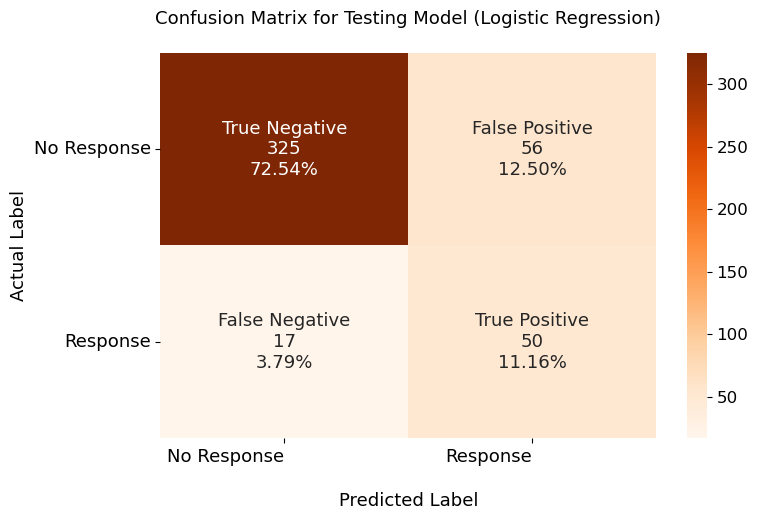

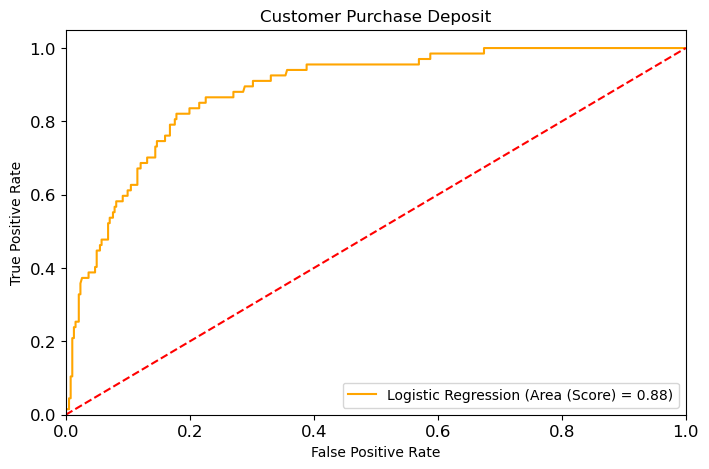

In [0]:
model_eval_test(log_model, "Logistic Regression", X_test, y_test)

In [0]:
profit_TP = 8  # Profit per each successful campaign
cost_FP = -3    # Cost per each falsely predicted successful campaign
loss_FN = -8   # Profit loss per each falsely predicted unsuccessful campaign

# Defining the confusion matrix (example)
TP = 50  # True positives
FP = 56   # False positives
FN = 17   # False negatives

# Calculating the total profit
total_profit = profit_TP * TP + cost_FP * FP + loss_FN * FN

print("Total Profit:", total_profit)

Total Profit: 96


PermutationExplainer explainer: 449it [00:33, 11.92it/s]                                                               


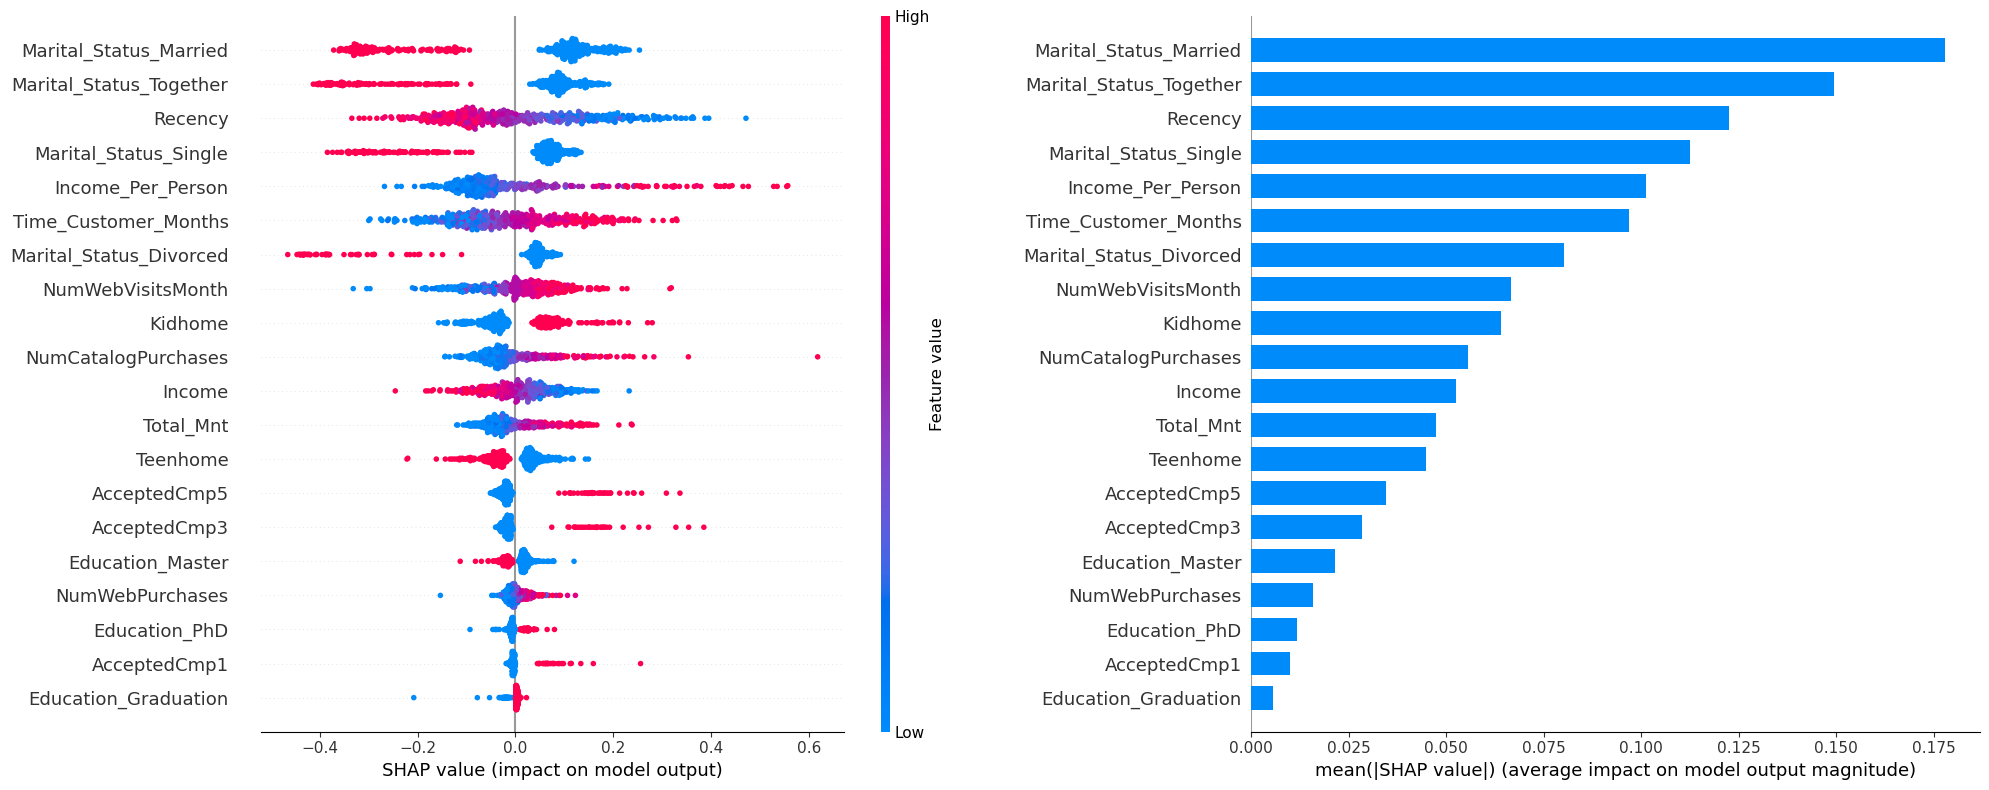

In [0]:
import shap
import re

def shap_plot(model, model_name, data=None):
    
    model_name = re.sub('\s*\(\w*\)\s*', '', model_name)
    
    shap.initjs()
    
    if model_name == "Logistic Regression":
        explainer = shap.Explainer(model.predict, data)
        shap_values = explainer(data)

        fig = plt.figure()
        ax0 = fig.add_subplot(121)
        shap.summary_plot(shap_values.values, data, show = False) 
        ax1 = fig.add_subplot(122)
        shap.summary_plot(shap_values.values, data, plot_type='bar', show = False, cmap = "plasma")
        plt.gcf().set_size_inches(20,8)
        plt.tight_layout() 
        plt.show()

        return shap.force_plot(shap_values.base_values[0], shap_values.values[0], data.iloc[0,:], plot_cmap = "PkYg", show = False)
    
    else:
        print("Model type not supported for SHAP visualization.")

# Chame a função shap_plot com seu modelo de regressão logística e os dados correspondentes
shap_plot(log_model, "Logistic Regression", X_test)